## A reduced wood pyrolysis mechanism to estimate solid and gas phase combustion parameters

## Import TGA to estimate kinetic parameters

The following code was written to develop a reduced-order wood pyrolysis model from TGA, GC, and DSC experiments performed at different heating rates. 

In [2]:
import pandas as pd
import numpy as np
import cantera as ct
from scipy import integrate
from scipy import interpolate
from scipy import optimize
# Specify the name of the file which has the data
Filename='MHP TGA dataset November 2023'

# Specify the heating rates and create an array to store the value of the heating rates
hrate=[5, 10, 20, 'open_5']
nhrate = len(hrate)

# The data exported by Proteus has a large number of points at a rate of 600 acquisition points per minute.
# The data needs to be downsampled to a specified number of points as desired by the user.

ndatapts=3500
gas = ct.Solution('four_step_pyrolysis.yaml')

In [3]:
gas.species_names

['O2', 'H2O', 'CH4', 'CO', 'CO2', 'N2', 'H2']

In [5]:
# Creating an ExcelWriter object to write data to multiple sheets
with pd.ExcelWriter('Resized {}.xlsx'.format(Filename)) as writer:
    
    # Loop to iterate through the sheets in MS Excel file that has the data of each heating rate
    for j in range (0,nhrate):
        
        # Read the data from the desired sheet in the MS Excel file
        TGAdata = pd.read_excel('{}.xlsx'.format(Filename),sheet_name='{}Kmin'.format(hrate[j]))
       
        # Create an arrray with equally spaced points in time by using np.linspace.
        # https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
        Raw_time=TGAdata['Time']
        rtlen = len(Raw_time)
        Time = np.linspace(Raw_time[0],Raw_time[rtlen-1],num=ndatapts)
        tr = len(Time)
        
        # Calculate the values of temperature and mass at each point using 1D interpolation. 
        # The best way is to use time data in plae for the points at which the value to be interpolated is evaluated. 
        # This is because the function needs the reference points to be increasing monotonously.
        Temperature= np.interp(Time,TGAdata['Time'],TGAdata['Temperature'])
        NRM = np.interp(Time,TGAdata['Time'],TGAdata['NRM'])
        
        # Store the values into the DataFrame
        Resized_data=pd.DataFrame({'Time':Time,'Temperature':Temperature,'NRM':NRM})
        
        #Write the DataFrame to a specified sheet in an MS-Excel file
        Resized_data.to_excel(writer,sheet_name=f'{hrate[j]}Kmin')

The below cell does the following:

1. Import matplotlib library and reference it as 'plt'. matplotlib.pyplot is a collection of functions that make matplotlib work like MATLAB.https://matplotlib.org/stable/tutorials/pyplot.html
2. Plot the raw data
3. Plot the resized data. This will serve as a checkpoint to check whether the interpolation is good.

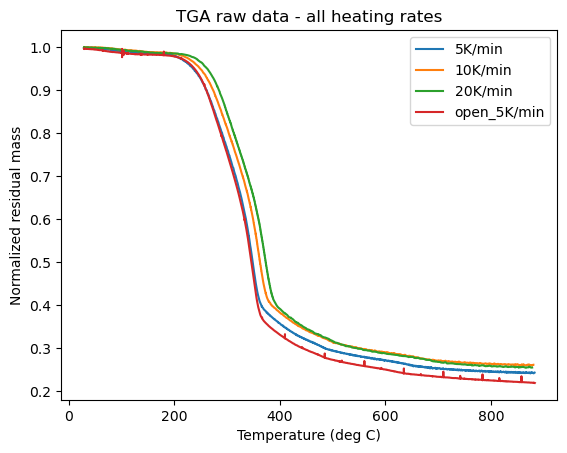

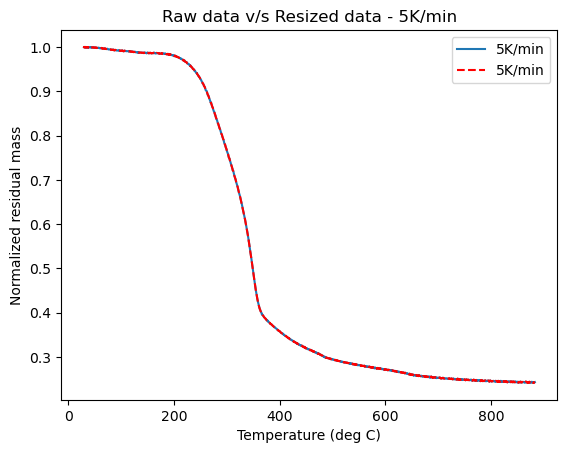

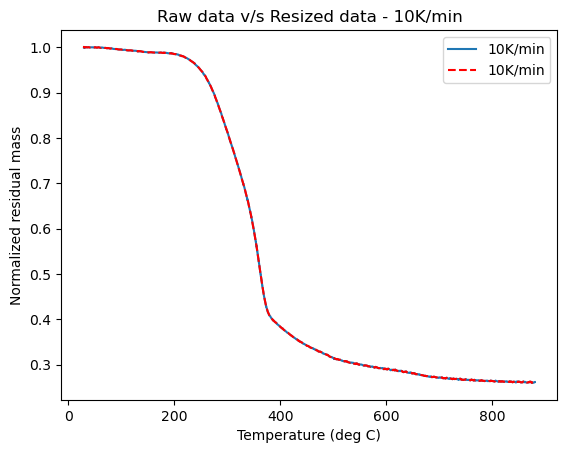

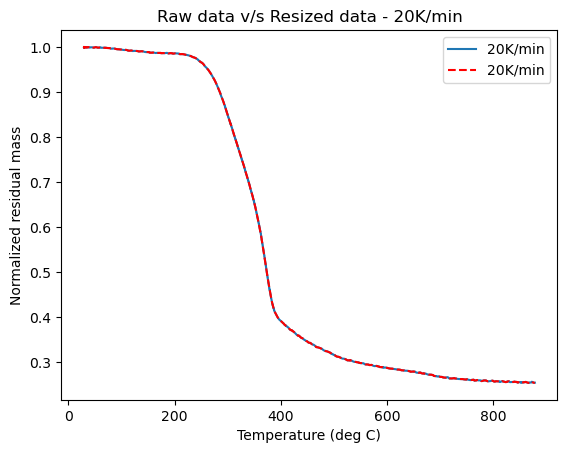

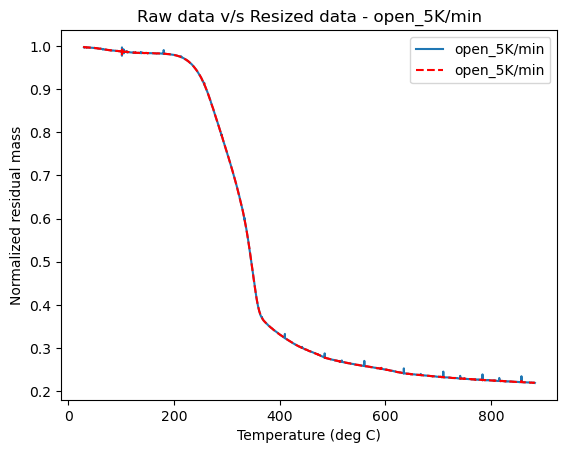

In [6]:
import matplotlib.pyplot as plt

for j in range (0,nhrate):
    
    plt.figure(1)
    TGAdata = pd.read_excel('{}.xlsx'.format(Filename),sheet_name=f'{hrate[j]}Kmin')
    plt.plot(TGAdata['Temperature'],TGAdata['NRM'],label= "{}K/min".format(hrate[j]))
    plt.title('TGA raw data - all heating rates')
    plt.xlabel ('Temperature (deg C)')
    plt.ylabel ('Normalized residual mass')
    plt.legend()
    plt.savefig('{} raw data.png'.format(Filename),dpi=600) 

for j in range (0,nhrate):
    
    plt.figure()
    TGAdata = pd.read_excel('{}.xlsx'.format(Filename),sheet_name=f'{hrate[j]}Kmin')
    plt.plot(TGAdata['Temperature'],TGAdata['NRM'],label= "{}K/min".format(hrate[j]))
    Resized_TGAdata = pd.read_excel('Resized {}.xlsx'.format(Filename),sheet_name=f'{hrate[j]}Kmin')
    plt.plot(Resized_TGAdata['Temperature'],Resized_TGAdata['NRM'],'r--',label= "{}K/min".format(hrate[j]))
    plt.title('Raw data v/s Resized data - {}K/min'.format(hrate[j]))
    plt.xlabel ('Temperature (deg C)')
    plt.ylabel ('Normalized residual mass')
    plt.legend()

The below cell does the following:

1. Import matplotlib library and reference it as 'plt'.
2. Import savgol_filter (Savitzky-Golay) filter and smooth the data.
3. Calculate the mass loss rate
4. Plot the smoothed data vs raw data, smoothed mass and mass loss rate data

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Creating an ExcelWriter object to write data to multiple sheets
with pd.ExcelWriter('Smoothed {}.xlsx'.format(Filename)) as writer:

    Red_data = pd.DataFrame([])
    #The number of data points which the SG filter uses to fit the polynomial
    sgfwindow=111
    # Loop to iterate through the sheets in MS Excel file that has the data of each heating rate
    for j in range (0,nhrate):
    
        # Read the data from the desired sheet in the MS Excel file
        Resized_TGAdata = pd.read_excel('Resized {}.xlsx'.format(Filename),sheet_name=f'{hrate[j]}Kmin')
        Red_data[f'Temp{hrate[j]}']=Resized_TGAdata['Temperature']

        # Subtract the initial time from all values in the array
        tstart = Resized_TGAdata['Time'].iloc[0]
        Time = (Resized_TGAdata['Time']-tstart)*60
        Red_data[f'Time{hrate[j]}']=Time
    
        # Apply SG filter to the mass data
        smoothed_NRM = savgol_filter(Resized_TGAdata['NRM'],sgfwindow,2)
        Red_data[f'NRM{hrate[j]}']=smoothed_NRM
        
        # Calculate the mass loss rate
        MLR = -1.0*np.gradient(smoothed_NRM,Time)
        # Apply SG filter to the mass loss rate data
        smoothed_MLR = savgol_filter(MLR,sgfwindow,2)
        Red_data[f'MLR{hrate[j]}']=smoothed_MLR
    
        # Store the values into the DataFrame
        Smoothed_data=pd.DataFrame({'Time':Time,'Temperature':Temperature,'NRM':smoothed_NRM,'MLR':smoothed_MLR})
        
        #Write the DataFrame to a specified sheet in an MS-Excel file
        Smoothed_data.to_excel(writer,sheet_name=f'{hrate[j]}Kmin')

In [8]:
temp1 = Red_data[f'Temp{hrate[0]}']
nrm1 = Red_data[f'NRM{hrate[0]}']
mlr1 = Red_data[f'MLR{hrate[0]}']
temp2 = Red_data[f'Temp{hrate[1]}']
nrm2 = Red_data[f'NRM{hrate[1]}']
mlr2 = Red_data[f'MLR{hrate[1]}']
temp3 = Red_data[f'Temp{hrate[2]}']
nrm3 = Red_data[f'NRM{hrate[2]}']
mlr3 = Red_data[f'MLR{hrate[2]}']
temp4 = Red_data[f'Temp{hrate[3]}']
nrm4 = Red_data[f'NRM{hrate[3]}']
mlr4 = Red_data[f'MLR{hrate[3]}']

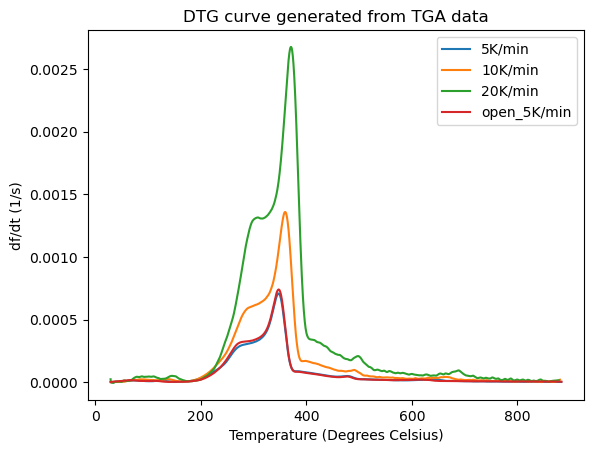

In [9]:
# Deciding the filter window

plt.figure(2)

plt.title("DTG curve generated from TGA data")
plt.plot(temp1, mlr1, label=f'{hrate[0]}K/min')
plt.plot(temp2, mlr2, label=f'{hrate[1]}K/min')
plt.plot(temp3, mlr3, label=f'{hrate[2]}K/min')
plt.plot(temp4, mlr4, label=f'{hrate[3]}K/min')
plt.xlabel('Temperature (Degrees Celsius)')
plt.ylabel('df/dt (1/s)')
plt.legend(loc='best')
plt.savefig('{} DTG.png'.format(Filename),dpi=600) 

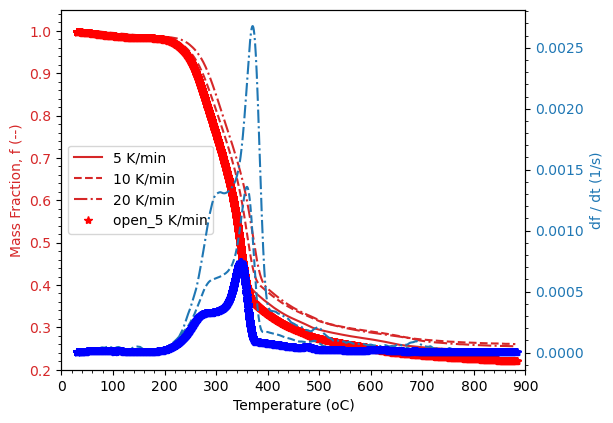

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Temperature (oC)')
ax1.set_ylabel('Mass Fraction, f (--)', color=color)
lns1=ax1.plot(temp1, nrm1, color=color,label=f'{hrate[0]} K/min')
lns11=ax1.plot(temp2, nrm2, linestyle = '--', color=color,label=f'{hrate[1]} K/min')
lns12=ax1.plot(temp3, nrm3, linestyle = '-.', color=color,label=f'{hrate[2]} K/min')
lns13=ax1.plot(temp4, nrm4,  'r*',label=f'{hrate[3]} K/min')
ax1.tick_params(axis='y', labelcolor=color)
plt.xlim (0,900)
plt.ylim (0.2,1.05)
plt.minorticks_on()
plt.legend(loc='center left')

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('df / dt (1/s)', color=color)  
lns2=ax2.plot(temp1, mlr1, color=color)
lns21=ax2.plot(temp2, mlr2, linestyle = '--',color=color)
lns22=ax2.plot(temp3, mlr3, linestyle = '-.',color=color)
lns23=ax2.plot(temp4, mlr4, 'b*')
ax2.tick_params(axis='y', labelcolor=color)
plt.minorticks_on()

plt.subplots_adjust(top=0.9, bottom=0.15, left=0.125, right=0.85, hspace=0.2,wspace=0.3) 

plt.savefig('{} TG and DTG.png'.format(Filename),dpi=600)

Red_data.to_excel('Smoothed data.xlsx')

In [11]:
from scipy import integrate
from scipy.integrate import odeint
import time
from scipy import optimize


start_time=time.time()
df_predict = pd.DataFrame([])

TGAdata = pd.read_excel('Smoothed data.xlsx')
temp_init=30
Rbar=8.314

rssalpha = np.ones(nhrate)
totsol = np.ones(nhrate)

dpro=0.005
promax=0.735
pro_in = np.arange(0,promax+(dpro/2.),dpro)
npro = len(pro_in)
df_predict['progress']=pro_in
df_predict['Alpha_data']=1-pro_in


for i in range (0,nhrate-1):     
    TGAdata[f'progress{hrate[i]}'] = 1.0 - TGAdata[f'NRM{hrate[i]}']
    df_predict[f'Temp{hrate[i]}']=pd.Series(np.interp(df_predict['progress'],TGAdata[f'progress{hrate[i]}'],TGAdata[f'Temp{hrate[i]}']))
    df_predict[f'Time{hrate[i]}']=(df_predict[f'Temp{hrate[i]}']-temp_init)/(hrate[i]/60)

In [12]:
# change the bounds - Shrikar April 19, 2024

def mlrfunc(y,t,A1,E1,A2,E2,A3,E3,HR):
    y1, y2, y3 = y
    temp = temp_init+((HR/60)*t)+273
    r1 = -1*(y1**1)*A1*np.exp(-E1/Rbar/temp)
    r2 = -1*(y2**1)*A2*np.exp(-E2/Rbar/temp)
    r3 = -1*(y3**1)*A3*np.exp(-E3/Rbar/temp)
    dydt = [r1, r2, r3] 
    return dydt
 
def fun (x):
    # A1=10**8.000
    # E1=68966
    A1=10**x[0]
    E1=x[1]
    A2=10**x[2]
    E2=x[3]
    A3=10**x[4]
    E3=x[5]
    #n1 = x[6]
    #n2 = x[7]
    #n3 = x[8]
    #n3 = x[6]
    fres=0.265
    f1=0.25
    f2=0.33
    f3=1-f1-f2-fres
    y0=[f1,f2,f3]
    
    for i in range (0,nhrate-1):    
        times = df_predict[f'Time{hrate[i]}']
        sol = odeint(mlrfunc, y0, times, args=(A1, E1, A2, E2, A3, E3, hrate[i]))
        tot_sol = sol[:,0]+sol[:,1]+sol[:,2]+fres
        df_predict[f'Alpha_pred{hrate[i]}']=tot_sol
        rssalpha[i] = (pd.Series(np.sum((df_predict[f'Alpha_data']*100-df_predict[f'Alpha_pred{hrate[i]}']*100)**2)))/npro
    
    loss = np.sum(rssalpha)
    return(loss) 
#bounds = [(3,12),(80000,200000),(5,20),(150000,300000),(3,14),(20000,200000)]
bounds = [(3,12),(80000,200000),(5,20),(150000,300000),(3,14),(20000,200000)]
results = dict()
results['DE']=optimize.differential_evolution(fun,bounds,seed=2)
results['DE']
print (results)

C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\3786029120.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rssalpha[i] = (pd.Series(np.sum((df_predict[f'Alpha_data']*100-df_predict[f'Alpha_pred{hrate[i]}']*100)**2)))/npro
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\3786029120.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rssalpha[i] = (pd.Series(np.sum((df_predict[f'Alpha_data']*100-df_predict[f'Alpha_pred{hrate[i]}']*100)**2)))/npro
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\3786029120.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rssalpha[i] = (pd.Series(np.sum((df_predict[f'Alpha_data']*100-df_predict[f'Alpha_pred{hrate[i]}']*100)**2)))/npro
C:\Users\s

{'DE':              message: Optimization terminated successfully.
             success: True
                 fun: 5.267698231204681
                   x: [ 7.290e+00  1.020e+05  1.406e+01  1.937e+05
                        3.042e+00  7.823e+04]
                 nit: 168
                nfev: 16302
          population: [[ 7.290e+00  1.020e+05 ...  3.042e+00  7.823e+04]
                       [ 7.194e+00  1.009e+05 ...  3.013e+00  7.764e+04]
                       ...
                       [ 7.278e+00  1.019e+05 ...  3.047e+00  7.775e+04]
                       [ 7.417e+00  1.033e+05 ...  3.060e+00  7.863e+04]]
 population_energies: [ 5.268e+00  5.331e+00 ...  5.334e+00  5.288e+00]}


In [13]:
# print A and E

A1 = results['DE'].x[0]
E1 = results['DE'].x[1]
A2 = results['DE'].x[2]
E2 = results['DE'].x[3]
A3 = results['DE'].x[4]
E3 = results['DE'].x[5]

[1.52426853 1.19342216 1.54892973 1.        ]
Run Time: 688.171587228775


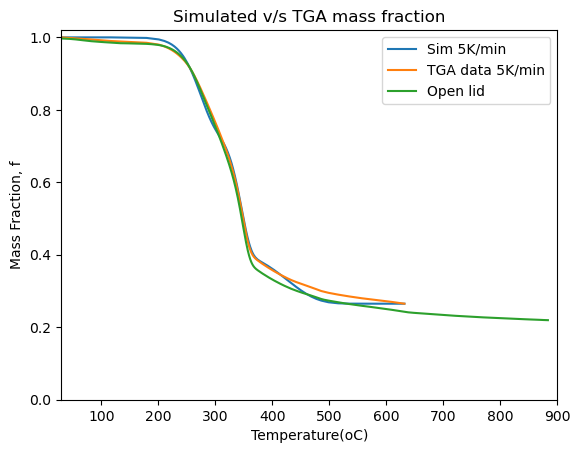

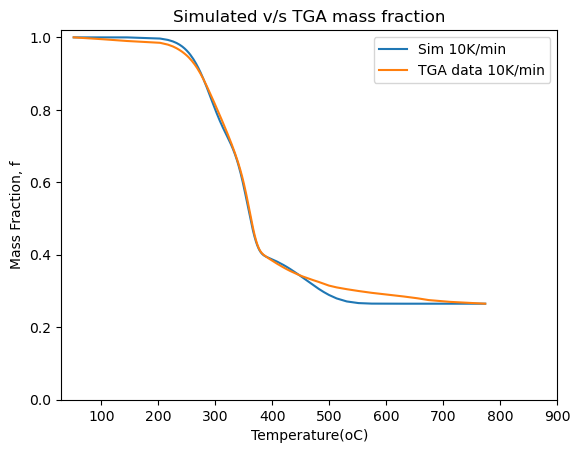

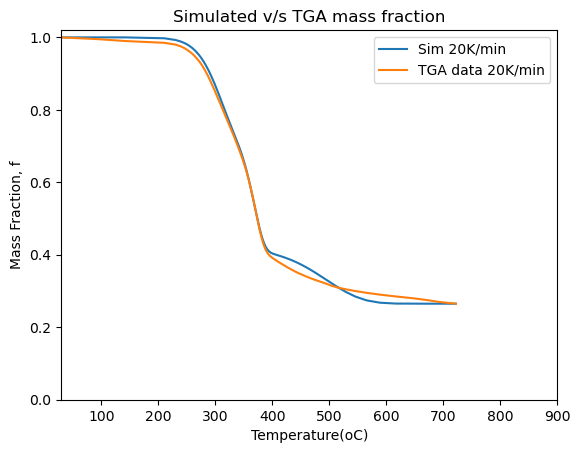

In [14]:
x0 = df_predict[f'Temp{hrate[0]}']
y01 = df_predict[f'Alpha_pred{hrate[0]}']
y02 = df_predict['Alpha_data']
x1 = df_predict[f'Temp{hrate[1]}']
y11 = df_predict[f'Alpha_pred{hrate[1]}']
y12 = df_predict['Alpha_data']
x2 = df_predict[f'Temp{hrate[2]}']
y21 = df_predict[f'Alpha_pred{hrate[2]}']
y22 = df_predict['Alpha_data']

plt.figure (3)

plt.title("Simulated v/s TGA mass fraction")
plt.plot(x0, y01, label=f'Sim {hrate[0]}K/min')
plt.plot(x0,y02,label=f'TGA data {hrate[0]}K/min')
plt.plot(temp4, nrm4, label='Open lid')
plt.legend(loc='best')
plt.xlabel('Temperature(oC)')
plt.ylabel('Mass Fraction, f')
plt.xlim (30,900)
plt.ylim (0.0,1.02)
plt.savefig('{} MF comparison 5K_min.png'.format(Filename),dpi=600)

plt.figure (4)
plt.title("Simulated v/s TGA mass fraction")
plt.plot(x1, y11, label=f'Sim {hrate[1]}K/min')
plt.plot(x1,y12,label=f'TGA data {hrate[1]}K/min')
plt.legend(loc='best')
plt.xlabel('Temperature(oC)')
plt.ylabel('Mass Fraction, f')
plt.xlim (30,900)
plt.ylim (0.0,1.02)
plt.savefig('{} MF comparison 10K_min.png'.format(Filename),dpi=600)

plt.figure (5)
plt.title("Simulated v/s TGA mass fraction")
plt.plot(x2, y21, label=f'Sim {hrate[2]}K/min')
plt.plot(x2,y22,label=f'TGA data {hrate[2]}K/min')
plt.legend(loc='best')
plt.xlabel('Temperature(oC)')
plt.ylabel('Mass Fraction, f')
plt.xlim (30,900)
plt.ylim (0.0,1.02) 
plt.savefig('{} MF comparison 20K_min.png'.format(Filename),dpi=600)

print(rssalpha)
df_predict.to_excel('Prediction with four reactions.xlsx')

end_time = time.time()
run_time = end_time - start_time
print(f'Run Time: {run_time}')

In [15]:
TG_5K = pd.DataFrame([])
TG_10K = pd.DataFrame([])
TG_20K = pd.DataFrame([])

TG_5K['Temperature (K)'] = x0 + 273.15
TG_5K['Experiment'] = y02
TG_5K['Simulated'] = y01

TG_10K['Temperature (K)'] = x1 + 273.15
TG_10K['Experiment'] = y12
TG_10K['Simulated'] = y11

TG_20K['Temperature (K)'] = x2 + 273.15
TG_20K['Experiment'] = y22
TG_20K['Simulated'] = y21

with pd.ExcelWriter('TGA fractions.xlsx') as writer:
    TG_5K.to_excel(writer,sheet_name='5Kmin')
    TG_10K.to_excel(writer,sheet_name='10Kmin')
    TG_20K.to_excel(writer,sheet_name='20Kmin')

[1.52426853 1.19342216 1.54892973 1.        ]
Run Time: 696.2579381465912


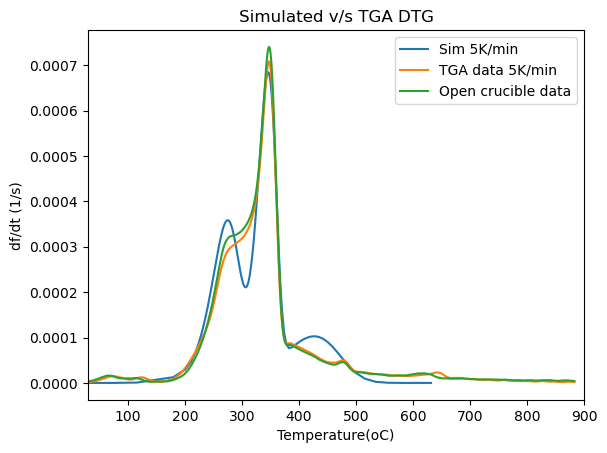

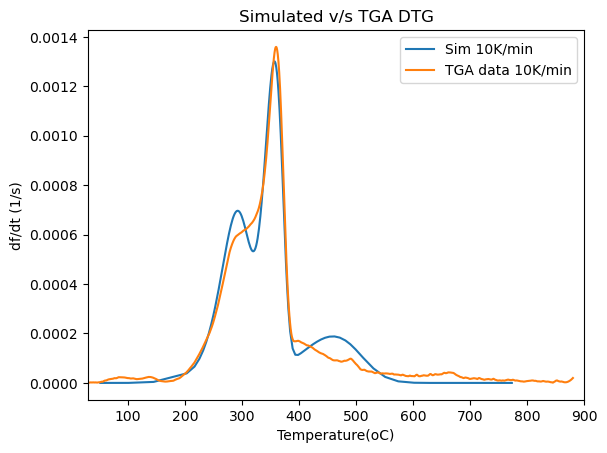

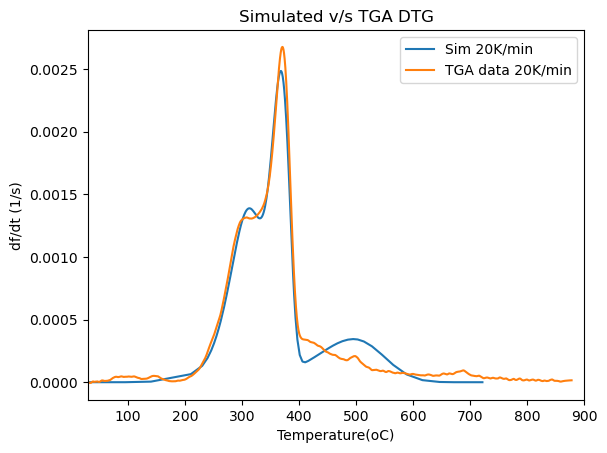

In [16]:
for i in range (0,nhrate-1):
    df_predict[f'MLR{hrate[i]}']=-1.0*np.gradient(df_predict[f'Alpha_pred{hrate[i]}'],df_predict[f'Time{hrate[i]}'])


x0 = df_predict[f'Temp{hrate[0]}']
y01 = df_predict[f'MLR{hrate[0]}']

x1 = df_predict[f'Temp{hrate[1]}']
y11 = df_predict[f'MLR{hrate[1]}']

x2 = df_predict[f'Temp{hrate[2]}']
y21 = df_predict[f'MLR{hrate[2]}']


plt.figure (3)

plt.title("Simulated v/s TGA DTG")
plt.plot(x0, y01, label=f'Sim {hrate[0]}K/min')
plt.plot(temp1,mlr1,label=f'TGA data {hrate[0]}K/min')
plt.plot(temp4,mlr4,label='Open crucible data')
plt.legend(loc='best')
plt.xlabel('Temperature(oC)')
plt.ylabel('df/dt (1/s)')
plt.xlim (30,900)
plt.savefig('{} DTG comparison 5K_min.png'.format(Filename),dpi=600)

plt.figure (4)
plt.title("Simulated v/s TGA DTG")
plt.plot(x1, y11, label=f'Sim {hrate[1]}K/min')
plt.plot(temp2,mlr2,label=f'TGA data {hrate[1]}K/min')
plt.legend(loc='best')
plt.xlabel('Temperature(oC)')
plt.ylabel('df/dt (1/s)')
plt.xlim (30,900)
plt.savefig('{} DTG comparison 10K_min.png'.format(Filename),dpi=600)

plt.figure (5)
plt.title("Simulated v/s TGA DTG")
plt.plot(x2, y21, label=f'Sim {hrate[2]}K/min')
plt.plot(temp3,mlr3,label=f'TGA data {hrate[2]}K/min')
plt.legend(loc='best')
plt.xlabel('Temperature(oC)')
plt.ylabel('df/dt (1/s)')
plt.xlim (30,900)
plt.savefig('{} DTG comparison 20K_min.png'.format(Filename),dpi=600)

print(rssalpha)
df_predict.to_excel('Prediction with four reactions.xlsx')

end_time = time.time()
run_time = end_time - start_time
print(f'Run Time: {run_time}')

The following code cells show the separation of the sensible specific heats for each pseudo-component.

In [17]:
# Estimate mass fractions of components at any given heating rate

def estimate_mass_fractions(hr, A1, E1, A2, E2, A3, E3):
    
    final_temp = 1173.15
    initial_temp = 300
    
    times_hr = np.linspace(0,((final_temp - initial_temp)*60)/hr,500)
    temp_hr = 300 + ((hr/60)*times_hr)

    f1 = 0.25 # hemicellulose
    f2 = 0.33 # cellulose
    f3 = 0.155 # lignin
    #f1 = 0.28 # hemicellulose
    #f2 = 0.32 # cellulose
    #f3 = 0.135 # lignin
    fres = 0.265 # char

    y0=[f1,f2,f3]
    
    #A1 = 7.290e+00
    #E1 = 1.020e+05
    #A2 = 1.406e+01  
    #E2 = 1.937e+05
    #A3 = 3.042e+00  
    #E3 = 7.823e+04
    #A1 = 7.35937560e+00 # hemicellulose
    #E1 = 1.02731313e+05
    #A2 = 1.40226780e+01
    #E2 = 1.93283521e+05
    #A3 = 3.01335789e+00
    #E3 = 7.78650093e+04
    
    sol = odeint(mlrfunc, y0, times_hr, args =(10**A1, E1, 10**A2, E2,10**A3, E3, hr))

    f_hemicellulose = sol[:,0]/(1 - fres)
    f_cellulose = sol[:,1]/(1 - fres)
    f_lignin = sol[:,2]/(1 - fres)
    f_char = 1 - (f_hemicellulose + f_cellulose + f_lignin)
    
    return temp_hr, times_hr, f_hemicellulose, f_cellulose, f_lignin, f_char, sol[:,0], sol[:,1], sol[:,2]

[temp_1K, times_1K, f_hemicellulose_1K, f_cellulose_1K, f_lignin_1K, f_char_1K, fprime_hemicellulose_1K, fprime_cellulose_1K, fprime_lignin_1K] = estimate_mass_fractions(1, A1, E1, A2, E2, A3, E3)
[temp_5K, times_5K, f_hemicellulose_5K, f_cellulose_5K, f_lignin_5K, f_char_5K, fprime_hemicellulose_5K, fprime_cellulose_5K, fprime_lignin_5K] = estimate_mass_fractions(5, A1, E1, A2, E2, A3, E3)
[temp_10K, times_10K, f_hemicellulose_10K, f_cellulose_10K, f_lignin_10K, f_char_10K, fprime_hemicellulose_10K, fprime_cellulose_10K, fprime_lignin_10K] = estimate_mass_fractions(10, A1, E1, A2, E2, A3, E3)
[temp_20K, times_20K, f_hemicellulose_20K, f_cellulose_20K, f_lignin_20K, f_char_20K, fprime_hemicellulose_20K, fprime_cellulose_20K, fprime_lignin_20K] = estimate_mass_fractions(20, A1, E1, A2, E2, A3, E3)
[temp_40K, times_40K, f_hemicellulose_40K, f_cellulose_40K, f_lignin_40K, f_char_40K, fprime_hemicellulose_40K, fprime_cellulose_40K, fprime_lignin_40K] = estimate_mass_fractions(40, A1, E1, A2, E2, A3, E3)

Compute relative errors

In [18]:
# Computing relative errors for 5, 10, 20 K/min

times_5K_error = np.interp(x0 + 273.15, temp_5K, times_5K)
times_10K_error = np.interp(x1 + 273.15, temp_10K, times_10K)
times_20K_error = np.interp(x2 + 273.15, temp_20K, times_20K)

mlr_5K_error = -np.gradient(df_predict['Alpha_data'].values, times_5K_error)
mlr_10K_error = -np.gradient(df_predict['Alpha_data'].values, times_10K_error)
mlr_20K_error = -np.gradient(df_predict['Alpha_data'].values, times_20K_error)

errors_5K = np.zeros(np.shape(mlr_5K_error))
errors_10K = np.zeros(np.shape(mlr_10K_error))
errors_20K = np.zeros(np.shape(mlr_20K_error))

for i in range(len(mlr_5K_error)):
    errors_5K[i] = ((mlr_5K_error[i] - y01[i]))/mlr_5K_error[i]
errors_10K = ((mlr_10K_error - y11))/mlr_10K_error
errors_20K = ((mlr_20K_error - y21))/mlr_20K_error

print('The DTG relative error for 5 K/min is',np.sum(errors_5K)*100/len(errors_5K),' %')
print('The DTG relative error for 5 K/min is',np.sum(errors_10K)*100/len(errors_10K),' %')
print('The DTG relative error for 5 K/min is',np.sum(errors_20K)*100/len(errors_20K),' %')



The DTG relative error for 5 K/min is 0.5131285159223717  %
The DTG relative error for 5 K/min is 0.6449261437231988  %
The DTG relative error for 5 K/min is 0.6220234595796105  %


In [19]:
# Compute regression coefficients

res_ssq_5K = np.sum((y01 - mlr_5K_error)**2)
res_ssq_10K =  np.sum((y11 - mlr_10K_error)**2)
res_ssq_20K =  np.sum((y21 - mlr_20K_error)**2)

peak_5K = np.max(mlr_5K_error)
peak_10K = np.max(mlr_10K_error)
peak_20K = np.max(mlr_20K_error)

fit_5K = ((res_ssq_5K/len(y01))**0.5)/peak_5K
fit_10K = ((res_ssq_10K/len(y11))**0.5)/peak_10K
fit_20K = ((res_ssq_20K/len(y21))**0.5)/peak_20K

print(fit_5K)
print(fit_10K)
print(fit_20K)
print((fit_5K + fit_10K + fit_20K)/3)

0.0711651175984929
0.05650802724597828
0.04573740141250543
0.0578035154189922


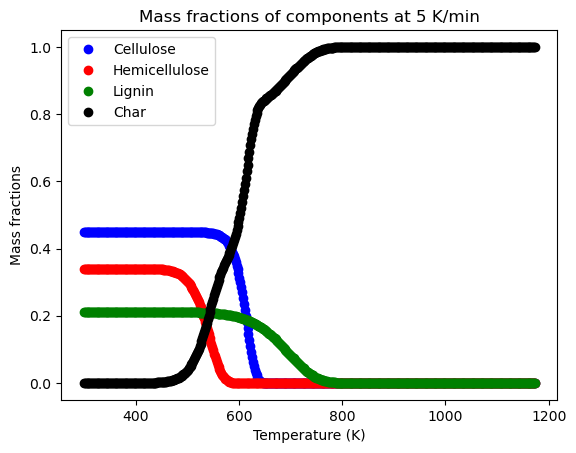

In [21]:
# New code cell created by Shrikar on April 5, 2024.

# Mass fractions of pseudo-components are plotted for different heating rates

plt.plot(temp_5K,f_cellulose_5K,'bo',label = 'Cellulose')
plt.plot(temp_5K,f_hemicellulose_5K,'ro',label='Hemicellulose')
plt.plot(temp_5K,f_lignin_5K,'go',label='Lignin')
plt.plot(temp_5K,f_char_5K,'ko',label='Char')
plt.legend()
plt.title('Mass fractions of components at 5 K/min')
plt.xlabel('Temperature (K)')
plt.ylabel('Mass fractions')
plt.show()

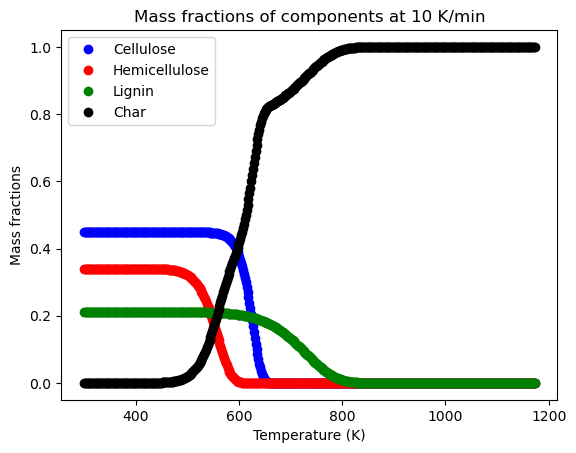

In [22]:

plt.plot(temp_10K,f_cellulose_10K,'bo',label = 'Cellulose')
plt.plot(temp_10K,f_hemicellulose_10K,'ro',label='Hemicellulose')
plt.plot(temp_10K,f_lignin_10K,'go',label='Lignin')
plt.plot(temp_10K,f_char_10K,'ko',label='Char')
plt.legend()
plt.title('Mass fractions of components at 10 K/min')
plt.xlabel('Temperature (K)')
plt.ylabel('Mass fractions')
plt.show()

Text(0.5, 1.0, 'Mass fraction of cellulose at different heating rates')

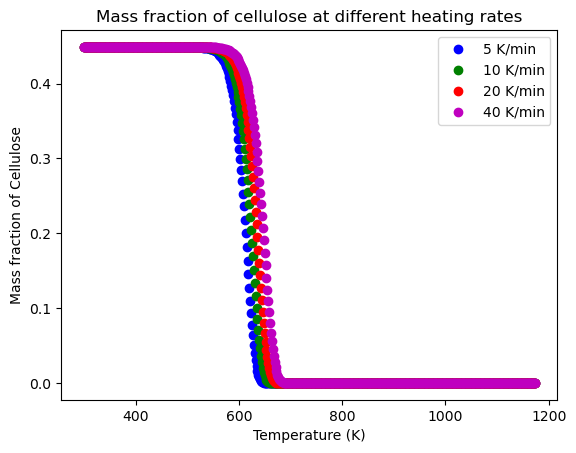

In [23]:
plt.plot(temp_5K,f_cellulose_5K,'bo',label = '5 K/min')
plt.plot(temp_10K,f_cellulose_10K,'go',label = '10 K/min')
plt.plot(temp_20K,f_cellulose_20K,'ro',label = '20 K/min')
plt.plot(temp_40K,f_cellulose_40K,'mo',label = '40 K/min')
plt.xlabel('Temperature (K)')
plt.ylabel('Mass fraction of Cellulose')
plt.legend()
plt.title('Mass fraction of cellulose at different heating rates')

Text(0.5, 1.0, 'Mass fraction of Hemicellulose at different heating rates')

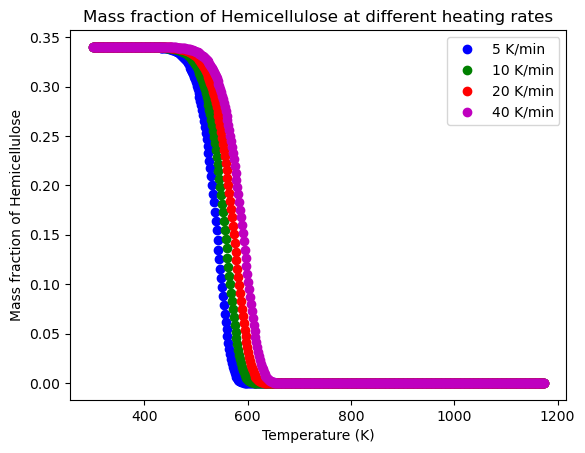

In [24]:
plt.plot(temp_5K,f_hemicellulose_5K,'bo',label = '5 K/min')
plt.plot(temp_10K,f_hemicellulose_10K,'go',label = '10 K/min')
plt.plot(temp_20K,f_hemicellulose_20K,'ro',label = '20 K/min')
plt.plot(temp_40K,f_hemicellulose_40K,'mo',label = '40 K/min')
plt.xlabel('Temperature (K)')
plt.ylabel('Mass fraction of Hemicellulose')
plt.legend()
plt.title('Mass fraction of Hemicellulose at different heating rates')

Text(0.5, 1.0, 'Mass fraction of Char at different heating rates')

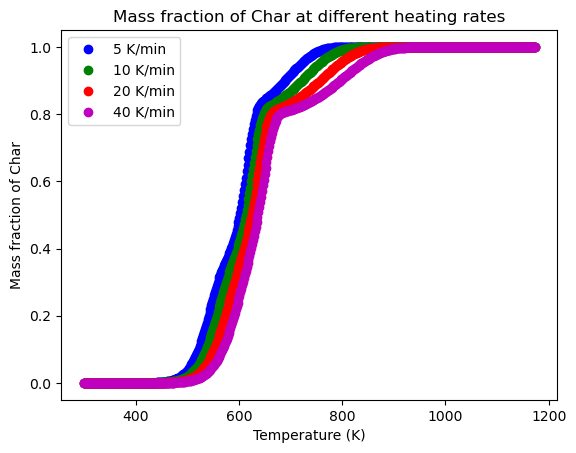

In [25]:
plt.plot(temp_5K,f_char_5K,'bo',label = '5 K/min')
plt.plot(temp_10K,f_char_10K,'go',label = '10 K/min')
plt.plot(temp_20K,f_char_20K,'ro',label = '20 K/min')
plt.plot(temp_40K,f_char_40K,'mo',label = '40 K/min')
plt.xlabel('Temperature (K)')
plt.ylabel('Mass fraction of Char')
plt.legend()
plt.title('Mass fraction of Char at different heating rates')

In [26]:
# Export mass fractions of pseudo-components

Mass_fractions_5K = pd.DataFrame([])
Mass_fractions_10K = pd.DataFrame([])
Mass_fractions_20K = pd.DataFrame([])
Mass_fractions_40K = pd.DataFrame([])

Mass_fractions_5K['Temperature (K)'] = temp_5K
Mass_fractions_5K['Hemicellulose mass fraction'] = f_hemicellulose_5K
Mass_fractions_5K['Cellulose mass fraction'] = f_cellulose_5K
Mass_fractions_5K['Lignin mass fraction'] = f_lignin_5K

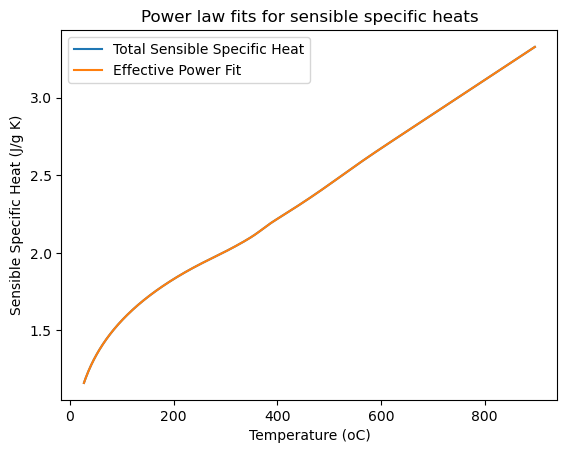

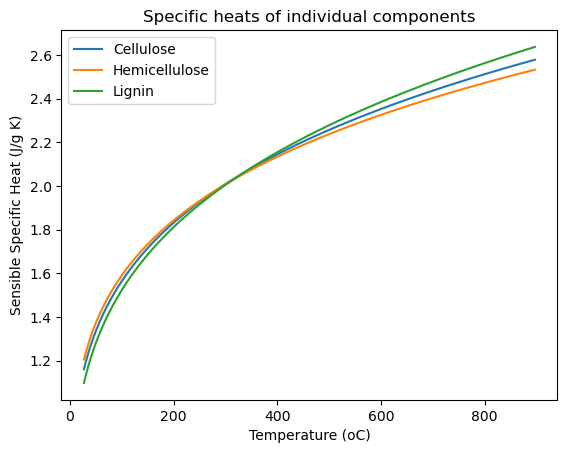

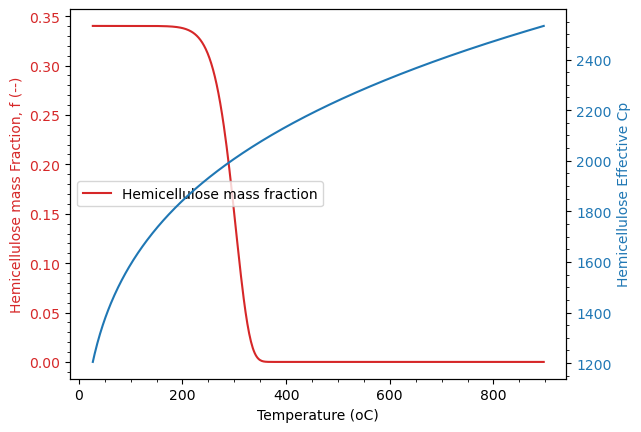

In [27]:
# updated optimization algorithm for sensible Cp's. Created on May 9, 2024.

# Separation of sensible specific heats

effective_sensible_cp_file = pd.read_excel('SensibleCp(withpowerlawtill230C)_050924.xlsx')
effective_sensible_cp_wood = effective_sensible_cp_file['SensibleCp'].values
effective_sensible_temp = effective_sensible_cp_file['Temperature'].values
# convert to Celsius and interpolate
f_hemicellulose_effective = np.interp(effective_sensible_temp+273.15, temp_20K, f_hemicellulose_20K)
f_cellulose_effective = np.interp(effective_sensible_temp+273.15, temp_20K, f_cellulose_20K)
f_lignin_effective = np.interp(effective_sensible_temp+273.15, temp_20K, f_lignin_20K)
f_char_effective = 1 - f_hemicellulose_effective - f_cellulose_effective - f_lignin_effective
#char_coeffs = [0.002154, 0.7648]
char_coeffs = [0.0022, 1.3533]
#C_char_effective = (char_coeffs[0]*(effective_sensible_temp + 273.15)) + char_coeffs[1] 
C_char_effective = (char_coeffs[0]*(effective_sensible_temp)) + char_coeffs[1] 
#x0_power_guess = [0.55, 0.227,0.55, 0.227,0.55, 0.227]
x0_power_guess = [0.59768739, 0.2124401 , 0.54902068, 0.22744851, 0.48014806,
       0.25056892]
def cp_power_effective(x):
    
    C_hemicellulose_power_effective = (x[0]*(effective_sensible_temp**x[1]))
    C_cellulose_power_effective = (x[2]*(effective_sensible_temp**x[3])) 
    C_lignin_power_effective = (x[4]*(effective_sensible_temp**x[5]))
    
    return effective_sensible_cp_wood - ((f_hemicellulose_effective*C_hemicellulose_power_effective) + (f_cellulose_effective*C_cellulose_power_effective) + (f_lignin_effective*C_lignin_power_effective) + (f_char_effective*C_char_effective))

effective_sensible_power_coeffs = optimize.least_squares(cp_power_effective, x0_power_guess)
effective_power_coeffs = effective_sensible_power_coeffs.x

C_hemicellulose_power_effective = (effective_power_coeffs[0]*(effective_sensible_temp**effective_power_coeffs[1]))
C_cellulose_power_effective = (effective_power_coeffs[2]*(effective_sensible_temp**effective_power_coeffs[3])) 
C_lignin_power_effective = (effective_power_coeffs[4]*(effective_sensible_temp**effective_power_coeffs[5]))

C_effective_power_fit = ((f_hemicellulose_effective*C_hemicellulose_power_effective) + (f_cellulose_effective*C_cellulose_power_effective) + (f_lignin_effective*C_lignin_power_effective) + (f_char_effective*C_char_effective))

plt.plot(effective_sensible_temp, effective_sensible_cp_wood,label='Total Sensible Specific Heat')
plt.plot(effective_sensible_temp, C_effective_power_fit, label='Effective Power Fit')
plt.xlabel('Temperature (oC)')
plt.ylabel('Sensible Specific Heat (J/g K)')
plt.title('Power law fits for sensible specific heats')
plt.legend()

plt.show()

plt.plot(effective_sensible_temp, C_cellulose_power_effective, label='Cellulose')
plt.plot(effective_sensible_temp, C_hemicellulose_power_effective, label='Hemicellulose')
plt.plot(effective_sensible_temp, C_lignin_power_effective, label='Lignin')
#plt.xlim([30, 100])
plt.xlabel('Temperature (oC)')
plt.ylabel('Sensible Specific Heat (J/g K)')
plt.title('Specific heats of individual components')
plt.legend()
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Temperature (oC)')
ax1.set_ylabel('Hemicellulose mass Fraction, f (--)', color=color)
lns1=ax1.plot(effective_sensible_temp, f_hemicellulose_effective, color=color,label='Hemicellulose mass fraction')
ax1.tick_params(axis='y', labelcolor=color)
plt.minorticks_on()
plt.legend(loc='center left')

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hemicellulose Effective Cp', color=color)  
lns2=ax2.plot(effective_sensible_temp, C_hemicellulose_power_effective*1000, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.minorticks_on()

In [28]:
# print the power law fit coefficients

effective_power_coeffs

array([0.5988796 , 0.21209587, 0.5476106 , 0.22788533, 0.48121789,
       0.25020285])

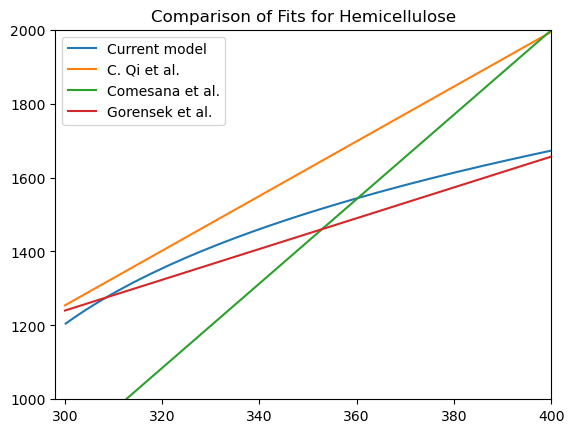

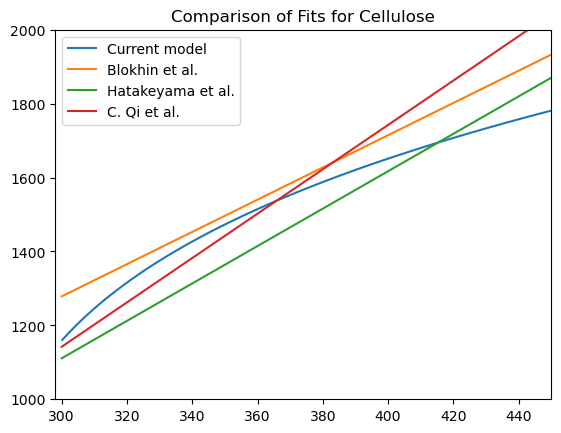

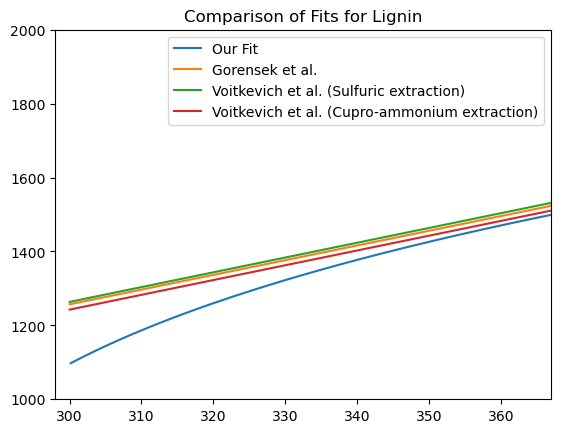

In [29]:
# Compare fits with literature

plt.plot(effective_sensible_temp + 273.15, C_hemicellulose_power_effective*1000,label='Current model')
plt.plot(temp_20K, (7.4*temp_20K) - 965.9, label='C. Qi et al.')
plt.plot(temp_20K, (11.42*temp_20K) - 2569.5,label='Comesana et al.')
plt.plot(temp_20K, (-0.009453 + (0.004165*temp_20K))*1000,label='Gorensek et al.')
plt.xlim([298, 400])
plt.ylim([1000, 2000])
plt.legend()
plt.title('Comparison of Fits for Hemicellulose')
plt.show()

wood_alpha  = 5.06*(10**-3)

plt.plot(effective_sensible_temp + 273.15, C_cellulose_power_effective*1000,label='Current model')
plt.plot(temp_20K, (-0.02951 + (0.00436*temp_20K))*1000,label='Blokhin et al.')
#plt.plot(temp_20K, (-0.1662 + (4.0427*temp_20K)),label='Karimi et al. (Crystalline Cellulose)')
#plt.plot(temp_20K, (-40.72 + (4.4327*temp_20K)),label='Karimi et al. (Amorphouse Cellulose)')
plt.plot(temp_20K, (1.364 + (wood_alpha*(temp_20K-350)))*1000,label='Hatakeyama et al.')
plt.plot(temp_20K, (6*temp_20K) - 657.8,label='C. Qi et al.')
plt.xlim([298, 450])
plt.ylim([1000, 2000])
plt.legend()
plt.title('Comparison of Fits for Cellulose')
plt.show()

plt.plot(effective_sensible_temp + 273.15, C_lignin_power_effective*1000,label='Our Fit')
plt.plot(temp_20K, (0.063517 + (0.0039783*temp_20K))*1000,label='Gorensek et al.')
plt.plot(temp_20K, (0.063517 + (0.004*temp_20K))*1000,label='Voitkevich et al. (Sulfuric extraction)')
plt.plot(temp_20K, (0.0426 + (0.004*temp_20K))*1000,label='Voitkevich et al. (Cupro-ammonium extraction)')
plt.xlim([298, 367])
plt.ylim([1000, 2000])
plt.legend()
plt.title('Comparison of Fits for Lignin')
plt.show()

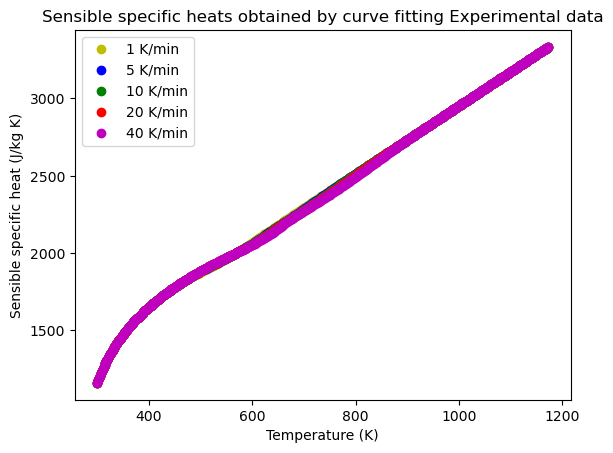

In [30]:
# Obtain sensible specific heats at any given heating rate.

def calculate_sensible_Cp_from_fitting(hr, effective_power_coeffs, char_coeffs, A1, E1, A2, E2, A3, E3):
    
    final_temp = 1173.15
    initial_temp = 300
    
    times_hr = np.linspace(0,((final_temp - initial_temp)*60)/hr,500)
    temp_hr = 300 + ((hr/60)*times_hr)
    temp_celsius = 26.85 + ((hr/60)*times_hr)
    Cp_hemicellulose = (effective_power_coeffs[0]*((temp_celsius)**effective_power_coeffs[1]))*1000
    Cp_cellulose = (effective_power_coeffs[2]*((temp_celsius)**effective_power_coeffs[3]))*1000
    Cp_lignin = (effective_power_coeffs[4]*((temp_celsius)**effective_power_coeffs[5]))*1000
    Cp_char = (char_coeffs[1] + (char_coeffs[0]*(temp_celsius)))*1000 #char
    
    [temp_hr, times_hr, f_hemicellulose, f_cellulose, f_lignin, f_char, fprime_hemicellulose, fprime_cellulose, fprime_lignin] = estimate_mass_fractions(hr, A1, E1, A2, E2, A3, E3)
    Cp_total = (f_cellulose*Cp_cellulose) + (f_hemicellulose*Cp_hemicellulose) + (f_lignin*Cp_lignin) + (f_char*Cp_char) # find total sensible Cp
    Specific_heat_data = pd.DataFrame([])
    Specific_heat_data['Temp (K)'] = temp_hr
    Specific_heat_data['Specific Heat (J/kg K)'] = Cp_total
    Specific_heat_data['Cellulose fraction'] = f_cellulose
    Specific_heat_data['Hemicellulose fraction'] = f_hemicellulose
    Specific_heat_data['Lignin fraction'] = f_lignin
    Specific_heat_data['Char fraction'] = f_char
    
    return [Specific_heat_data,Cp_total, temp_hr, f_hemicellulose, f_cellulose, f_lignin, f_char]

[Specific_heat_data_5K_fit, Cp_5K_fit, temp_5K_fit, f_hemicellulose_5K_fit, f_cellulose_5K_fit, f_lignin_5K_fit, f_char_5K_fit] = calculate_sensible_Cp_from_fitting(5, effective_power_coeffs, char_coeffs, A1, E1, A2, E2, A3, E3) # Cp for 5 K/m/min
[Specific_heat_data_10K_fit, Cp_10K_fit, temp_10K_fit, f_hemicellulose_10K_fit, f_cellulose_10K_fit, f_lignin_10K_fit, f_char_10K_fit] = calculate_sensible_Cp_from_fitting(10, effective_power_coeffs, char_coeffs, A1, E1, A2, E2, A3, E3) # Cp for 10 K/m/min
[Specific_heat_data_20K_fit, Cp_20K_fit, temp_20K_fit, f_hemicellulose_20K_fit, f_cellulose_20K_fit, f_lignin_20K_fit, f_char_20K_fit] = calculate_sensible_Cp_from_fitting(20, effective_power_coeffs, char_coeffs, A1, E1, A2, E2, A3, E3) # for 20 K/min
[Specific_heat_data_40K_fit, Cp_40K_fit, temp_40K_fit, f_hemicellulose_40K_fit, f_cellulose_40K_fit, f_lignin_40K_fit, f_char_40K_fit] = calculate_sensible_Cp_from_fitting(40, effective_power_coeffs, char_coeffs, A1, E1, A2, E2, A3, E3) # for 40 K/min
[Specific_heat_data_1K_fit, Cp_1K_fit, temp_1K_fit, f_hemicellulose_1K_fit, f_cellulose_1K_fit, f_lignin_1K_fit, f_char_1K_fit] = calculate_sensible_Cp_from_fitting(1, effective_power_coeffs, char_coeffs, A1, E1, A2, E2, A3, E3) # for 1 K/min

plt.plot(temp_1K, Cp_1K_fit,'yo',label='1 K/min')
plt.plot(temp_5K, Cp_5K_fit,'bo',label='5 K/min')
plt.plot(temp_10K,Cp_10K_fit,'go',label='10 K/min')
plt.plot(temp_20K,Cp_20K_fit,'ro',label='20 K/min')
plt.plot(temp_40K,Cp_40K_fit,'mo',label='40 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Sensible specific heat (J/kg K)')
plt.title('Sensible specific heats obtained by curve fitting Experimental data')
plt.show()

In [31]:
# write Specific heats

with pd.ExcelWriter('Sensible Specific Heat Updated.xlsx') as writer:
    Specific_heat_data_40K_fit.to_excel(writer,sheet_name='40Kmin')
    Specific_heat_data_20K_fit.to_excel(writer,sheet_name='20Kmin')
    Specific_heat_data_10K_fit.to_excel(writer,sheet_name='10Kmin')
    Specific_heat_data_5K_fit.to_excel(writer,sheet_name='5Kmin')
    Specific_heat_data_1K_fit.to_excel(writer,sheet_name='1Kmin')

Using the kinetic parameters, the volatile fractions emanating from the GC are estimated in the following cells.

In [32]:
# Generate DTG curves for every heating rate being considered, i.e., 1 K/min, 5 K/min, 10 K/min, 20 K/min, 40 K/min

hemicellulose_dtg_1K = -np.gradient(fprime_hemicellulose_1K,times_1K)
cellulose_dtg_1K = -np.gradient(fprime_cellulose_1K,times_1K)
lignin_dtg_1K = -np.gradient(fprime_lignin_1K,times_1K)

hemicellulose_dtg_5K = -np.gradient(fprime_hemicellulose_5K,times_5K)
cellulose_dtg_5K = -np.gradient(fprime_cellulose_5K,times_5K)
lignin_dtg_5K = -np.gradient(fprime_lignin_5K,times_5K)

hemicellulose_dtg_10K = -np.gradient(fprime_hemicellulose_10K,times_10K)
cellulose_dtg_10K = -np.gradient(fprime_cellulose_10K,times_10K)
lignin_dtg_10K = -np.gradient(fprime_lignin_10K,times_10K)

hemicellulose_dtg_20K = -np.gradient(fprime_hemicellulose_20K,times_20K)
cellulose_dtg_20K = -np.gradient(fprime_cellulose_20K,times_20K)
lignin_dtg_20K = -np.gradient(fprime_lignin_20K,times_20K)

hemicellulose_dtg_40K = -np.gradient(fprime_hemicellulose_40K,times_40K)
cellulose_dtg_40K = -np.gradient(fprime_cellulose_40K,times_40K)
lignin_dtg_40K = -np.gradient(fprime_lignin_40K,times_40K)

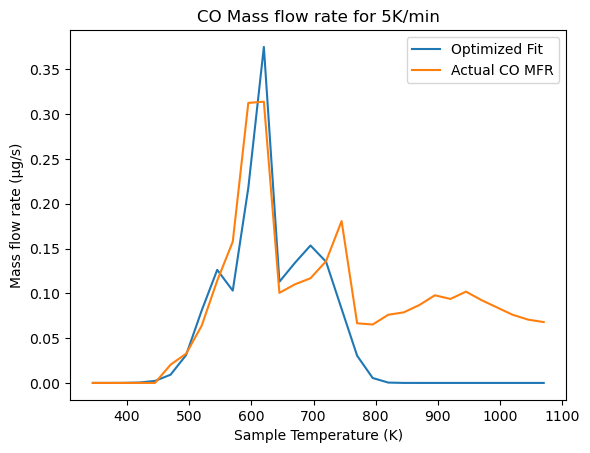

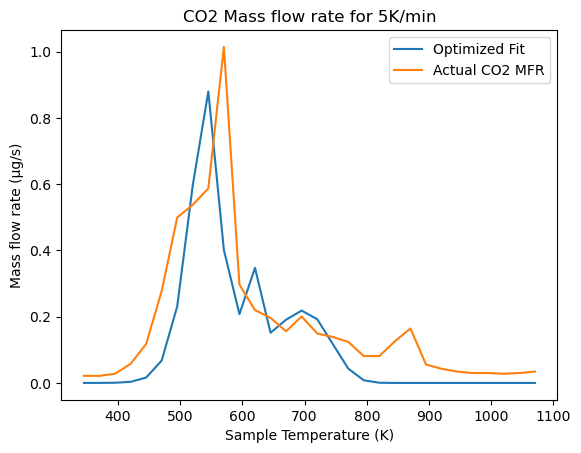

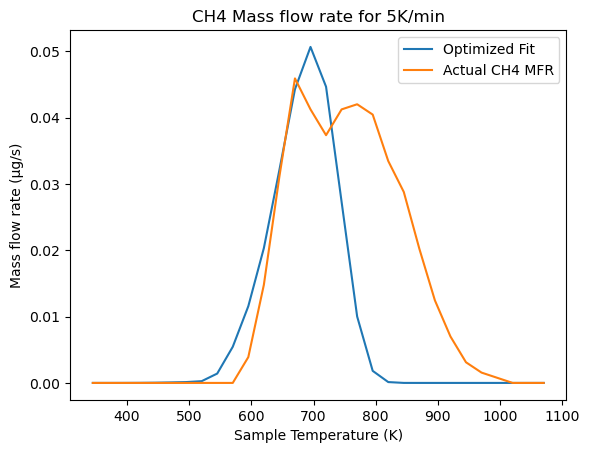

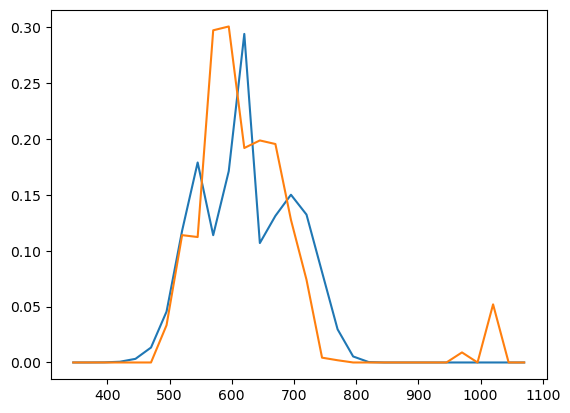

In [33]:
# Use 5 K/min as the training heating rate. Include THC

initial_mass_5Kmin = 15.053 * 1000 # micrograms
species_mass_flow_rates = pd.read_excel('Yields GC 5K_min 04_14_24.xlsx')
#species_mass_flow_rates = pd.read_excel('Yields as Methane GC 5K_min 04_14_24.xlsx')

temperature_GC_5K = species_mass_flow_rates['GCTemp'].values + 273.15
temperature_GC_5K = temperature_GC_5K[temperature_GC_5K<1073.15]
CH4_mfr_5K = species_mass_flow_rates['CH4_MFR']
CH4_mfr_5K = CH4_mfr_5K[0:len(temperature_GC_5K)]
CO_mfr_5K = species_mass_flow_rates['CO_MFR']
CO_mfr_5K = CO_mfr_5K[0:len(temperature_GC_5K)]
CO2_mfr_5K = species_mass_flow_rates['CO2_MFR']
CO2_mfr_5K = CO2_mfr_5K[0:len(temperature_GC_5K)]
C3H8_mfr_5K = species_mass_flow_rates['THCC3H8_MFR']
C3H8_mfr_5K = C3H8_mfr_5K[0:len(temperature_GC_5K)]
H2_mfr_5K = species_mass_flow_rates['H2_MFR']
H2_mfr_5K = H2_mfr_5K[0:len(temperature_GC_5K)]
# Interpolate the pseudo-component DTGs to the GC range
hemicellulose_5K_GC = np.interp(temperature_GC_5K,temp_5K,hemicellulose_dtg_5K)*initial_mass_5Kmin
cellulose_5K_GC = np.interp(temperature_GC_5K,temp_5K,cellulose_dtg_5K)*initial_mass_5Kmin
lignin_5K_GC = np.interp(temperature_GC_5K,temp_5K,lignin_dtg_5K)*initial_mass_5Kmin

#CO_mfr_1K_interp = np.interp(temperature_GC_5K, temperature_GC, CO_mfr)
#hemicellulose_1K_GC_interp = np.interp(temperature_GC_5K, temperature_GC, hemicellulose_1K_GC)
#cellulose_1K_GC_interp = np.interp(temperature_GC_5K, temperature_GC, cellulose_1K_GC)
#lignin_1K_GC_interp = np.interp(temperature_GC_5K, temperature_GC, lignin_1K_GC)

# Least squares minimization and training

x0_co = [0, 0.032, 0]

def co_min(x):
    return (CO_mfr_5K - ((x[0]*hemicellulose_5K_GC) + (x[1]*cellulose_5K_GC) + (x[2]*lignin_5K_GC)))

co_solution = optimize.least_squares(co_min, x0_co)
coeffs_co_THC = co_solution.x
plt.plot(temperature_GC_5K,((coeffs_co_THC[0]*hemicellulose_5K_GC) + (coeffs_co_THC[1]*cellulose_5K_GC) + (coeffs_co_THC[2]*lignin_5K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC_5K,CO_mfr_5K,label='Actual CO MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CO Mass flow rate for 5K/min')
plt.show()


x0_co2 = [0, 0.0619435, 0]

def co2_min(x):
    return (CO2_mfr_5K - ((x[0]*hemicellulose_5K_GC) + (x[1]*cellulose_5K_GC) + (x[2]*lignin_5K_GC)))

co2_solution = optimize.least_squares(co2_min, x0_co2)
coeffs_co2_THC = co2_solution.x

plt.plot(temperature_GC_5K,((coeffs_co2_THC[0]*hemicellulose_5K_GC) + (coeffs_co2_THC[1]*cellulose_5K_GC) + (coeffs_co2_THC[2]*lignin_5K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC_5K,CO2_mfr_5K,label='Actual CO2 MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CO2 Mass flow rate for 5K/min')
plt.show()

x0_ch4 = [0, 0, 0.0166827]

def ch4_min(x):
   return (CH4_mfr_5K - ((abs(x[0])*hemicellulose_5K_GC) + (abs(x[1])*cellulose_5K_GC) + (abs(x[2])*lignin_5K_GC)))


ch4_solution = optimize.least_squares(ch4_min, x0_ch4)
coeffs_ch4_THC = ch4_solution.x

plt.plot(temperature_GC_5K,((coeffs_ch4_THC[0]*hemicellulose_5K_GC) + (coeffs_ch4_THC[1]*cellulose_5K_GC) + (coeffs_ch4_THC[2]*lignin_5K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC_5K,CH4_mfr_5K,label='Actual CH4 MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CH4 Mass flow rate for 5K/min')
plt.show()

x0_c3h8 = [0, 0,0.1277570113700]
def c3h8_min(x):
    return   (C3H8_mfr_5K - ((x[0]*hemicellulose_5K_GC) + (x[1]*cellulose_5K_GC) + (x[2]*lignin_5K_GC)))

c3h8_solution = optimize.least_squares(c3h8_min, x0_c3h8)
coeffs_c3h8_THC = c3h8_solution.x

plt.plot(temperature_GC_5K,((coeffs_c3h8_THC[0]*hemicellulose_5K_GC) + (coeffs_c3h8_THC[1]*cellulose_5K_GC) + (coeffs_c3h8_THC[2]*lignin_5K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC_5K,C3H8_mfr_5K,label='Actual Ethane MFR')



In [34]:
# Outpute volatile fractions

print('The volatile fractions for CO are', coeffs_co_THC)
print('The volatile fractions for CO2 are', coeffs_co2_THC)
print('The volatile fractions for CH4 are', coeffs_ch4_THC)
print('The volatile fractions for THC are', coeffs_c3h8_THC)

The volatile fractions for CO are [0.02169184 0.03364193 0.09888872]
The volatile fractions for CO2 are [0.16872213 0.02787658 0.14077718]
The volatile fractions for CH4 are [-2.93165807e-04  2.70214549e-10  3.26547384e-02]
The volatile fractions for THC are [0.03236546 0.02507261 0.09670486]


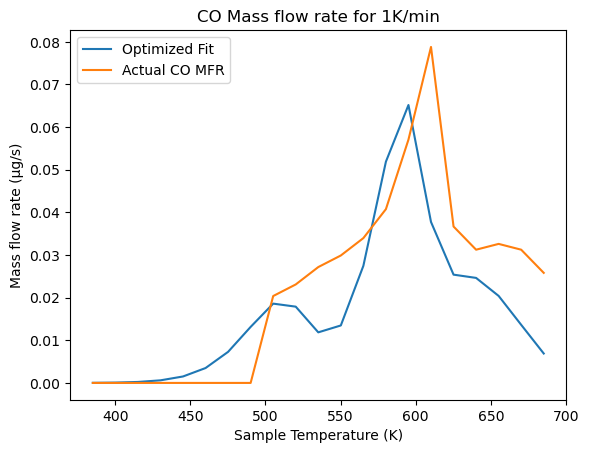

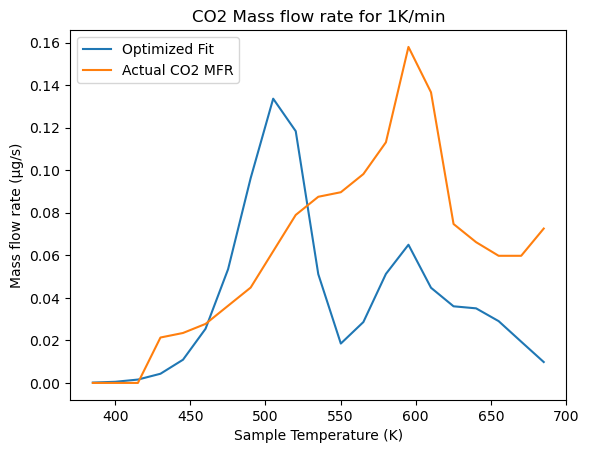

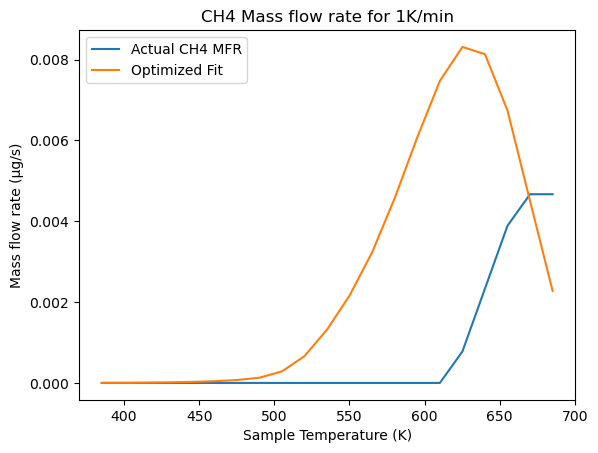

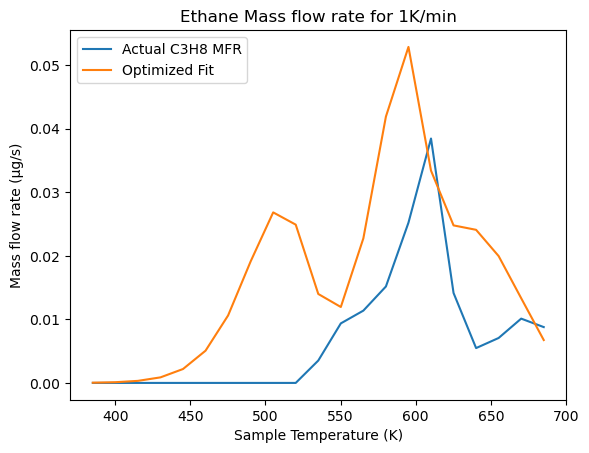

In [35]:
# Verify the THC approach on 1 K/min. 

initial_mass_1Kmin = 10.3*1000 # micro grams

species_mass_flow_rates = pd.read_excel('Yields GC 1K_min 03_26_24.xlsx')
#species_mass_flow_rates = pd.read_excel('Yields as Methane GC 1K_min 03_26_24.xlsx')
temperature_GC = species_mass_flow_rates['Temperature'].values + 273.15
temperature_GC = temperature_GC[temperature_GC<700]
CH4_mfr = species_mass_flow_rates['CH4_MFR']
CH4_mfr = CH4_mfr[0:len(temperature_GC)]
CO_mfr = species_mass_flow_rates['CO_MFR']
CO_mfr = CO_mfr[0:len(temperature_GC)]
CO2_mfr = species_mass_flow_rates['CO2_MFR']
CO2_mfr = CO2_mfr[0:len(temperature_GC)]
C3H8_mfr = species_mass_flow_rates['THCC3H8_MFR']
C3H8_mfr = C3H8_mfr[0:len(temperature_GC)]
hemicellulose_1K_GC = np.interp(temperature_GC,temp_1K,hemicellulose_dtg_1K)*initial_mass_1Kmin
cellulose_1K_GC = np.interp(temperature_GC,temp_1K,cellulose_dtg_1K)*initial_mass_1Kmin
lignin_1K_GC = np.interp(temperature_GC,temp_1K,lignin_dtg_1K)*initial_mass_1Kmin

# Verify the volatile fractions as estimated by 5 K/min training data

plt.plot(temperature_GC,((coeffs_co_THC[0]*hemicellulose_1K_GC) + (coeffs_co_THC[1]*cellulose_1K_GC) + (coeffs_co_THC[2]*lignin_1K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC,CO_mfr,label='Actual CO MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CO Mass flow rate for 1K/min')
plt.show()

plt.plot(temperature_GC,((coeffs_co2_THC[0]*hemicellulose_1K_GC) + (coeffs_co2_THC[1]*cellulose_1K_GC) + (coeffs_co2_THC[2]*lignin_1K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC,CO2_mfr,label='Actual CO2 MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CO2 Mass flow rate for 1K/min')
plt.show()

plt.plot(temperature_GC,CH4_mfr,label='Actual CH4 MFR')
plt.plot(temperature_GC,((coeffs_ch4_THC[0]*hemicellulose_1K_GC) + (coeffs_ch4_THC[1]*cellulose_1K_GC) + (coeffs_ch4_THC[2]*lignin_1K_GC)),label = 'Optimized Fit')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CH4 Mass flow rate for 1K/min')
#plt.ylim([0, 0.01])
plt.show()

plt.plot(temperature_GC,C3H8_mfr,label='Actual C3H8 MFR')
plt.plot(temperature_GC,((coeffs_c3h8_THC[0]*hemicellulose_1K_GC) + (coeffs_c3h8_THC[1]*cellulose_1K_GC) + (coeffs_c3h8_THC[2]*lignin_1K_GC)),label = 'Optimized Fit')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('Ethane Mass flow rate for 1K/min')
plt.show()

# Write data to excel 

Volatile_fractions_5K = pd.DataFrame([])
Volatile_fractions_1K = pd.DataFrame([])
Volatile_fractions_model_5K = pd.DataFrame([])
Volatile_fractions_model_1K = pd.DataFrame([])
Volatile_fractions_1K['Temperature (K)'] = temperature_GC
Volatile_fractions_model_1K['Model Temperature (K)'] = temp_1K
Volatile_fractions_1K['Exp CO MFR (micro grams/s)'] = CO_mfr
Volatile_fractions_model_1K['Model CO MFR (micro grams/s)'] = initial_mass_1Kmin*((coeffs_co_THC[0]*hemicellulose_dtg_1K) + (coeffs_co_THC[1]*cellulose_dtg_1K) + (coeffs_co_THC[2]*lignin_dtg_1K))
Volatile_fractions_1K['Exp CO2 MFR (micro grams/s)'] = CO2_mfr
Volatile_fractions_model_1K['Model CO2 MFR (micro grams/s)'] = initial_mass_1Kmin*((coeffs_co2_THC[0]*hemicellulose_dtg_1K) + (coeffs_co2_THC[1]*cellulose_dtg_1K) + (coeffs_co2_THC[2]*lignin_dtg_1K))
Volatile_fractions_1K['Exp CH4 MFR (micro grams/s)'] = CH4_mfr
Volatile_fractions_model_1K['Model CH4 MFR (micro grams/s)'] = initial_mass_1Kmin*((coeffs_ch4_THC[0]*hemicellulose_dtg_1K) + (coeffs_ch4_THC[1]*cellulose_dtg_1K) + (coeffs_ch4_THC[2]*lignin_dtg_1K))
Volatile_fractions_1K['Exp THC MFR (micro grams/s)'] = C3H8_mfr
Volatile_fractions_model_1K['Model THC MFR (micro grams/s)'] = initial_mass_1Kmin*((coeffs_c3h8_THC[0]*hemicellulose_dtg_1K) + (coeffs_c3h8_THC[1]*cellulose_dtg_1K) + (coeffs_c3h8_THC[2]*lignin_dtg_1K))

Volatile_fractions_5K['Temperature (K)'] = temperature_GC_5K
Volatile_fractions_model_5K['Model Temperature (K)'] = temp_5K
Volatile_fractions_5K['Exp CO MFR (micro grams/s)'] = CO_mfr_5K
Volatile_fractions_model_5K['Model CO MFR (micro grams/s)'] = initial_mass_5Kmin*((coeffs_co_THC[0]*hemicellulose_dtg_5K) + (coeffs_co_THC[1]*cellulose_dtg_5K) + (coeffs_co_THC[2]*lignin_dtg_5K))
Volatile_fractions_5K['Exp CO2 MFR (micro grams/s)'] = CO2_mfr_5K
Volatile_fractions_model_5K['Model CO2 MFR (micro grams/s)'] = initial_mass_5Kmin*((coeffs_co2_THC[0]*hemicellulose_dtg_5K) + (coeffs_co2_THC[1]*cellulose_dtg_5K) + (coeffs_co2_THC[2]*lignin_dtg_5K))
Volatile_fractions_5K['Exp CH4 MFR (micro grams/s)'] = CH4_mfr_5K
Volatile_fractions_model_5K['Model CH4 MFR (micro grams/s)'] = initial_mass_5Kmin*((coeffs_ch4_THC[0]*hemicellulose_dtg_5K) + (coeffs_ch4_THC[1]*cellulose_dtg_5K) + (coeffs_ch4_THC[2]*lignin_dtg_5K))
Volatile_fractions_5K['Exp THC MFR (micro grams/s)'] = C3H8_mfr_5K
Volatile_fractions_model_5K['Model THC MFR (micro grams/s)'] = initial_mass_5Kmin*((coeffs_c3h8_THC[0]*hemicellulose_dtg_5K) + (coeffs_c3h8_THC[1]*cellulose_dtg_5K) + (coeffs_c3h8_THC[2]*lignin_dtg_5K))

with pd.ExcelWriter('Volatile fraction modeling data.xlsx') as writer:
    Volatile_fractions_1K.to_excel(writer,sheet_name='1Kmin')
    Volatile_fractions_5K.to_excel(writer,sheet_name='5Kmin')
    Volatile_fractions_model_1K.to_excel(writer,sheet_name='1Kmin Model')
    Volatile_fractions_model_5K.to_excel(writer,sheet_name='5Kmin Model')

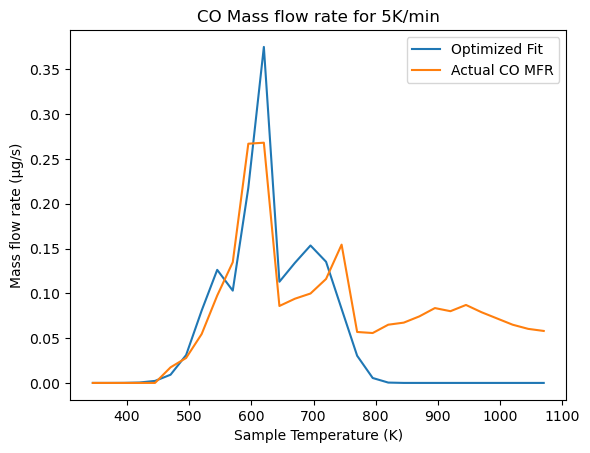

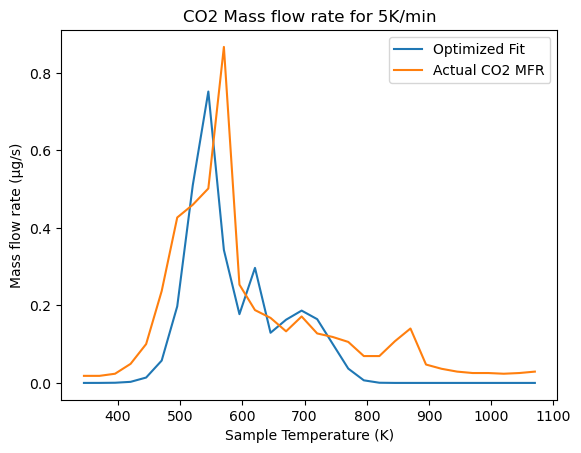

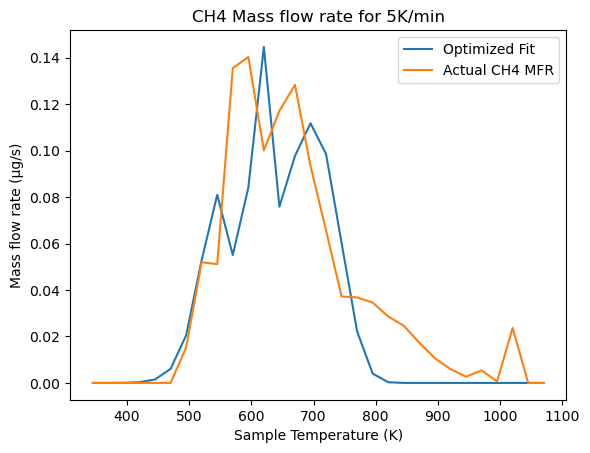

In [36]:
# Use 5 K/min as the training heating rate. Exclude THC. THC as Methane

# Take CO coeffs as CO THC coeffs itself. CO THC fits better

initial_mass_5Kmin = 15.053 * 1000 # micrograms
#species_mass_flow_rates = pd.read_excel('Yields GC 5K_min 04_14_24.xlsx')
species_mass_flow_rates = pd.read_excel('Yields as Methane GC 5K_min 04_14_24.xlsx')

temperature_GC_5K = species_mass_flow_rates['GCTemp'].values + 273.15
temperature_GC_5K = temperature_GC_5K[temperature_GC_5K<1073.15]
CH4_mfr_5K = species_mass_flow_rates['CH4_MFR']
CH4_mfr_5K = CH4_mfr_5K[0:len(temperature_GC_5K)]
CO_mfr_5K = species_mass_flow_rates['CO_MFR']
CO_mfr_5K = CO_mfr_5K[0:len(temperature_GC_5K)]
CO2_mfr_5K = species_mass_flow_rates['CO2_MFR']
CO2_mfr_5K = CO2_mfr_5K[0:len(temperature_GC_5K)]
H2_mfr_5K = species_mass_flow_rates['H2_MFR']
H2_mfr_5K = H2_mfr_5K[0:len(temperature_GC_5K)]
# Interpolate the pseudo-component DTGs to the GC range
hemicellulose_5K_GC = np.interp(temperature_GC_5K,temp_5K,hemicellulose_dtg_5K)*initial_mass_5Kmin
cellulose_5K_GC = np.interp(temperature_GC_5K,temp_5K,cellulose_dtg_5K)*initial_mass_5Kmin
lignin_5K_GC = np.interp(temperature_GC_5K,temp_5K,lignin_dtg_5K)*initial_mass_5Kmin

#CO_mfr_1K_interp = np.interp(temperature_GC_5K, temperature_GC, CO_mfr)
#hemicellulose_1K_GC_interp = np.interp(temperature_GC_5K, temperature_GC, hemicellulose_1K_GC)
#cellulose_1K_GC_interp = np.interp(temperature_GC_5K, temperature_GC, cellulose_1K_GC)
#lignin_1K_GC_interp = np.interp(temperature_GC_5K, temperature_GC, lignin_1K_GC)

# Least squares minimization and training

x0_co = [0, 0.032, 0]

def co_min(x):
    return (CO_mfr_5K - ((x[0]*hemicellulose_5K_GC) + (x[1]*cellulose_5K_GC) + (x[2]*lignin_5K_GC)))

co_solution = optimize.least_squares(co_min, x0_co)
coeffs_co = co_solution.x
plt.plot(temperature_GC_5K,((coeffs_co_THC[0]*hemicellulose_5K_GC) + (coeffs_co_THC[1]*cellulose_5K_GC) + (coeffs_co_THC[2]*lignin_5K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC_5K,CO_mfr_5K,label='Actual CO MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CO Mass flow rate for 5K/min')
plt.show()


x0_co2 = [0, 0.0619435, 0]

def co2_min(x):
    return (CO2_mfr_5K - ((x[0]*hemicellulose_5K_GC) + (x[1]*cellulose_5K_GC) + (x[2]*lignin_5K_GC)))

co2_solution = optimize.least_squares(co2_min, x0_co2)
coeffs_co2 = co2_solution.x

plt.plot(temperature_GC_5K,((coeffs_co2[0]*hemicellulose_5K_GC) + (coeffs_co2[1]*cellulose_5K_GC) + (coeffs_co2[2]*lignin_5K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC_5K,CO2_mfr_5K,label='Actual CO2 MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CO2 Mass flow rate for 5K/min')
plt.show()

x0_ch4 = [0, 0, 0.0166827]

def ch4_min(x):
   return (CH4_mfr_5K - ((x[0]*hemicellulose_5K_GC) + (x[1]*cellulose_5K_GC) + (x[2]*lignin_5K_GC)))


ch4_solution = optimize.least_squares(ch4_min, x0_ch4)
coeffs_ch4 = ch4_solution.x

plt.plot(temperature_GC_5K,((coeffs_ch4[0]*hemicellulose_5K_GC) + (coeffs_ch4[1]*cellulose_5K_GC) + (coeffs_ch4[2]*lignin_5K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC_5K,CH4_mfr_5K,label='Actual CH4 MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CH4 Mass flow rate for 5K/min')
plt.show()


In [37]:
# Outpute volatile fractions considering THC as Methane

print('The volatile fractions for CO (considering THC as Methane) are', coeffs_co_THC)
print('The volatile fractions for CO2 (considering THC as Methane) are', coeffs_co2)
print('The volatile fractions for CH4 (considering THC as Methane) are', coeffs_ch4)
print('The overall percentages (considering THC as Methane) are', coeffs_co_THC + coeffs_co2 + coeffs_ch4)

The volatile fractions for CO (considering THC as Methane) are [0.02169184 0.03364193 0.09888872]
The volatile fractions for CO2 (considering THC as Methane) are [0.14415795 0.02381563 0.12026432]
The volatile fractions for CH4 (considering THC as Methane) are [0.01418556 0.01070559 0.07202992]
The overall percentages (considering THC as Methane) are [0.18003535 0.06816314 0.29118296]


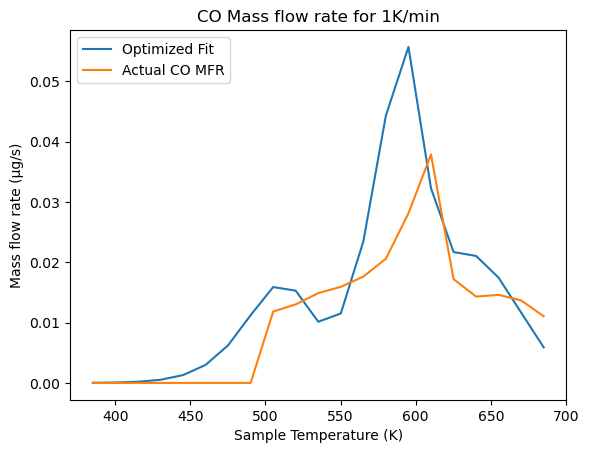

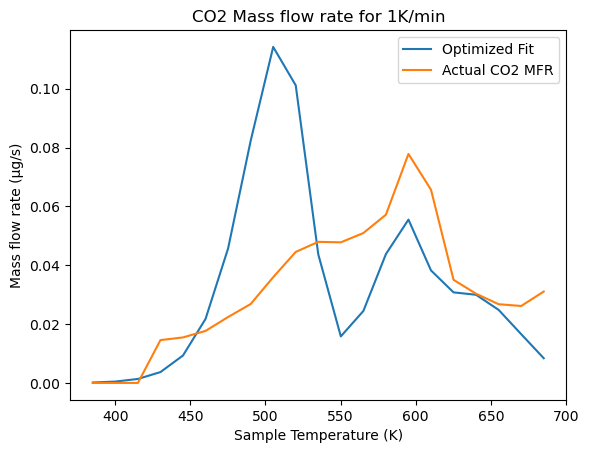

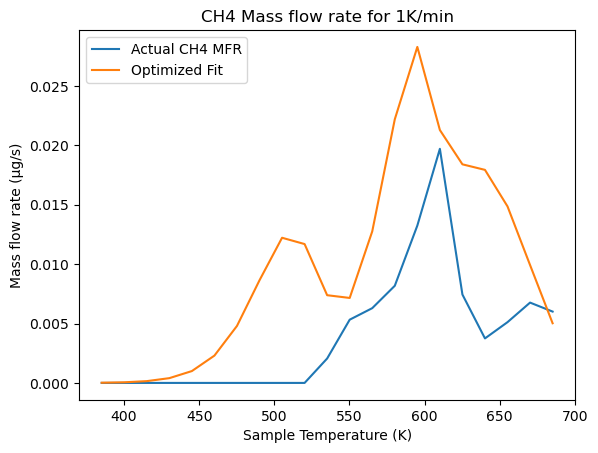

In [38]:
# 1 K/min
# THC as Methane
# Solve this for now
initial_mass_1Kmin = 10.3*1000 # micro grams

species_mass_flow_rates = pd.read_excel('Yields as Methane GC 1K_min 03_26_24.xlsx')
temperature_GC = species_mass_flow_rates['Temperature'].values + 273.15
temperature_GC = temperature_GC[temperature_GC<700]
CH4_mfr = species_mass_flow_rates['CH4_MFR']
CH4_mfr = CH4_mfr[0:len(temperature_GC)]
CO_mfr = species_mass_flow_rates['CO_MFR']
CO_mfr = CO_mfr[0:len(temperature_GC)]
CO2_mfr = species_mass_flow_rates['CO2_MFR']
CO2_mfr = CO2_mfr[0:len(temperature_GC)]

hemicellulose_1K_GC = np.interp(temperature_GC,temp_1K,hemicellulose_dtg_1K)*initial_mass_1Kmin
cellulose_1K_GC = np.interp(temperature_GC,temp_1K,cellulose_dtg_1K)*initial_mass_1Kmin
lignin_1K_GC = np.interp(temperature_GC,temp_1K,lignin_dtg_1K)*initial_mass_1Kmin

plt.plot(temperature_GC,((coeffs_co[0]*hemicellulose_1K_GC) + (coeffs_co[1]*cellulose_1K_GC) + (coeffs_co[2]*lignin_1K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC,CO_mfr,label='Actual CO MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CO Mass flow rate for 1K/min')
plt.show()

plt.plot(temperature_GC,((coeffs_co2[0]*hemicellulose_1K_GC) + (coeffs_co2[1]*cellulose_1K_GC) + (coeffs_co2[2]*lignin_1K_GC)),label = 'Optimized Fit')
#plt.plot(temperature_GC,((0.10044986*hemicellulose_1K_GC) + (0.03622538*cellulose_1K_GC) + (0.15696738*lignin_1K_GC)),label = 'Optimized Fit')
plt.plot(temperature_GC,CO2_mfr,label='Actual CO2 MFR')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CO2 Mass flow rate for 1K/min')
plt.show()

#coeffs_ch4 = [0, 0, 0.0166827*4]
#coeffs_ch4 = [0.00789262, 0.00774723, 0.06116584]
plt.plot(temperature_GC,CH4_mfr,label='Actual CH4 MFR')
plt.plot(temperature_GC,((coeffs_ch4[0]*hemicellulose_1K_GC) + (coeffs_ch4[1]*cellulose_1K_GC) + (coeffs_ch4[2]*lignin_1K_GC)),label = 'Optimized Fit')
plt.legend()
plt.xlabel('Sample Temperature (K)')
plt.ylabel('Mass flow rate (μg/s)')
plt.title('CH4 Mass flow rate for 1K/min')
plt.show()

In [39]:
# Export the no THC mass flow rates predicted by GC

GC_mfr_1Kmin = pd.DataFrame([])
GC_mfr_5Kmin = pd.DataFrame([])
GC_mfr_sim_5Kmin = pd.DataFrame([])
GC_mfr_sim_1Kmin = pd.DataFrame([])

GC_mfr_1Kmin['Temperature (K)'] = temperature_GC
GC_mfr_1Kmin['CO mfr (mu g/s)'] = CO_mfr
GC_mfr_1Kmin['CO2 mfr (mu g/s)'] = CO2_mfr
GC_mfr_1Kmin['CH4 mfr (mu g/s)'] = CH4_mfr

GC_mfr_5Kmin['Temperature (K)'] = temperature_GC_5K
GC_mfr_5Kmin['CO mfr (mu g/s)'] = CO_mfr_5K
GC_mfr_5Kmin['CO2 mfr (mu g/s)'] = CO2_mfr_5K
GC_mfr_5Kmin['CH4 mfr (mu g/s)'] = CH4_mfr_5K

GC_mfr_sim_1Kmin['Temperature (K)'] = temp_1K
GC_mfr_sim_1Kmin['CO mfr (mu g/s)'] = ((coeffs_co[0]*hemicellulose_dtg_1K) + (coeffs_co[1]*cellulose_dtg_1K) + (coeffs_co[2]*lignin_dtg_1K))*initial_mass_1Kmin
GC_mfr_sim_1Kmin['CO2 mfr (mu g/s)'] = ((coeffs_co2[0]*hemicellulose_dtg_1K) + (coeffs_co2[1]*cellulose_dtg_1K) + (coeffs_co2[2]*lignin_dtg_1K))*initial_mass_1Kmin
GC_mfr_sim_1Kmin['CH4 mfr (mu g/s)'] = ((coeffs_ch4[0]*hemicellulose_dtg_1K) + (coeffs_ch4[1]*cellulose_dtg_1K) + (coeffs_ch4[2]*lignin_dtg_1K))*initial_mass_1Kmin

GC_mfr_sim_5Kmin['Temperature (K)'] = temp_5K
GC_mfr_sim_5Kmin['CO mfr (mu g/s)'] = ((coeffs_co[0]*hemicellulose_dtg_5K) + (coeffs_co[1]*cellulose_dtg_5K) + (coeffs_co[2]*lignin_dtg_5K))*initial_mass_5Kmin
GC_mfr_sim_5Kmin['CO2 mfr (mu g/s)'] = ((coeffs_co2[0]*hemicellulose_dtg_5K) + (coeffs_co2[1]*cellulose_dtg_5K) + (coeffs_co2[2]*lignin_dtg_5K))*initial_mass_5Kmin
GC_mfr_sim_5Kmin['CH4 mfr (mu g/s)'] = ((coeffs_ch4[0]*hemicellulose_dtg_5K) + (coeffs_ch4[1]*cellulose_dtg_5K) + (coeffs_ch4[2]*lignin_dtg_5K))*initial_mass_5Kmin

with pd.ExcelWriter('GC mass flow rates no THC.xlsx') as writer:
    GC_mfr_1Kmin.to_excel(writer,sheet_name='1 Kmin Exp')
    GC_mfr_sim_1Kmin.to_excel(writer,sheet_name='1 Kmin')
    GC_mfr_5Kmin.to_excel(writer,sheet_name='5 Kmin Exp')
    GC_mfr_sim_5Kmin.to_excel(writer,sheet_name='5 Kmin')

Calculate the sensitivities for the raw DSC voltages

In [40]:
sapphire_cp = pd.read_excel('Sapphire Cp.xlsx')
sapphire_dsc_20Kmin = pd.read_excel('Sapphiredata.xlsx',sheet_name='20Kmin new')
sapphire_dsc_10Kmin = pd.read_excel('Sapphiredata.xlsx',sheet_name='10Kmin')
sapphire_dsc_5Kmin = pd.read_excel('Sapphiredata.xlsx',sheet_name='5Kmin')

sapphire_temp_20Kmin = sapphire_dsc_20Kmin['Temp °C'].values
sapphire_dsc_values_20Kmin = sapphire_dsc_20Kmin['DSC/(uV/mg)'].values
sapphire_temp_10Kmin = sapphire_dsc_10Kmin['Temp °C'].values
sapphire_dsc_values_10Kmin = sapphire_dsc_10Kmin['DSC/(uV/mg)'].values
sapphire_temp_5Kmin = sapphire_dsc_5Kmin['Temp °C'].values
sapphire_dsc_values_5Kmin = sapphire_dsc_5Kmin['DSC/(uV/mg)'].values

cp_temp = sapphire_cp['Temp Celsius'].values
cp_values = sapphire_cp['Cp (J/(g K))'].values

cp_values_20Kmin = np.interp(sapphire_temp_20Kmin, cp_temp, cp_values)
cp_values_10Kmin = np.interp(sapphire_temp_10Kmin, cp_temp, cp_values)
cp_values_5Kmin = np.interp(sapphire_temp_5Kmin, cp_temp, cp_values)

sensitivities_recalculated_20Kmin = (cp_values_20Kmin*(20/60))/sapphire_dsc_values_20Kmin
sensitivities_recalculated_10Kmin = (cp_values_10Kmin*(10/60))/sapphire_dsc_values_10Kmin
sensitivities_recalculated_5Kmin = (cp_values_5Kmin*(5/60))/sapphire_dsc_values_5Kmin

sensitivities_20K = pd.DataFrame([])
sensitivities_10K = pd.DataFrame([])
sensitivities_5K = pd.DataFrame([])

sensitivities_20K['Temp (Celsius)'] = sapphire_temp_20Kmin
sensitivities_20K['Sensitivity (mW/\mu V)'] = sensitivities_recalculated_20Kmin
sensitivities_10K['Temp (Celsius)'] = sapphire_temp_10Kmin
sensitivities_10K['Sensitivity (mW/\mu V)'] = sensitivities_recalculated_10Kmin
sensitivities_5K['Temp (Celsius)'] = sapphire_temp_5Kmin
sensitivities_5K['Sensitivity (mW/\mu V)'] = sensitivities_recalculated_5Kmin

with pd.ExcelWriter('Sensitivities calculated.xlsx') as writer:
    sensitivities_20K.to_excel(writer,sheet_name='20Kmin')
    sensitivities_10K.to_excel(writer,sheet_name='10Kmin')
    sensitivities_5K.to_excel(writer,sheet_name='5Kmin')

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\3095286246.py:29: SyntaxWarning: invalid escape sequence '\m'
  sensitivities_20K['Sensitivity (mW/\mu V)'] = sensitivities_recalculated_20Kmin
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\3095286246.py:31: SyntaxWarning: invalid escape sequence '\m'
  sensitivities_10K['Sensitivity (mW/\mu V)'] = sensitivities_recalculated_10Kmin
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\3095286246.py:33: SyntaxWarning: invalid escape sequence '\m'
  sensitivities_5K['Sensitivity (mW/\mu V)'] = sensitivities_recalculated_5Kmin
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\3095286246.py:20: RuntimeWarning: divide by zero encount

Correct for the sensitivities in DSC heat flow data and obtain the apparent specific heats for the heating rates

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\2126767907.py:23: SyntaxWarning: invalid escape sequence '\m'
  sensitivity_5K = sensitivites_5K['Sensitivity (mW/\mu V)'].values
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\2126767907.py:24: SyntaxWarning: invalid escape sequence '\m'
  sensitivity_10K = sensitivites_10K['Sensitivity (mW/\mu V)'].values
C:\Users\shrikar\AppData\Local\Temp\ipykernel_21704\2126767907.py:25: SyntaxWarning: invalid escape sequence '\m'
  sensitivity_20K = sensitivites_20K['Sensitivity (mW/\mu V)'].values


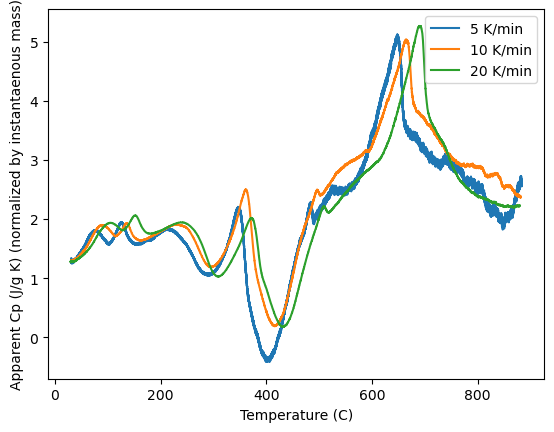

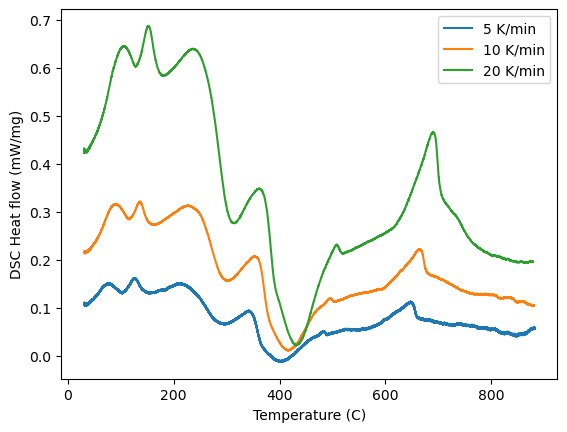

In [41]:
# Correct for sensitivities by importing DSC heat flow data

# Use the calculated sensitivities in the excel workseet in the Jupyter notebook files

sawdust_DSC_5K = pd.read_excel('SawdustDSCdata_raw.xlsx',sheet_name='5Kmin') # import the raw DSC signals from the Jupyter notebook folder
sawdust_DSC_10K = pd.read_excel('SawdustDSCdata_raw.xlsx',sheet_name='10Kmin')
sawdust_DSC_20K = pd.read_excel('SawdustDSCdata_raw.xlsx',sheet_name='20Kmin new')
temp_5K_sawdust = sawdust_DSC_5K['Temp °C'].values
DSC_5K_sawdust = sawdust_DSC_5K['DSC/(uV/mg)'].values
temp_10K_sawdust = sawdust_DSC_10K['Temp °C'].values
DSC_10K_sawdust = sawdust_DSC_10K['DSC/(uV/mg)'].values
temp_20K_sawdust = sawdust_DSC_20K['Temp °C'].values
DSC_20K_sawdust = sawdust_DSC_20K['DSC/(uV/mg)'].values

sensitivites_5K = pd.read_excel('Sensitivities calculated.xlsx',sheet_name='5Kmin') # import sensitivities
sensitivites_10K = pd.read_excel('Sensitivities calculated.xlsx',sheet_name='10Kmin')
sensitivites_20K = pd.read_excel('Sensitivities calculated.xlsx',sheet_name='20Kmin')

temp_5K_sensitivities = sensitivites_5K['Temp (Celsius)'].values
temp_10K_sensitivities = sensitivites_10K['Temp (Celsius)'].values
temp_20K_sensitivities = sensitivites_20K['Temp (Celsius)'].values

sensitivity_5K = sensitivites_5K['Sensitivity (mW/\mu V)'].values
sensitivity_10K = sensitivites_10K['Sensitivity (mW/\mu V)'].values
sensitivity_20K = sensitivites_20K['Sensitivity (mW/\mu V)'].values

# Interpolate the DSC values onto the sensitivities

sensitivity_5K_interp = np.interp(temp_5K_sawdust, temp_5K_sensitivities, sensitivity_5K)
sensitivity_10K_interp = np.interp(temp_10K_sawdust, temp_10K_sensitivities, sensitivity_10K)
sensitivity_20K_interp = np.interp(temp_20K_sawdust, temp_20K_sensitivities, sensitivity_20K)

# Interpolate the mass fractions onto the sensitivities
fres = 0.265
f_5K = fprime_hemicellulose_5K + fprime_cellulose_5K + fprime_lignin_5K + fres
f_10K = fprime_hemicellulose_10K + fprime_cellulose_10K + fprime_lignin_10K + fres
f_20K = fprime_hemicellulose_20K + fprime_cellulose_20K + fprime_lignin_20K + fres

f_5K_dsc_interp = np.interp(temp_5K_sawdust, temp_5K - 273.15, f_5K)
f_10K_dsc_interp = np.interp(temp_10K_sawdust, temp_10K - 273.15, f_10K)
f_20K_dsc_interp = np.interp(temp_20K_sawdust, temp_20K - 273.15, f_20K)

# Cut off the initial transient drops

sensitivity_5K_final = sensitivity_5K_interp[476:]
sensitivity_10K_final = sensitivity_10K_interp[369:]
sensitivity_20K_final = sensitivity_20K_interp[473:]

DSC_5K_final = DSC_5K_sawdust[476:]*sensitivity_5K_final 
DSC_10K_final = DSC_10K_sawdust[369:]*sensitivity_10K_final
DSC_20K_final = DSC_20K_sawdust[473:]*sensitivity_20K_final

temp_5K_DSC_final = temp_5K_sawdust[476:]
temp_10K_DSC_final = temp_10K_sawdust[369:]
temp_20K_DSC_final = temp_20K_sawdust[473:]

f_5K_dsc_interp_final = f_5K_dsc_interp[476:]
f_10K_dsc_interp_final = f_10K_dsc_interp[369:]
f_20K_dsc_interp_final = f_20K_dsc_interp[473:]

# calculate apparent specific heats 

C_apparent_5K = (DSC_5K_final*60)/(5*f_5K_dsc_interp_final)
C_apparent_10K = (DSC_10K_final*60)/(10*f_10K_dsc_interp_final)
C_apparent_20K = (DSC_20K_final*60)/(20*f_20K_dsc_interp_final)

# plot the apparent specific heats

plt.plot(temp_5K_DSC_final, C_apparent_5K,label='5 K/min')
plt.plot(temp_10K_DSC_final, C_apparent_10K,label='10 K/min')
plt.plot(temp_20K_DSC_final, C_apparent_20K,label='20 K/min')
plt.legend()
plt.xlabel('Temperature (C)')
plt.ylabel('Apparent Cp (J/g K) (normalized by instantaenous mass)')
plt.show()

# plot the DSC heat flows 

plt.plot(temp_5K_DSC_final, DSC_5K_final,label='5 K/min')
plt.plot(temp_10K_DSC_final,DSC_10K_final,label='10 K/min')
plt.plot(temp_20K_DSC_final, DSC_20K_final,label='20 K/min')
plt.legend()
plt.xlabel('Temperature (C)')
plt.ylabel('DSC Heat flow (mW/mg)')
plt.savefig('DSC Heat flows.png',dpi=600)
plt.show()


In [43]:
DSC_calculated_20K = pd.DataFrame([])
DSC_calculated_10K = pd.DataFrame([])
DSC_calculated_5K = pd.DataFrame([])

DSC_calculated_5K['Temp (Celsius)'] = temp_5K_DSC_final
DSC_calculated_5K['DSC Heat Flow (mW/mg)'] = DSC_5K_final
DSC_calculated_10K['Temp (Celsius)'] = temp_10K_DSC_final
DSC_calculated_10K['DSC Heat Flow (mW/mg)'] = DSC_10K_final 
DSC_calculated_20K['Temp (Celsius)'] = temp_20K_DSC_final
DSC_calculated_20K['DSC Heat Flow (mW/mg)'] = DSC_20K_final

with pd.ExcelWriter('DSC Heat flow full range.xlsx') as writer:
    DSC_calculated_20K.to_excel(writer,sheet_name='20Kmin')
    DSC_calculated_10K.to_excel(writer,sheet_name='10Kmin')
    DSC_calculated_5K.to_excel(writer,sheet_name='5Kmin')

In [44]:
# write apparent specific heats

apparent_cp_20K = pd.DataFrame([])
apparent_cp_10K = pd.DataFrame([])
apparent_cp_5K = pd.DataFrame([])

apparent_cp_5K['Temp (Celsius)'] = temp_5K_DSC_final
apparent_cp_5K['Apparent specific heat (J/g K)'] = C_apparent_5K
apparent_cp_10K['Temp (Celsius)'] = temp_10K_DSC_final
apparent_cp_10K['Apparent specific heat (J/g K)'] = C_apparent_10K
apparent_cp_20K['Temp (Celsius)'] = temp_20K_DSC_final
apparent_cp_20K['Apparent specific heat (J/g K)'] = C_apparent_20K

with pd.ExcelWriter('Apparent Specific heats.xlsx') as writer:
    apparent_cp_20K.to_excel(writer,sheet_name='20Kmin')
    apparent_cp_10K.to_excel(writer,sheet_name='10Kmin')
    apparent_cp_5K.to_excel(writer,sheet_name='5Kmin')

Compute the Heat of Decomposition using 5 K/min training data. Validate the data on heating rates of 10 K/min and 20 K/min.

Text(0.5, 1.0, 'DSC heat flow for 5 K/min')

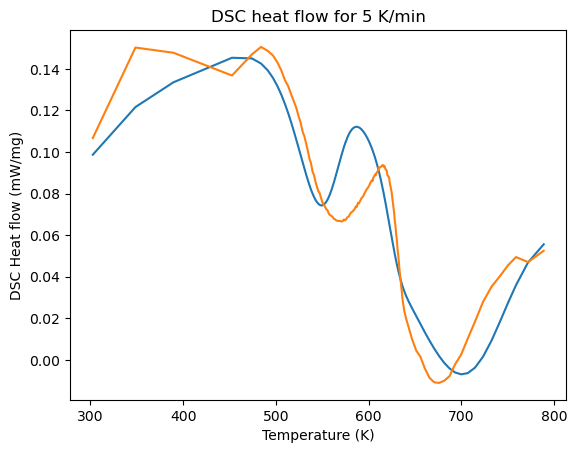

In [45]:
# Training on 5 K/min. Compute the Heat of Decomposition

hod_hemicellulose = -200 # from literature
hod_cellulose = -200
hod_lignin = 1855.4610958742392

# interpolate DSC data to non-zero mass loss rates
DSC_5K_interp = np.interp(x0[0:143],temp_5K_DSC_final, DSC_5K_final)
f_hemicellulose_5K_interp = np.interp(x0[0:143] + 273.15, temp_5K,f_hemicellulose_5K)
f_cellulose_5K_interp = np.interp(x0[0:143] + 273.15, temp_5K,f_cellulose_5K)
f_lignin_5K_interp = np.interp(x0[0:143] + 273.15, temp_5K,f_lignin_5K)
f_char_5K_interp = np.interp(x0[0:143] + 273.15, temp_5K,f_char_5K)
f_5K_interp = y02[0:143]
hemicellulose_dtg_5K_interp = np.interp(x0[0:143] + 273.15,temp_5K,hemicellulose_dtg_5K)
cellulose_dtg_5K_interp = np.interp(x0[0:143] + 273.15,temp_5K,cellulose_dtg_5K)
lignin_dtg_5K_interp = np.interp(x0[0:143] + 273.15,temp_5K,lignin_dtg_5K)

# Calculate gas phase enthalpy i.e., first calculate specific heat of the gaseous mixture. Then compute the sensible enthalpy of the mixture

# Compute integral of gaseous specific heat. Integrate from Tref = 273.15 to T
enthalpy_gas_hemicellulose_5K = np.zeros(np.shape(x0[0:143]))
enthalpy_sensible_hemicellulose_5K = np.zeros(np.shape(x0[0:143]))
enthalpy_gas_cellulose_5K = np.zeros(np.shape(x0[0:143]))
enthalpy_sensible_cellulose_5K = np.zeros(np.shape(x0[0:143]))
enthalpy_gas_lignin_5K = np.zeros(np.shape(x0[0:143]))
enthalpy_sensible_lignin_5K = np.zeros(np.shape(x0[0:143]))
cp_gas_hemicellulose_5K = np.zeros(500,)
cp_gas_cellulose_5K = np.zeros(500,)
cp_gas_lignin_5K = np.zeros(500,)
cp_sensible_gas_hemicellulose_5K = np.zeros(500,)
cp_sensible_gas_cellulose_5K = np.zeros(500,)
cp_sensible_gas_lignin_5K = np.zeros(500,)
gas_gri = ct.Solution('gri30.yaml') # define gas
P = 101325 # pressure
for i in range(0,len(enthalpy_gas_hemicellulose_5K)):
    # first calculate mass flow rates of the gases coming out from each pseudo-component 'j'
        CO2_mfr_hemicellulose_5K = (coeffs_co2[0]*hemicellulose_dtg_5K_interp[i]) 
        CO_mfr_hemicellulose_5K = (coeffs_co[0]*hemicellulose_dtg_5K_interp[i]) 
        CH4_mfr_hemicellulose_5K = (coeffs_ch4[0]*hemicellulose_dtg_5K_interp[i])
        # then calculate the total mass flow rate
        sum_gases_hemicellulose_5K = CH4_mfr_hemicellulose_5K + CO_mfr_hemicellulose_5K + CO2_mfr_hemicellulose_5K
        if sum_gases_hemicellulose_5K!=0:
            # if mass flow rate != 0, then calculate individual mass fractions of gases coming out from each pseudo-component
            temp_integrand =np.linspace(0,x0[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                # calculate Cp of gases coming out from each pseudo-component integrated from T = 0 to T = Tref and T = 0 to T = T
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K,'CO':CO_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K, 'CO2':CO2_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K} # gas composition for 5 K/min pyrolysis
                cp_gas_hemicellulose_5K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K,'CO':CO_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K, 'CO2':CO2_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K}
                cp_sensible_gas_hemicellulose_5K[j] = gas_gri.cp_mass
                # integrate to get gaseous enthalpies from T = 0 to T = Tref and T = 0 to T = T
            enthalpy_gas_hemicellulose_5K[i] = integrate.trapezoid(cp_gas_hemicellulose_5K, temp_integrand)
            enthalpy_sensible_hemicellulose_5K[i] = integrate.trapezoid(cp_sensible_gas_hemicellulose_5K, temp_ref_integrand)
        CO2_mfr_cellulose_5K = (coeffs_co2[1]*cellulose_dtg_5K_interp[i]) 
        CO_mfr_cellulose_5K = (coeffs_co[1]*cellulose_dtg_5K_interp[i]) 
        CH4_mfr_cellulose_5K = (coeffs_ch4[1]*cellulose_dtg_5K_interp[i])
        sum_gases_cellulose_5K = CH4_mfr_cellulose_5K + CO_mfr_cellulose_5K + CO2_mfr_cellulose_5K
        if sum_gases_cellulose_5K!=0:
            temp_integrand =np.linspace(0,x0[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_cellulose_5K/sum_gases_cellulose_5K,'CO':CO_mfr_cellulose_5K/sum_gases_cellulose_5K, 'CO2':CO2_mfr_cellulose_5K/sum_gases_cellulose_5K} # gas composition for 5 K/min pyrolysis
                cp_gas_cellulose_5K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_cellulose_5K/sum_gases_cellulose_5K,'CO':CO_mfr_cellulose_5K/sum_gases_cellulose_5K, 'CO2':CO2_mfr_cellulose_5K/sum_gases_cellulose_5K}
                cp_sensible_gas_cellulose_5K[j] = gas_gri.cp_mass
            enthalpy_gas_cellulose_5K[i] = integrate.trapezoid(cp_gas_cellulose_5K, temp_integrand)
            enthalpy_sensible_cellulose_5K[i] = integrate.trapezoid(cp_sensible_gas_cellulose_5K, temp_ref_integrand)
        CO2_mfr_lignin_5K = (coeffs_co2[2]*f_lignin_5K_interp[i]) 
        CO_mfr_lignin_5K = (coeffs_co[2]*f_lignin_5K_interp[i]) 
        CH4_mfr_lignin_5K = (coeffs_ch4[2]*f_lignin_5K_interp[i])
        sum_gases_lignin_5K = CH4_mfr_lignin_5K + CO_mfr_lignin_5K + CO2_mfr_lignin_5K
        if sum_gases_lignin_5K!=0:
            temp_integrand =np.linspace(0,x0[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_lignin_5K/sum_gases_lignin_5K,'CO':CO_mfr_lignin_5K/sum_gases_lignin_5K, 'CO2':CO2_mfr_lignin_5K/sum_gases_lignin_5K} # gas composition for 5 K/min pyrolysis
                cp_gas_lignin_5K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_lignin_5K/sum_gases_lignin_5K,'CO':CO_mfr_lignin_5K/sum_gases_lignin_5K, 'CO2':CO2_mfr_lignin_5K/sum_gases_lignin_5K}
                cp_sensible_gas_lignin_5K[j] = gas_gri.cp_mass
            enthalpy_gas_lignin_5K[i] = integrate.trapezoid(cp_gas_lignin_5K, temp_integrand)
            enthalpy_sensible_lignin_5K[i] = integrate.trapezoid(cp_sensible_gas_lignin_5K, temp_ref_integrand)

# Now calculate gaseous enthalpy from T = Tref to T = T
gaseous_enthalpy_parts_5K = (-hemicellulose_dtg_5K_interp*(enthalpy_gas_hemicellulose_5K - enthalpy_sensible_hemicellulose_5K)) + (-cellulose_dtg_5K_interp*(enthalpy_gas_cellulose_5K - enthalpy_sensible_cellulose_5K)) + (-lignin_dtg_5K_interp*(enthalpy_gas_lignin_5K - enthalpy_sensible_lignin_5K))

# calculate solid enthalpy as a combination of the components

temp_5K_celsius = temp_5K - 273.15
h_hemicellulose = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_5K_celsius**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_5K_celsius**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_5K_celsius**(effective_power_coeffs[5]+1))*1000 # lignin
h_char = (char_coeffs[0]*(temp_5K_celsius) + (char_coeffs[1]*(temp_5K_celsius**2)*0.5))*1000 # char

temp_ref = 0 # celsius

h_hemicellulose_ref = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_ref**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose_ref = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_ref**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin_ref = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_ref**(effective_power_coeffs[5]+1))*1000 # lignin
h_char_ref = (char_coeffs[0]*(temp_ref) + (char_coeffs[1]*(temp_ref**2)*0.5))*1000 # char

solid_enthalpy_hemicellulose_5K = np.interp(x0[0:143], temp_5K_celsius,h_hemicellulose - h_hemicellulose_ref)
solid_enthalpy_cellulose_5K = np.interp(x0[0:143] , temp_5K_celsius,h_cellulose - h_cellulose_ref)
solid_enthalpy_lignin_5K = np.interp(x0[0:143], temp_5K_celsius,h_lignin - h_lignin_ref)

solid_enthalpy_parts_5K = (-hemicellulose_dtg_5K_interp*solid_enthalpy_hemicellulose_5K) + (-cellulose_dtg_5K_interp*solid_enthalpy_cellulose_5K) + (-lignin_dtg_5K_interp*solid_enthalpy_lignin_5K)

# calculate sensible enthalpy of the solid

Cp_5K_interp = np.interp(x0[0:143] + 273.15, temp_5K, Cp_5K_fit)
sensible_heat_5K = (f_5K_interp*Cp_5K_interp*(5/60))

# Solve for heat of decomposition by minimization

def minimize_hod(x):
    
    hod = (-hemicellulose_dtg_5K_interp*x[0]) + (-cellulose_dtg_5K_interp*x[1]) + (-lignin_dtg_5K_interp*x[2])
    return (sensible_heat_5K + ((solid_enthalpy_parts_5K - gaseous_enthalpy_parts_5K + hod)) - (DSC_5K_interp*1000))

x0_hod = [hod_hemicellulose, hod_cellulose, -hod_lignin]

hod_array_5K_parts = optimize.least_squares(minimize_hod,x0_hod)
x_5K_parts = hod_array_5K_parts.x # Heats of decomposition of individual components


hod_5K = (-hemicellulose_dtg_5K_interp*x_5K_parts[0]) + (-cellulose_dtg_5K_interp*x_5K_parts[1]) + (-lignin_dtg_5K_interp*x_5K_parts[2])

dsc_5K_reconstructed = (sensible_heat_5K + ((solid_enthalpy_parts_5K - gaseous_enthalpy_parts_5K + hod_5K)))*0.001

plt.plot(x0[0:143] + 273.15, dsc_5K_reconstructed, label = 'Model')
plt.plot(x0[0:143] + 273.15, DSC_5K_interp, label = 'Experiment')
plt.xlabel('Temperature (K)')
plt.ylabel('DSC Heat flow (mW/mg)')
plt.title('DSC heat flow for 5 K/min')

Output the Heat of Decomposition

In [46]:
print('The heat of decomposition of Hemicellulose is ',x_5K_parts[0],'J/kg')
print('The heat of decomposition of Cellulose is ',x_5K_parts[1],'J/kg')
print('The heat of decomposition of Lignin is ',x_5K_parts[2],'J/kg')

The heat of decomposition of Hemicellulose is  39529.795072020905 J/kg
The heat of decomposition of Cellulose is  -146347.88956649665 J/kg
The heat of decomposition of Lignin is  579869.7096935975 J/kg


# The following cells document the validation procedure for solid phase heat flow and gas phase heat release rate

Now, validate the model on 10 K/min and 20 K/min test sets

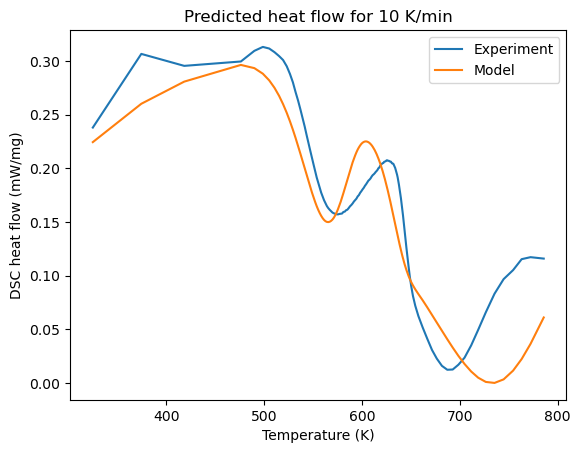

In [47]:
# Validating on 10 K/min

# 10 K/min fitting for DSC heat flow

# interpolate to desired ranges

DSC_10K_interp = np.interp(x1[0:139],temp_10K_DSC_final, DSC_10K_final)
Cp_10K_interp = np.interp(x1[0:139] + 273.15, temp_10K, Cp_10K_fit)
f_10K_interp = y12[0:139]
f_hemicellulose_10K_interp = np.interp(x1[0:139] + 273.15, temp_10K,f_hemicellulose_10K)
f_cellulose_10K_interp = np.interp(x1[0:139] + 273.15, temp_10K,f_cellulose_10K)
f_lignin_10K_interp = np.interp(x1[0:139] + 273.15, temp_10K,f_lignin_10K)

hemicellulose_dtg_10K_interp = np.interp(x1[0:139] + 273.15,temp_10K,hemicellulose_dtg_10K)
cellulose_dtg_10K_interp = np.interp(x1[0:139] + 273.15,temp_10K,cellulose_dtg_10K)
lignin_dtg_10K_interp = np.interp(x1[0:139] + 273.15,temp_10K,lignin_dtg_10K)

# Calculate gas phase enthalpy i.e., first calculate specific heat of the gaseous mixture. Then compute the sensible enthalpy of the mixture

enthalpy_gas_hemicellulose_10K = np.zeros(np.shape(x1[0:139]))
enthalpy_sensible_hemicellulose_10K = np.zeros(np.shape(x1[0:139]))
enthalpy_gas_cellulose_10K = np.zeros(np.shape(x1[0:139]))
enthalpy_sensible_cellulose_10K = np.zeros(np.shape(x1[0:139]))
enthalpy_gas_lignin_10K = np.zeros(np.shape(x1[0:139]))
enthalpy_sensible_lignin_10K = np.zeros(np.shape(x1[0:139]))
cp_gas_hemicellulose_10K = np.zeros(500,)
cp_gas_cellulose_10K = np.zeros(500,)
cp_gas_lignin_10K = np.zeros(500,)
cp_sensible_gas_hemicellulose_10K = np.zeros(500,)
cp_sensible_gas_cellulose_10K = np.zeros(500,)
cp_sensible_gas_lignin_10K = np.zeros(500,)


for i in range(len(enthalpy_gas_hemicellulose_10K)):
        CO2_mfr_hemicellulose_10K = (coeffs_co2[0]*hemicellulose_dtg_10K_interp[i]) 
        CO_mfr_hemicellulose_10K = (coeffs_co[0]*hemicellulose_dtg_10K_interp[i]) 
        CH4_mfr_hemicellulose_10K = (coeffs_ch4[0]*hemicellulose_dtg_10K_interp[i])
        sum_gases_hemicellulose_10K = CH4_mfr_hemicellulose_10K + CO_mfr_hemicellulose_10K + CO2_mfr_hemicellulose_10K
        if sum_gases_hemicellulose_10K!=0:
            temp_integrand =np.linspace(0,x1[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)): 
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_10K/sum_gases_hemicellulose_10K,'CO':CO_mfr_hemicellulose_10K/sum_gases_hemicellulose_10K, 'CO2':CO2_mfr_hemicellulose_10K/sum_gases_hemicellulose_10K} # gas composition for 5 K/min pyrolysis
                cp_gas_hemicellulose_10K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_10K/sum_gases_hemicellulose_10K,'CO':CO_mfr_hemicellulose_10K/sum_gases_hemicellulose_10K, 'CO2':CO2_mfr_hemicellulose_10K/sum_gases_hemicellulose_10K}
                cp_sensible_gas_hemicellulose_10K[j] = gas_gri.cp_mass
            enthalpy_gas_hemicellulose_10K[i] = integrate.trapezoid(cp_gas_hemicellulose_10K, temp_integrand)
            enthalpy_sensible_hemicellulose_10K[i] = integrate.trapezoid(cp_sensible_gas_hemicellulose_10K, temp_ref_integrand)
        CO2_mfr_cellulose_10K = (coeffs_co2[1]*cellulose_dtg_10K_interp[i]) 
        CO_mfr_cellulose_10K = (coeffs_co[1]*cellulose_dtg_10K_interp[i]) 
        CH4_mfr_cellulose_10K = (coeffs_ch4[1]*cellulose_dtg_10K_interp[i])
        sum_gases_cellulose_10K = CH4_mfr_cellulose_10K + CO_mfr_cellulose_10K + CO2_mfr_cellulose_10K
        if sum_gases_cellulose_10K!=0:
            temp_integrand =np.linspace(0,x1[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_cellulose_10K/sum_gases_cellulose_10K,'CO':CO_mfr_cellulose_10K/sum_gases_cellulose_10K, 'CO2':CO2_mfr_cellulose_10K/sum_gases_cellulose_10K} # gas composition for 5 K/min pyrolysis
                cp_gas_cellulose_10K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_cellulose_10K/sum_gases_cellulose_10K,'CO':CO_mfr_cellulose_10K/sum_gases_cellulose_10K, 'CO2':CO2_mfr_cellulose_10K/sum_gases_cellulose_10K}
                cp_sensible_gas_cellulose_10K[j] = gas_gri.cp_mass
            enthalpy_gas_cellulose_10K[i] = integrate.trapezoid(cp_gas_cellulose_10K, temp_integrand)
            enthalpy_sensible_cellulose_10K[i] = integrate.trapezoid(cp_sensible_gas_cellulose_10K, temp_ref_integrand)
        CO2_mfr_lignin_10K = (coeffs_co2[2]*lignin_dtg_10K_interp[i]) 
        CO_mfr_lignin_10K = (coeffs_co[2]*lignin_dtg_10K_interp[i]) 
        CH4_mfr_lignin_10K = (coeffs_ch4[2]*lignin_dtg_10K_interp[i])
        sum_gases_lignin_10K = CH4_mfr_lignin_10K + CO_mfr_lignin_10K + CO2_mfr_lignin_10K
        if sum_gases_lignin_10K!=0:
            temp_integrand =np.linspace(0,x1[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_lignin_10K/sum_gases_lignin_10K,'CO':CO_mfr_lignin_10K/sum_gases_lignin_10K, 'CO2':CO2_mfr_lignin_10K/sum_gases_lignin_10K} # gas composition for 5 K/min pyrolysis
                cp_gas_lignin_10K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_lignin_10K/sum_gases_lignin_10K,'CO':CO_mfr_lignin_10K/sum_gases_lignin_10K, 'CO2':CO2_mfr_lignin_10K/sum_gases_lignin_10K}
                cp_sensible_gas_lignin_10K[j] = gas_gri.cp_mass
            enthalpy_gas_lignin_10K[i] = integrate.trapezoid(cp_gas_lignin_10K, temp_integrand)
            enthalpy_sensible_lignin_10K[i] = integrate.trapezoid(cp_sensible_gas_lignin_10K, temp_ref_integrand)

# Calculate gas phase enthalpy from T = Tref to T = T        
gaseous_enthalpy_parts_10K = (-hemicellulose_dtg_10K_interp*(enthalpy_gas_hemicellulose_10K - enthalpy_sensible_hemicellulose_10K)) + (-cellulose_dtg_10K_interp*(enthalpy_gas_cellulose_10K - enthalpy_sensible_cellulose_10K)) + (-lignin_dtg_10K_interp*(enthalpy_gas_lignin_10K - enthalpy_sensible_lignin_10K))

# calculate solid enthalpy as a combination of the components using sensible specific heats of components

temp_10K_celsius = temp_10K - 273.15
h_hemicellulose = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_10K_celsius**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_10K_celsius**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_10K_celsius**(effective_power_coeffs[5]+1))*1000 # lignin
h_char = (char_coeffs[0]*(temp_5K_celsius) + (char_coeffs[1]*(temp_10K_celsius**2)*0.5))*1000 # char

temp_ref = 0 # celsius

h_hemicellulose_ref = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_ref**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose_ref = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_ref**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin_ref = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_ref**(effective_power_coeffs[5]+1))*1000 # lignin
h_char_ref = (char_coeffs[0]*(temp_ref) + (char_coeffs[1]*(temp_ref**2)*0.5))*1000 # char

# Calculate contribution of solid enthalpy to the total heat flow
solid_enthalpy_hemicellulose_10K = np.interp(x1[0:139] + 273.15, temp_10K,h_hemicellulose - h_hemicellulose_ref)
solid_enthalpy_cellulose_10K = np.interp(x1[0:139] + 273.15, temp_10K,h_cellulose - h_cellulose_ref)
solid_enthalpy_lignin_10K = np.interp(x1[0:139] + 273.15, temp_10K,h_lignin - h_lignin_ref)


solid_enthalpy_parts_10K = (-hemicellulose_dtg_10K_interp*solid_enthalpy_hemicellulose_10K) + (-cellulose_dtg_10K_interp*solid_enthalpy_cellulose_10K) + (-lignin_dtg_10K_interp*solid_enthalpy_lignin_10K)

# calculate sensible enthalpy of the solid


sensible_heat_10K = (f_10K_interp*Cp_10K_interp*(10/60))

# Reconstruct the heat of decomposition for 10 K/min

hod_10K = (-hemicellulose_dtg_10K_interp*x_5K_parts[0]) + (-cellulose_dtg_10K_interp*x_5K_parts[1]) + (-lignin_dtg_10K_interp*x_5K_parts[2])

# Using the sensible enthalpy of solid, solid enthalpy, heat of decomposition, and gaseous enthalpy, reconstruct the total heat flow

dsc_10K_reconstructed = (sensible_heat_10K + ((solid_enthalpy_parts_10K - gaseous_enthalpy_parts_10K + hod_10K)))*0.001

# Plot the Reconstructed DSC Heat Flows
plt.plot(x1[0:139] + 273.15, DSC_10K_interp,label='Experiment')
plt.plot(x1[0:139] + 273.15,dsc_10K_reconstructed,label='Model')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('DSC heat flow (mW/mg)')
plt.title('Predicted heat flow for 10 K/min')
plt.show()


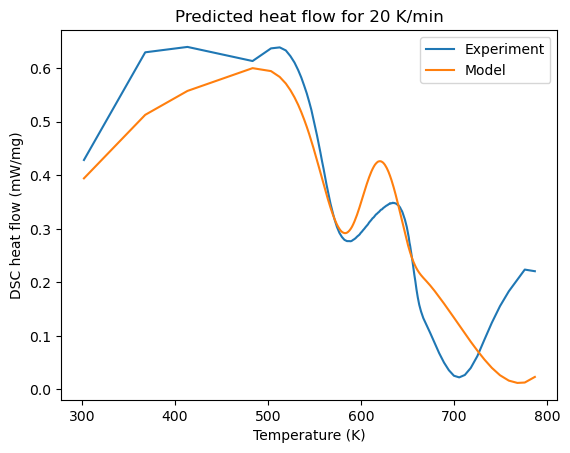

In [48]:
# 20 K/min fitting of DSC data.

# Validate the current model on 20 K/min Heat Flow data

# interpolate to desired ranges
DSC_20K_interp = np.interp(x2[0:139],temp_20K_DSC_final, DSC_20K_final)
Cp_20K_interp = np.interp(x2[0:139] + 273.15, temp_20K, Cp_20K_fit)
f_20K_interp = y22[0:139]
f_hemicellulose_20K_interp = np.interp(x2[0:139] + 273.15, temp_20K,f_hemicellulose_20K)
f_cellulose_20K_interp = np.interp(x2[0:139] + 273.15, temp_20K,f_cellulose_20K)
f_lignin_20K_interp = np.interp(x2[0:139] + 273.15, temp_20K,f_lignin_20K)

hemicellulose_dtg_20K_interp = np.interp(x2[0:139] + 273.15,temp_20K,hemicellulose_dtg_20K)
cellulose_dtg_20K_interp = np.interp(x2[0:139] + 273.15,temp_20K,cellulose_dtg_20K)
lignin_dtg_20K_interp = np.interp(x2[0:139] + 273.15,temp_20K,lignin_dtg_20K)

# Calculate gas phase enthalpy i.e., first calculate specific heat of the gaseous mixture. Then compute the sensible enthalpy of the mixture

enthalpy_gas_hemicellulose_20K = np.zeros(np.shape(x2[0:139]))
enthalpy_sensible_hemicellulose_20K = np.zeros(np.shape(x2[0:139]))
enthalpy_gas_cellulose_20K = np.zeros(np.shape(x2[0:139]))
enthalpy_sensible_cellulose_20K = np.zeros(np.shape(x2[0:139]))
enthalpy_gas_lignin_20K = np.zeros(np.shape(x2[0:139]))
enthalpy_sensible_lignin_20K = np.zeros(np.shape(x2[0:139]))
cp_gas_hemicellulose_20K = np.zeros(500,)
cp_gas_cellulose_20K = np.zeros(500,)
cp_gas_lignin_20K = np.zeros(500,)
cp_sensible_gas_hemicellulose_20K = np.zeros(500,)
cp_sensible_gas_cellulose_20K = np.zeros(500,)
cp_sensible_gas_lignin_20K = np.zeros(500,)

for i in range(0,len(enthalpy_gas_hemicellulose_20K)):
        CO2_mfr_hemicellulose_20K = (coeffs_co2[0]*hemicellulose_dtg_20K_interp[i]) 
        CO_mfr_hemicellulose_20K = (coeffs_co[0]*hemicellulose_dtg_20K_interp[i]) 
        CH4_mfr_hemicellulose_20K = (coeffs_ch4[0]*hemicellulose_dtg_20K_interp[i])
        sum_gases_hemicellulose_20K = CH4_mfr_hemicellulose_20K + CO_mfr_hemicellulose_20K + CO2_mfr_hemicellulose_20K
        if sum_gases_hemicellulose_20K!=0:
            gas_gri.TPY = x2[i] + 273.15, P, {'CH4':CH4_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K,'CO':CO_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K, 'CO2':CO2_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K} # gas composition for 5 K/min pyrolysis
            temp_integrand =np.linspace(0,x2[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K,'CO':CO_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K, 'CO2':CO2_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K} # gas composition for 5 K/min pyrolysis
                cp_gas_hemicellulose_20K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K,'CO':CO_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K, 'CO2':CO2_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K}
                cp_sensible_gas_hemicellulose_20K[j] = gas_gri.cp_mass
            enthalpy_gas_hemicellulose_20K[i] = integrate.trapezoid(cp_gas_hemicellulose_20K, temp_integrand)
            enthalpy_sensible_hemicellulose_20K[i] = integrate.trapezoid(cp_sensible_gas_hemicellulose_20K, temp_ref_integrand)
            
        CO2_mfr_cellulose_20K = (coeffs_co2[1]*cellulose_dtg_20K_interp[i]) 
        CO_mfr_cellulose_20K = (coeffs_co[1]*cellulose_dtg_20K_interp[i]) 
        CH4_mfr_cellulose_20K = (coeffs_ch4[1]*cellulose_dtg_20K_interp[i])
        sum_gases_cellulose_20K = CH4_mfr_cellulose_20K + CO_mfr_cellulose_20K + CO2_mfr_cellulose_20K
        if sum_gases_cellulose_20K!=0:
            gas_gri.TPY = x2[i] + 273.15, P, {'CH4':CH4_mfr_cellulose_20K/sum_gases_cellulose_20K,'CO':CO_mfr_cellulose_20K/sum_gases_cellulose_20K, 'CO2':CO2_mfr_cellulose_20K/sum_gases_cellulose_20K} # gas composition for 5 K/min pyrolysis
            temp_integrand =np.linspace(0,x2[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_cellulose_20K/sum_gases_cellulose_20K,'CO':CO_mfr_cellulose_20K/sum_gases_cellulose_20K, 'CO2':CO2_mfr_cellulose_20K/sum_gases_cellulose_20K} # gas composition for 5 K/min pyrolysis
                cp_gas_cellulose_20K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_cellulose_20K/sum_gases_cellulose_20K,'CO':CO_mfr_cellulose_20K/sum_gases_cellulose_20K, 'CO2':CO2_mfr_cellulose_20K/sum_gases_cellulose_20K}
                cp_sensible_gas_cellulose_20K[j] = gas_gri.cp_mass
            enthalpy_gas_cellulose_20K[i] = integrate.trapezoid(cp_gas_cellulose_20K, temp_integrand)
            enthalpy_sensible_cellulose_20K[i] = integrate.trapezoid(cp_sensible_gas_cellulose_20K, temp_ref_integrand)
            
        CO2_mfr_lignin_20K = (coeffs_co2[2]*lignin_dtg_20K_interp[i]) 
        CO_mfr_lignin_20K = (coeffs_co[2]*lignin_dtg_20K_interp[i]) 
        CH4_mfr_lignin_20K = (coeffs_ch4[2]*lignin_dtg_20K_interp[i])
        sum_gases_lignin_20K = CH4_mfr_lignin_20K + CO_mfr_lignin_20K + CO2_mfr_lignin_20K
        if sum_gases_lignin_20K!=0:
            gas_gri.TPY = x2[i] + 273.15, P, {'CH4':CH4_mfr_lignin_20K/sum_gases_lignin_20K,'CO':CO_mfr_lignin_20K/sum_gases_lignin_20K, 'CO2':CO2_mfr_lignin_20K/sum_gases_lignin_20K} # gas composition for 5 K/min pyrolysis
            temp_integrand =np.linspace(0,x2[i] + 273.15,500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_lignin_20K/sum_gases_lignin_20K,'CO':CO_mfr_lignin_20K/sum_gases_lignin_20K, 'CO2':CO2_mfr_lignin_20K/sum_gases_lignin_20K} # gas composition for 5 K/min pyrolysis
                cp_gas_lignin_20K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_lignin_20K/sum_gases_lignin_20K,'CO':CO_mfr_lignin_20K/sum_gases_lignin_20K, 'CO2':CO2_mfr_lignin_20K/sum_gases_lignin_20K}
                cp_sensible_gas_lignin_20K[j] = gas_gri.cp_mass
            enthalpy_gas_lignin_20K[i] = integrate.trapezoid(cp_gas_lignin_20K, temp_integrand)
            enthalpy_sensible_lignin_20K[i] = integrate.trapezoid(cp_sensible_gas_lignin_20K, temp_ref_integrand)
            
# Calculate gas phase enthalpy from T = Tref to T = T  

gaseous_enthalpy_parts_20K = (-hemicellulose_dtg_20K_interp*(enthalpy_gas_hemicellulose_20K - enthalpy_sensible_hemicellulose_20K)) + (-cellulose_dtg_20K_interp*(enthalpy_gas_cellulose_20K - enthalpy_sensible_cellulose_20K)) + (-lignin_dtg_20K_interp*(enthalpy_gas_lignin_20K - enthalpy_sensible_lignin_20K))


# calculate solid enthalpy as a combination of the components using sensible specific heats of components

temp_20K_celsius = temp_20K - 273.15
h_hemicellulose = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_20K_celsius**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_20K_celsius**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_20K_celsius**(effective_power_coeffs[5]+1))*1000 # lignin
h_char = (char_coeffs[0]*(temp_5K_celsius) + (char_coeffs[1]*(temp_20K_celsius**2)*0.5))*1000 # char

temp_ref = 0 # celsius

h_hemicellulose_ref = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_ref**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose_ref = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_ref**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin_ref = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_ref**(effective_power_coeffs[5]+1))*1000 # lignin
h_char_ref = (char_coeffs[0]*(temp_ref) + (char_coeffs[1]*(temp_ref**2)*0.5))*1000 # char

# Calculate contribution of solid enthalpy to the total heat flow
solid_enthalpy_hemicellulose_20K = np.interp(x2[0:139] + 273.15, temp_20K,h_hemicellulose - h_hemicellulose_ref)
solid_enthalpy_cellulose_20K = np.interp(x2[0:139] + 273.15, temp_20K,h_cellulose - h_cellulose_ref)
solid_enthalpy_lignin_20K = np.interp(x2[0:139] + 273.15, temp_20K,h_lignin - h_lignin_ref)

solid_enthalpy_parts_20K = (-hemicellulose_dtg_20K_interp*solid_enthalpy_hemicellulose_20K) + (-cellulose_dtg_20K_interp*solid_enthalpy_cellulose_20K) + (-lignin_dtg_20K_interp*solid_enthalpy_lignin_20K)

# calculate sensible enthalpy of the solid
sensible_heat_20K = (f_20K_interp*Cp_20K_interp*(20/60))

# Reconstruct the heat of decomposition for 20 K/min

hod_20K = (-hemicellulose_dtg_20K_interp*x_5K_parts[0]) + (-cellulose_dtg_20K_interp*x_5K_parts[1]) + (-lignin_dtg_20K_interp*x_5K_parts[2])

# Using the sensible enthalpy of solid, solid enthalpy, heat of decomposition, and gaseous enthalpy, reconstruct the total heat flow

dsc_20K_reconstructed = (sensible_heat_20K + ((((solid_enthalpy_parts_20K - gaseous_enthalpy_parts_20K)) + hod_20K)))*0.001

# Plot the Reconstructed DSC Heat Flows
plt.plot(x2[0:139] + 273.15, DSC_20K_interp,label='Experiment')
plt.plot(x2[0:139] + 273.15,dsc_20K_reconstructed,label='Model')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('DSC heat flow (mW/mg)')
plt.title('Predicted heat flow for 20 K/min')
plt.show()


Export DSC values

In [49]:
dsc_reconstructed_export_20Kmin = pd.DataFrame([])
dsc_reconstructed_export_10Kmin = pd.DataFrame([])
dsc_reconstructed_export_5Kmin = pd.DataFrame([])

dsc_reconstructed_export_20Kmin['Temperature (K)'] = x2[0:139] + 273.15
dsc_reconstructed_export_10Kmin['Temperature (K)'] = x1[0:139] + 273.15
dsc_reconstructed_export_5Kmin['Temperature (K)'] = x0[0:143] + 273.15
dsc_reconstructed_export_20Kmin['Simulated DSC (mW/mg)'] = dsc_20K_reconstructed
dsc_reconstructed_export_20Kmin['Experimental DSC (mW/mg)'] = DSC_20K_interp
dsc_reconstructed_export_10Kmin['Simulated DSC (mW/mg)'] = dsc_10K_reconstructed
dsc_reconstructed_export_10Kmin['Experimental DSC (mW/mg)'] = DSC_10K_interp
dsc_reconstructed_export_5Kmin['Simulated DSC (mW/mg)'] = dsc_5K_reconstructed
dsc_reconstructed_export_5Kmin['Experimental DSC (mW/mg)'] = DSC_5K_interp


with pd.ExcelWriter('DSC validation data.xlsx') as writer:
    
    dsc_reconstructed_export_20Kmin.to_excel(writer,sheet_name='20 Kmin')
    dsc_reconstructed_export_10Kmin.to_excel(writer,sheet_name='10 Kmin')
    dsc_reconstructed_export_5Kmin.to_excel(writer,sheet_name='5 Kmin')

Plot all predictions together on the same plot

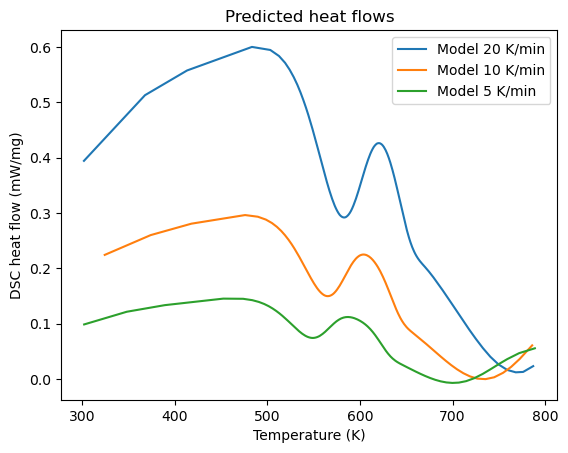

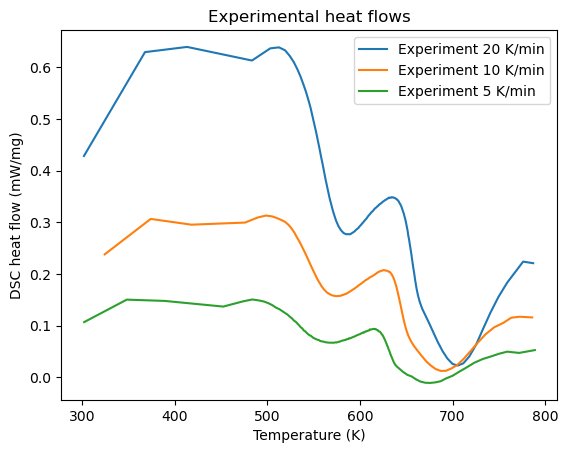

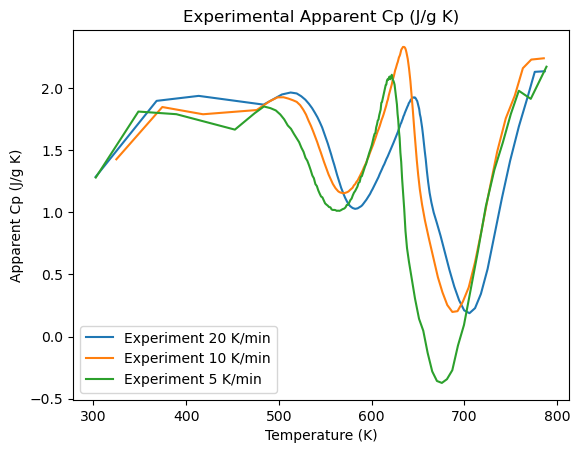

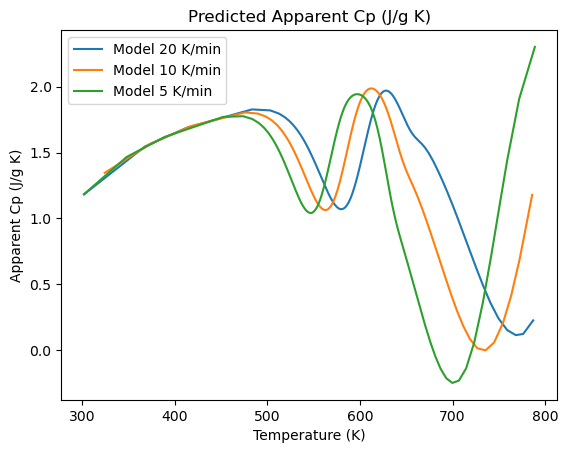

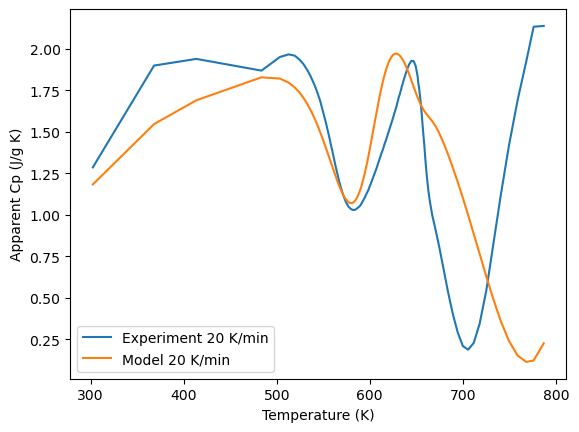

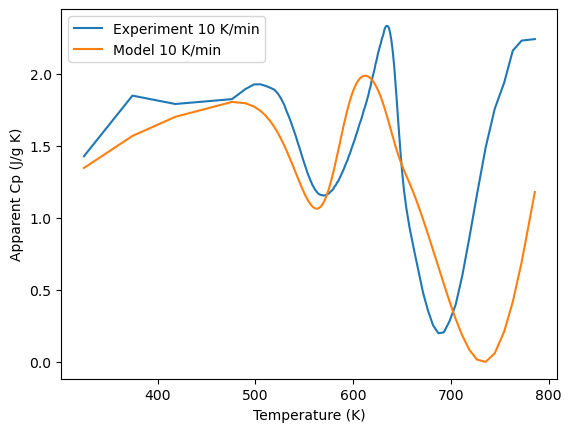

In [50]:
plt.plot(x2[0:139] + 273.15,dsc_20K_reconstructed,label='Model 20 K/min')
plt.plot(x1[0:139] + 273.15,dsc_10K_reconstructed,label='Model 10 K/min')
plt.plot(x0[0:143] + 273.15, dsc_5K_reconstructed, label = 'Model 5 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('DSC heat flow (mW/mg)')
plt.title('Predicted heat flows')
plt.show()

plt.plot(x2[0:139] + 273.15,DSC_20K_interp,label='Experiment 20 K/min')
plt.plot(x1[0:139] + 273.15,DSC_10K_interp,label='Experiment 10 K/min')
plt.plot(x0[0:143] + 273.15, DSC_5K_interp, label = 'Experiment 5 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('DSC heat flow (mW/mg)')
plt.title('Experimental heat flows')
plt.show()

plt.plot(x2[0:139] + 273.15,DSC_20K_interp/(f_20K_interp*(20/60)),label='Experiment 20 K/min')
plt.plot(x1[0:139] + 273.15,DSC_10K_interp/(f_10K_interp*(10/60)),label='Experiment 10 K/min')
plt.plot(x0[0:143] + 273.15, DSC_5K_interp/(f_5K_interp*(5/60)), label = 'Experiment 5 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Apparent Cp (J/g K)')
plt.title('Experimental Apparent Cp (J/g K)')
plt.show()

plt.plot(x2[0:139] + 273.15,dsc_20K_reconstructed/(f_20K_interp*(20/60)),label='Model 20 K/min')
plt.plot(x1[0:139] + 273.15,dsc_10K_reconstructed/(f_10K_interp*(10/60)),label='Model 10 K/min')
plt.plot(x0[0:143] + 273.15, dsc_5K_reconstructed/(f_5K_interp*(5/60)), label = 'Model 5 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Apparent Cp (J/g K)')
plt.title('Predicted Apparent Cp (J/g K)')
plt.show()

plt.plot(x2[0:139] + 273.15,DSC_20K_interp/(f_20K_interp*(20/60)),label='Experiment 20 K/min')
plt.plot(x2[0:139] + 273.15,dsc_20K_reconstructed/(f_20K_interp*(20/60)),label='Model 20 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Apparent Cp (J/g K)')
plt.show()

plt.plot(x1[0:139] + 273.15,DSC_10K_interp/(f_10K_interp*(10/60)),label='Experiment 10 K/min')
plt.plot(x1[0:139] + 273.15,dsc_10K_reconstructed/(f_10K_interp*(10/60)),label='Model 10 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Apparent Cp (J/g K)')
plt.show()


Compute the energetic contribution of each component and energetic contributions at different heating rates

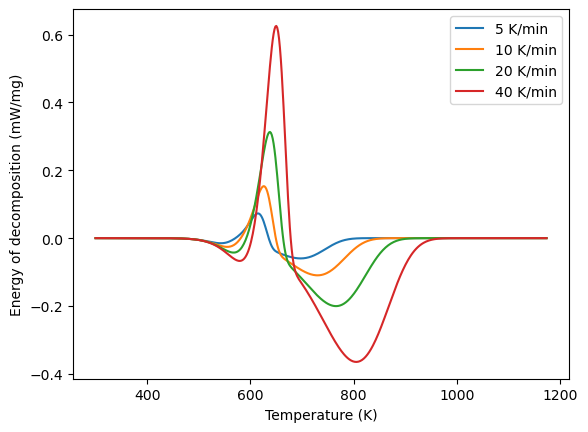

In [51]:
# Compute energetic contributions at different heating rates

# Compute energetic contributions at all heating rates to full range
hod_40K_full_range = (-hemicellulose_dtg_40K*x_5K_parts[0]) + (-cellulose_dtg_40K*x_5K_parts[1]) + (-lignin_dtg_40K*x_5K_parts[2])
hod_5K_full_range = (-hemicellulose_dtg_5K*x_5K_parts[0]) + (-cellulose_dtg_5K*x_5K_parts[1]) + (-lignin_dtg_5K*x_5K_parts[2])
hod_10K_full_range = (-hemicellulose_dtg_10K*x_5K_parts[0]) + (-cellulose_dtg_10K*x_5K_parts[1]) + (-lignin_dtg_10K*x_5K_parts[2])
hod_20K_full_range = (-hemicellulose_dtg_20K*x_5K_parts[0]) + (-cellulose_dtg_20K*x_5K_parts[1]) + (-lignin_dtg_20K*x_5K_parts[2])

# plot energetic contributions at different heating rates

plt.plot(temp_5K, hod_5K_full_range*0.001,label='5 K/min')
plt.plot(temp_10K, hod_10K_full_range*0.001,label='10 K/min')
plt.plot(temp_20K, hod_20K_full_range*0.001,label='20 K/min')
plt.plot(temp_40K, hod_40K_full_range*0.001,label='40 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Energy of decomposition (mW/mg)')
plt.show()

Predict the DSC curve for 40 K/min. Compare with other predictions. Plot all predictions over full range using model.

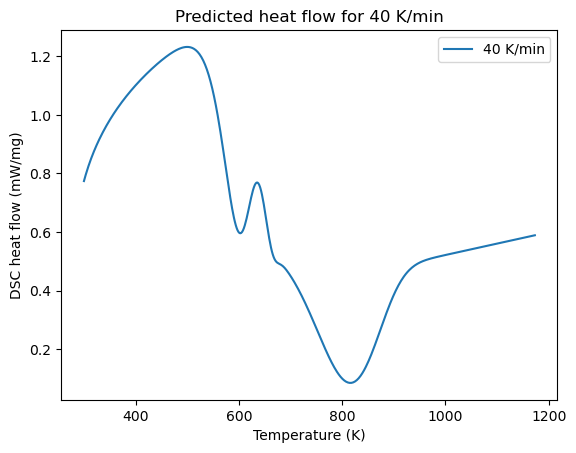

In [52]:
# Calculate gas phase enthalpy i.e., first calculate specific heat of the gaseous mixture. Then compute the sensible enthalpy of the mixture

enthalpy_gas_hemicellulose_40K = np.zeros(np.shape(temp_40K))
enthalpy_sensible_hemicellulose_40K = np.zeros(np.shape(temp_40K))
enthalpy_gas_cellulose_40K = np.zeros(np.shape(temp_40K))
enthalpy_sensible_cellulose_40K = np.zeros(np.shape(temp_40K))
enthalpy_gas_lignin_40K = np.zeros(np.shape(temp_40K))
enthalpy_sensible_lignin_40K = np.zeros(np.shape(temp_40K))
cp_gas_hemicellulose_40K = np.zeros(500,)
cp_gas_cellulose_40K = np.zeros(500,)
cp_gas_lignin_40K = np.zeros(500,)
cp_sensible_gas_hemicellulose_40K = np.zeros(500,)
cp_sensible_gas_cellulose_40K = np.zeros(500,)
cp_sensible_gas_lignin_40K = np.zeros(500,)
fres = 0.265
f_40K = fprime_hemicellulose_40K + fprime_cellulose_40K + fprime_lignin_40K + fres 

for i in range(len(enthalpy_gas_hemicellulose_40K)):
        CO2_mfr_hemicellulose_40K = (coeffs_co2[0]*hemicellulose_dtg_40K[i]) 
        CO_mfr_hemicellulose_40K = (coeffs_co[0]*hemicellulose_dtg_40K[i]) 
        CH4_mfr_hemicellulose_40K = (coeffs_ch4[0]*hemicellulose_dtg_40K[i])
        sum_gases_hemicellulose_40K = CH4_mfr_hemicellulose_40K + CO_mfr_hemicellulose_40K + CO2_mfr_hemicellulose_40K
        if sum_gases_hemicellulose_40K!=0:
            temp_integrand =np.linspace(0,temp_40K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)): 
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_40K/sum_gases_hemicellulose_40K,'CO':CO_mfr_hemicellulose_40K/sum_gases_hemicellulose_40K, 'CO2':CO2_mfr_hemicellulose_40K/sum_gases_hemicellulose_40K} # gas composition for 5 K/min pyrolysis
                cp_gas_hemicellulose_40K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_40K/sum_gases_hemicellulose_40K,'CO':CO_mfr_hemicellulose_40K/sum_gases_hemicellulose_40K, 'CO2':CO2_mfr_hemicellulose_40K/sum_gases_hemicellulose_40K}
                cp_sensible_gas_hemicellulose_40K[j] = gas_gri.cp_mass
            enthalpy_gas_hemicellulose_40K[i] = integrate.trapezoid(cp_gas_hemicellulose_40K, temp_integrand)
            enthalpy_sensible_hemicellulose_40K[i] = integrate.trapezoid(cp_sensible_gas_hemicellulose_40K, temp_ref_integrand)
        CO2_mfr_cellulose_40K = (coeffs_co2[1]*cellulose_dtg_40K[i]) 
        CO_mfr_cellulose_40K = (coeffs_co[1]*cellulose_dtg_40K[i]) 
        CH4_mfr_cellulose_40K = (coeffs_ch4[1]*cellulose_dtg_40K[i])
        sum_gases_cellulose_40K = CH4_mfr_cellulose_40K + CO_mfr_cellulose_40K + CO2_mfr_cellulose_40K
        if sum_gases_cellulose_40K!=0:
            temp_integrand =np.linspace(0,temp_40K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_cellulose_40K/sum_gases_cellulose_40K,'CO':CO_mfr_cellulose_40K/sum_gases_cellulose_40K, 'CO2':CO2_mfr_cellulose_40K/sum_gases_cellulose_40K} # gas composition for 5 K/min pyrolysis
                cp_gas_cellulose_40K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_cellulose_40K/sum_gases_cellulose_40K,'CO':CO_mfr_cellulose_40K/sum_gases_cellulose_40K, 'CO2':CO2_mfr_cellulose_40K/sum_gases_cellulose_40K}
                cp_sensible_gas_cellulose_40K[j] = gas_gri.cp_mass
            enthalpy_gas_cellulose_40K[i] = integrate.trapezoid(cp_gas_cellulose_40K, temp_integrand)
            enthalpy_sensible_cellulose_40K[i] = integrate.trapezoid(cp_sensible_gas_cellulose_40K, temp_ref_integrand)
        CO2_mfr_lignin_40K = (coeffs_co2[2]*lignin_dtg_40K[i]) 
        CO_mfr_lignin_40K = (coeffs_co[2]*lignin_dtg_40K[i]) 
        CH4_mfr_lignin_40K = (coeffs_ch4[2]*lignin_dtg_40K[i])
        sum_gases_lignin_40K = CH4_mfr_lignin_40K + CO_mfr_lignin_40K + CO2_mfr_lignin_40K
        if sum_gases_lignin_40K!=0:
            temp_integrand =np.linspace(0,temp_40K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_lignin_40K/sum_gases_lignin_40K,'CO':CO_mfr_lignin_40K/sum_gases_lignin_40K, 'CO2':CO2_mfr_lignin_40K/sum_gases_lignin_40K} # gas composition for 5 K/min pyrolysis
                cp_gas_lignin_40K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_lignin_40K/sum_gases_lignin_40K,'CO':CO_mfr_lignin_40K/sum_gases_lignin_40K, 'CO2':CO2_mfr_lignin_40K/sum_gases_lignin_40K}
                cp_sensible_gas_lignin_40K[j] = gas_gri.cp_mass
            enthalpy_gas_lignin_40K[i] = integrate.trapezoid(cp_gas_lignin_40K, temp_integrand)
            enthalpy_sensible_lignin_40K[i] = integrate.trapezoid(cp_sensible_gas_lignin_40K, temp_ref_integrand)

# Calculate gas phase enthalpy from T = Tref to T = T        
gaseous_enthalpy_parts_40K = (-hemicellulose_dtg_40K*(enthalpy_gas_hemicellulose_40K - enthalpy_sensible_hemicellulose_40K)) + (-cellulose_dtg_40K*(enthalpy_gas_cellulose_40K - enthalpy_sensible_cellulose_40K)) + (-lignin_dtg_40K*(enthalpy_gas_lignin_40K - enthalpy_sensible_lignin_40K))

# calculate solid enthalpy as a combination of the components using sensible specific heats of components

temp_40K_celsius = temp_40K - 273.15
h_hemicellulose = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_40K_celsius**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_40K_celsius**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_40K_celsius**(effective_power_coeffs[5]+1))*1000 # lignin
h_char = (char_coeffs[0]*(temp_40K_celsius) + (char_coeffs[1]*(temp_40K_celsius**2)*0.5))*1000 # char

temp_ref = 0 # celsius

h_hemicellulose_ref = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_ref**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose_ref = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_ref**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin_ref = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_ref**(effective_power_coeffs[5]+1))*1000 # lignin
h_char_ref = (char_coeffs[0]*(temp_ref) + (char_coeffs[1]*(temp_ref**2)*0.5))*1000 # char

# Calculate contribution of solid enthalpy to the total heat flow
solid_enthalpy_hemicellulose_40K = h_hemicellulose - h_hemicellulose_ref
solid_enthalpy_cellulose_40K = h_cellulose - h_cellulose_ref
solid_enthalpy_lignin_40K = h_lignin - h_lignin_ref


solid_enthalpy_parts_40K = (-hemicellulose_dtg_40K*solid_enthalpy_hemicellulose_40K) + (-cellulose_dtg_40K*solid_enthalpy_cellulose_40K) + (-lignin_dtg_40K*solid_enthalpy_lignin_40K)

# calculate sensible enthalpy of the solid


sensible_heat_40K = (f_40K*Cp_40K_fit*(40/60))

# Reconstruct the heat of decomposition for 40 K/min

hod_40K = (-hemicellulose_dtg_40K*x_5K_parts[0]) + (-cellulose_dtg_40K*x_5K_parts[1]) + (-lignin_dtg_40K*x_5K_parts[2])

# Using the sensible enthalpy of solid, solid enthalpy, heat of decomposition, and gaseous enthalpy, reconstruct the total heat flow

dsc_40K_reconstructed = (sensible_heat_40K + ((solid_enthalpy_parts_40K - gaseous_enthalpy_parts_40K + hod_40K)))*0.001

# Plot the Reconstructed DSC Heat Flows
plt.plot(temp_40K,dsc_40K_reconstructed,label='40 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('DSC heat flow (mW/mg)')
plt.title('Predicted heat flow for 40 K/min')
plt.show()

Get 20 K/min for full range. Similar full range smooth model curves can be generated for other heating rates

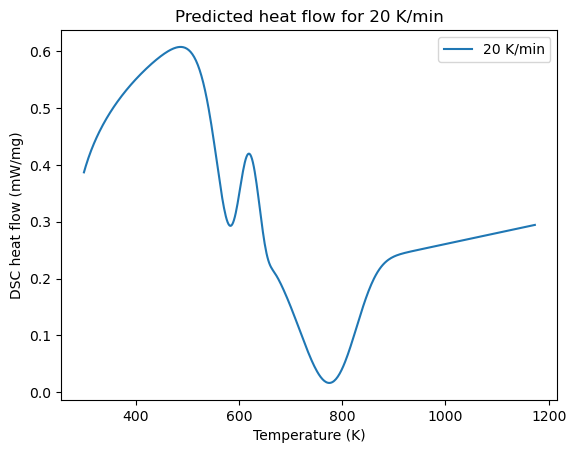

In [53]:
# Calculate gas phase enthalpy i.e., first calculate specific heat of the gaseous mixture. Then compute the sensible enthalpy of the mixture

enthalpy_gas_hemicellulose_20K = np.zeros(np.shape(temp_20K))
enthalpy_sensible_hemicellulose_20K = np.zeros(np.shape(temp_20K))
enthalpy_gas_cellulose_20K = np.zeros(np.shape(temp_20K))
enthalpy_sensible_cellulose_20K = np.zeros(np.shape(temp_20K))
enthalpy_gas_lignin_20K = np.zeros(np.shape(temp_20K))
enthalpy_sensible_lignin_20K = np.zeros(np.shape(temp_20K))
cp_gas_hemicellulose_20K = np.zeros(500,)
cp_gas_cellulose_20K = np.zeros(500,)
cp_gas_lignin_20K = np.zeros(500,)
cp_sensible_gas_hemicellulose_20K = np.zeros(500,)
cp_sensible_gas_cellulose_20K = np.zeros(500,)
cp_sensible_gas_lignin_20K = np.zeros(500,)
fres = 0.265
f_20K = fprime_hemicellulose_20K + fprime_cellulose_20K + fprime_lignin_20K + fres 

for i in range(len(enthalpy_gas_hemicellulose_20K)):
        CO2_mfr_hemicellulose_20K = (coeffs_co2[0]*hemicellulose_dtg_20K[i]) 
        CO_mfr_hemicellulose_20K = (coeffs_co[0]*hemicellulose_dtg_20K[i]) 
        CH4_mfr_hemicellulose_20K = (coeffs_ch4[0]*hemicellulose_dtg_20K[i])
        sum_gases_hemicellulose_20K= CH4_mfr_hemicellulose_20K + CO_mfr_hemicellulose_20K + CO2_mfr_hemicellulose_20K
        if sum_gases_hemicellulose_20K!=0:
            temp_integrand =np.linspace(0,temp_20K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)): 
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K,'CO':CO_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K, 'CO2':CO2_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K} # gas composition for 5 K/min pyrolysis
                cp_gas_hemicellulose_20K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K,'CO':CO_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K, 'CO2':CO2_mfr_hemicellulose_20K/sum_gases_hemicellulose_20K}
                cp_sensible_gas_hemicellulose_20K[j] = gas_gri.cp_mass
            enthalpy_gas_hemicellulose_20K[i] = integrate.trapezoid(cp_gas_hemicellulose_20K, temp_integrand)
            enthalpy_sensible_hemicellulose_20K[i] = integrate.trapezoid(cp_sensible_gas_hemicellulose_20K, temp_ref_integrand)
        CO2_mfr_cellulose_20K = (coeffs_co2[1]*cellulose_dtg_20K[i]) 
        CO_mfr_cellulose_20K = (coeffs_co[1]*cellulose_dtg_20K[i]) 
        CH4_mfr_cellulose_20K = (coeffs_ch4[1]*cellulose_dtg_20K[i])
        sum_gases_cellulose_20K = CH4_mfr_cellulose_20K + CO_mfr_cellulose_20K + CO2_mfr_cellulose_20K
        if sum_gases_cellulose_20K!=0:
            temp_integrand =np.linspace(0,temp_20K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_cellulose_20K/sum_gases_cellulose_20K,'CO':CO_mfr_cellulose_20K/sum_gases_cellulose_20K, 'CO2':CO2_mfr_cellulose_20K/sum_gases_cellulose_20K} # gas composition for 5 K/min pyrolysis
                cp_gas_cellulose_20K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_cellulose_20K/sum_gases_cellulose_20K,'CO':CO_mfr_cellulose_20K/sum_gases_cellulose_20K, 'CO2':CO2_mfr_cellulose_20K/sum_gases_cellulose_20K}
                cp_sensible_gas_cellulose_20K[j] = gas_gri.cp_mass
            enthalpy_gas_cellulose_20K[i] = integrate.trapezoid(cp_gas_cellulose_20K, temp_integrand)
            enthalpy_sensible_cellulose_20K[i] = integrate.trapezoid(cp_sensible_gas_cellulose_20K, temp_ref_integrand)
        CO2_mfr_lignin_20K = (coeffs_co2[2]*lignin_dtg_20K[i]) 
        CO_mfr_lignin_20K = (coeffs_co[2]*lignin_dtg_20K[i]) 
        CH4_mfr_lignin_20K = (coeffs_ch4[2]*lignin_dtg_20K[i])
        sum_gases_lignin_20K = CH4_mfr_lignin_20K + CO_mfr_lignin_20K + CO2_mfr_lignin_20K
        if sum_gases_lignin_20K!=0:
            temp_integrand =np.linspace(0,temp_20K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_lignin_20K/sum_gases_lignin_20K,'CO':CO_mfr_lignin_20K/sum_gases_lignin_20K, 'CO2':CO2_mfr_lignin_20K/sum_gases_lignin_20K} # gas composition for 5 K/min pyrolysis
                cp_gas_lignin_20K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_lignin_20K/sum_gases_lignin_20K,'CO':CO_mfr_lignin_20K/sum_gases_lignin_20K, 'CO2':CO2_mfr_lignin_20K/sum_gases_lignin_20K}
                cp_sensible_gas_lignin_20K[j] = gas_gri.cp_mass
            enthalpy_gas_lignin_20K[i] = integrate.trapezoid(cp_gas_lignin_20K, temp_integrand)
            enthalpy_sensible_lignin_20K[i] = integrate.trapezoid(cp_sensible_gas_lignin_20K, temp_ref_integrand)

# Calculate gas phase enthalpy from T = Tref to T = T        
gaseous_enthalpy_parts_20K = (-hemicellulose_dtg_20K*(enthalpy_gas_hemicellulose_20K - enthalpy_sensible_hemicellulose_20K)) + (-cellulose_dtg_20K*(enthalpy_gas_cellulose_20K - enthalpy_sensible_cellulose_20K)) + (-lignin_dtg_20K*(enthalpy_gas_lignin_20K - enthalpy_sensible_lignin_20K))

# calculate solid enthalpy as a combination of the components using sensible specific heats of components

temp_20K_celsius = temp_20K - 273.15
h_hemicellulose = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_20K_celsius**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_20K_celsius**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_20K_celsius**(effective_power_coeffs[5]+1))*1000 # lignin
h_char = (char_coeffs[0]*(temp_20K_celsius) + (char_coeffs[1]*(temp_20K_celsius**2)*0.5))*1000 # char

temp_ref = 0 # celsius

h_hemicellulose_ref = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_ref**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose_ref = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_ref**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin_ref = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_ref**(effective_power_coeffs[5]+1))*1000 # lignin
h_char_ref = (char_coeffs[0]*(temp_ref) + (char_coeffs[1]*(temp_ref**2)*0.5))*1000 # char

# Calculate contribution of solid enthalpy to the total heat flow
solid_enthalpy_hemicellulose_20K = h_hemicellulose - h_hemicellulose_ref
solid_enthalpy_cellulose_20K = h_cellulose - h_cellulose_ref
solid_enthalpy_lignin_20K = h_lignin - h_lignin_ref


solid_enthalpy_parts_20K = (-hemicellulose_dtg_20K*solid_enthalpy_hemicellulose_20K) + (-cellulose_dtg_20K*solid_enthalpy_cellulose_20K) + (-lignin_dtg_20K*solid_enthalpy_lignin_20K)

# calculate sensible enthalpy of the solid


sensible_heat_20K = (f_20K*Cp_20K_fit*(20/60))

# Reconstruct the heat of decomposition for 20 K/min

hod_20K = (-hemicellulose_dtg_20K*x_5K_parts[0]) + (-cellulose_dtg_20K*x_5K_parts[1]) + (-lignin_dtg_20K*x_5K_parts[2])

# Using the sensible enthalpy of solid, solid enthalpy, heat of decomposition, and gaseous enthalpy, reconstruct the total heat flow

dsc_20K_full_range = (sensible_heat_20K + ((solid_enthalpy_parts_20K - gaseous_enthalpy_parts_20K + hod_20K)))*0.001

# Plot the Reconstructed DSC Heat Flows
plt.plot(temp_20K,dsc_20K_full_range,label='20 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('DSC heat flow (mW/mg)')
plt.title('Predicted heat flow for 20 K/min')
plt.show()

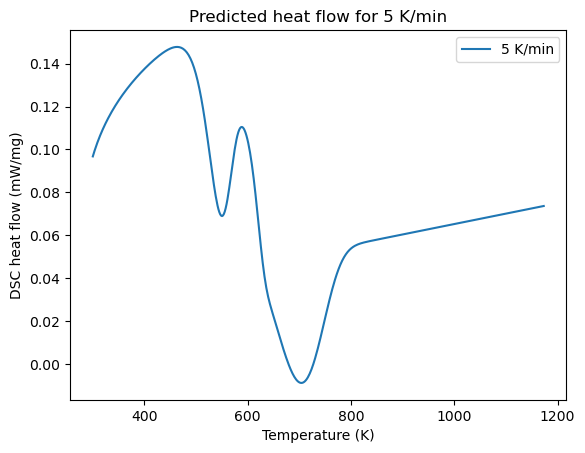

In [54]:
# Calculate gas phase enthalpy i.e., first calculate specific heat of the gaseous mixture. Then compute the sensible enthalpy of the mixture

enthalpy_gas_hemicellulose_5K = np.zeros(np.shape(temp_5K))
enthalpy_sensible_hemicellulose_5K = np.zeros(np.shape(temp_5K))
enthalpy_gas_cellulose_5K = np.zeros(np.shape(temp_5K))
enthalpy_sensible_cellulose_5K = np.zeros(np.shape(temp_5K))
enthalpy_gas_lignin_5K = np.zeros(np.shape(temp_5K))
enthalpy_sensible_lignin_5K = np.zeros(np.shape(temp_5K))
cp_gas_hemicellulose_5K = np.zeros(500,)
cp_gas_cellulose_5K = np.zeros(500,)
cp_gas_lignin_5K = np.zeros(500,)
cp_sensible_gas_hemicellulose_5K = np.zeros(500,)
cp_sensible_gas_cellulose_5K = np.zeros(500,)
cp_sensible_gas_lignin_5K = np.zeros(500,)
fres = 0.265
f_5K = fprime_hemicellulose_5K + fprime_cellulose_5K + fprime_lignin_5K + fres 

for i in range(len(enthalpy_gas_hemicellulose_5K)):
        CO2_mfr_hemicellulose_5K = (coeffs_co2[0]*hemicellulose_dtg_5K[i]) 
        CO_mfr_hemicellulose_5K = (coeffs_co[0]*hemicellulose_dtg_5K[i]) 
        CH4_mfr_hemicellulose_5K = (coeffs_ch4[0]*hemicellulose_dtg_5K[i])
        sum_gases_hemicellulose_5K= CH4_mfr_hemicellulose_5K + CO_mfr_hemicellulose_5K + CO2_mfr_hemicellulose_5K
        if sum_gases_hemicellulose_5K!=0:
            temp_integrand =np.linspace(0,temp_5K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)): 
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K,'CO':CO_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K, 'CO2':CO2_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K} # gas composition for 5 K/min pyrolysis
                cp_gas_hemicellulose_5K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K,'CO':CO_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K, 'CO2':CO2_mfr_hemicellulose_5K/sum_gases_hemicellulose_5K}
                cp_sensible_gas_hemicellulose_5K[j] = gas_gri.cp_mass
            enthalpy_gas_hemicellulose_5K[i] = integrate.trapezoid(cp_gas_hemicellulose_5K, temp_integrand)
            enthalpy_sensible_hemicellulose_5K[i] = integrate.trapezoid(cp_sensible_gas_hemicellulose_5K, temp_ref_integrand)
        CO2_mfr_cellulose_5K = (coeffs_co2[1]*cellulose_dtg_5K[i]) 
        CO_mfr_cellulose_5K = (coeffs_co[1]*cellulose_dtg_5K[i]) 
        CH4_mfr_cellulose_5K = (coeffs_ch4[1]*cellulose_dtg_5K[i])
        sum_gases_cellulose_5K = CH4_mfr_cellulose_5K + CO_mfr_cellulose_5K + CO2_mfr_cellulose_5K
        if sum_gases_cellulose_5K!=0:
            temp_integrand =np.linspace(0,temp_5K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_cellulose_5K/sum_gases_cellulose_5K,'CO':CO_mfr_cellulose_5K/sum_gases_cellulose_5K, 'CO2':CO2_mfr_cellulose_5K/sum_gases_cellulose_5K} # gas composition for 5 K/min pyrolysis
                cp_gas_cellulose_5K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_cellulose_5K/sum_gases_cellulose_5K,'CO':CO_mfr_cellulose_5K/sum_gases_cellulose_5K, 'CO2':CO2_mfr_cellulose_5K/sum_gases_cellulose_5K}
                cp_sensible_gas_cellulose_5K[j] = gas_gri.cp_mass
            enthalpy_gas_cellulose_5K[i] = integrate.trapezoid(cp_gas_cellulose_5K, temp_integrand)
            enthalpy_sensible_cellulose_5K[i] = integrate.trapezoid(cp_sensible_gas_cellulose_5K, temp_ref_integrand)
        CO2_mfr_lignin_5K = (coeffs_co2[2]*lignin_dtg_5K[i]) 
        CO_mfr_lignin_5K = (coeffs_co[2]*lignin_dtg_5K[i]) 
        CH4_mfr_lignin_5K = (coeffs_ch4[2]*lignin_dtg_5K[i])
        sum_gases_lignin_5K = CH4_mfr_lignin_5K + CO_mfr_lignin_5K + CO2_mfr_lignin_5K
        if sum_gases_lignin_5K!=0:
            temp_integrand =np.linspace(0,temp_5K[i],500)
            temp_ref_integrand =np.linspace(0,273.15,500)
            for j in range(1,len(temp_integrand)):
                gas_gri.TPY = temp_integrand[j], P, {'CH4':CH4_mfr_lignin_5K/sum_gases_lignin_5K,'CO':CO_mfr_lignin_5K/sum_gases_lignin_5K, 'CO2':CO2_mfr_lignin_5K/sum_gases_lignin_5K} # gas composition for 5 K/min pyrolysis
                cp_gas_lignin_5K[j] = gas_gri.cp_mass
                gas_gri.TPY = temp_ref_integrand[j], P, {'CH4':CH4_mfr_lignin_5K/sum_gases_lignin_5K,'CO':CO_mfr_lignin_5K/sum_gases_lignin_5K, 'CO2':CO2_mfr_lignin_5K/sum_gases_lignin_5K}
                cp_sensible_gas_lignin_5K[j] = gas_gri.cp_mass
            enthalpy_gas_lignin_5K[i] = integrate.trapezoid(cp_gas_lignin_5K, temp_integrand)
            enthalpy_sensible_lignin_5K[i] = integrate.trapezoid(cp_sensible_gas_lignin_5K, temp_ref_integrand)

# Calculate gas phase enthalpy from T = Tref to T = T        
gaseous_enthalpy_parts_5K = (-hemicellulose_dtg_5K*(enthalpy_gas_hemicellulose_5K - enthalpy_sensible_hemicellulose_5K)) + (-cellulose_dtg_5K*(enthalpy_gas_cellulose_5K - enthalpy_sensible_cellulose_5K)) + (-lignin_dtg_5K*(enthalpy_gas_lignin_5K - enthalpy_sensible_lignin_5K))

# calculate solid enthalpy as a combination of the components using sensible specific heats of components

temp_5K_celsius = temp_5K - 273.15
h_hemicellulose = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_5K_celsius**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_5K_celsius**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_5K_celsius**(effective_power_coeffs[5]+1))*1000 # lignin
h_char = (char_coeffs[0]*(temp_5K_celsius) + (char_coeffs[1]*(temp_5K_celsius**2)*0.5))*1000 # char

temp_ref = 0 # celsius

h_hemicellulose_ref = (effective_power_coeffs[0]/(effective_power_coeffs[1] + 1))*(temp_ref**(effective_power_coeffs[1]+1))*1000 # hemicellulose
h_cellulose_ref = (effective_power_coeffs[2]/(effective_power_coeffs[3] + 1))*(temp_ref**(effective_power_coeffs[3]+1))*1000 # cellulose
h_lignin_ref = (effective_power_coeffs[4]/(effective_power_coeffs[5] + 1))*(temp_ref**(effective_power_coeffs[5]+1))*1000 # lignin
h_char_ref = (char_coeffs[0]*(temp_ref) + (char_coeffs[1]*(temp_ref**2)*0.5))*1000 # char

# Calculate contribution of solid enthalpy to the total heat flow
solid_enthalpy_hemicellulose_5K = h_hemicellulose - h_hemicellulose_ref
solid_enthalpy_cellulose_5K = h_cellulose - h_cellulose_ref
solid_enthalpy_lignin_5K = h_lignin - h_lignin_ref


solid_enthalpy_parts_5K = (-hemicellulose_dtg_5K*solid_enthalpy_hemicellulose_5K) + (-cellulose_dtg_5K*solid_enthalpy_cellulose_5K) + (-lignin_dtg_5K*solid_enthalpy_lignin_5K)

# calculate sensible enthalpy of the solid


sensible_heat_5K = (f_5K*Cp_5K_fit*(5/60))

# Reconstruct the heat of decomposition for 5 K/min

hod_5K = (-hemicellulose_dtg_5K*x_5K_parts[0]) + (-cellulose_dtg_5K*x_5K_parts[1]) + (-lignin_dtg_5K*x_5K_parts[2])

# Using the sensible enthalpy of solid, solid enthalpy, heat of decomposition, and gaseous enthalpy, reconstruct the total heat flow

dsc_5K_full_range = (sensible_heat_5K + ((solid_enthalpy_parts_5K - gaseous_enthalpy_parts_5K + hod_5K)))*0.001

# Plot the Reconstructed DSC Heat Flows
plt.plot(temp_5K,dsc_5K_full_range,label='5 K/min')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('DSC heat flow (mW/mg)')
plt.title('Predicted heat flow for 5 K/min')
plt.show()

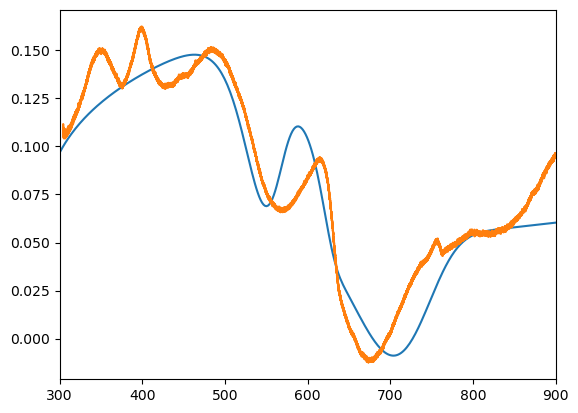

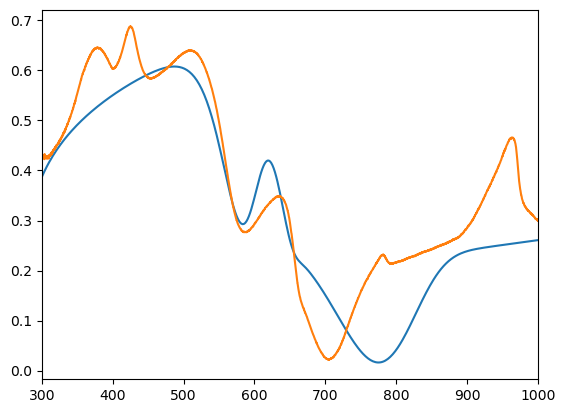

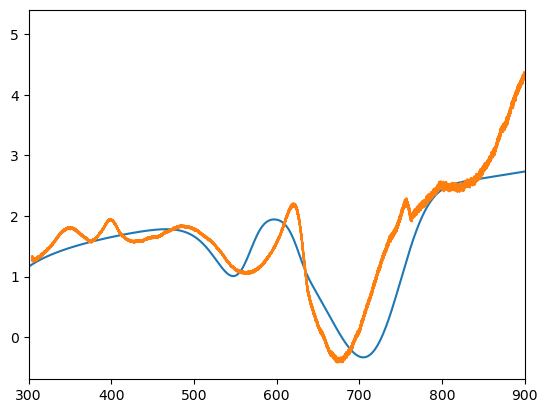

In [55]:
plt.plot(temp_5K,dsc_5K_full_range,label='5 K/min')
plt.plot(temp_5K_DSC_final + 273.15, DSC_5K_final,label='Experiment 5 K/min')
plt.xlim([300, 900])
plt.show()

plt.plot(temp_20K,dsc_20K_full_range,label='20 K/min')
plt.plot(temp_20K_DSC_final + 273.15, DSC_20K_final,label='Experiment 20 K/min')
plt.xlim([300, 1000])
plt.show()

plt.plot(temp_5K,dsc_5K_full_range/(f_5K*(5/60)), label = 'Model 5 K/min')
plt.plot(temp_5K_DSC_final + 273.15, C_apparent_5K,label='5 K/min')
plt.xlim([300, 900])
plt.show()

Plot full range predictions on top of each other.

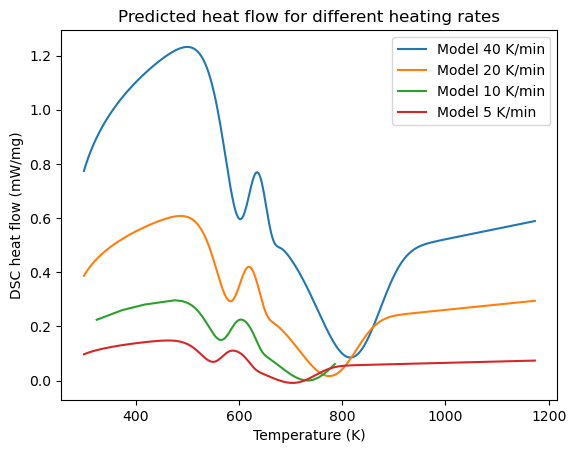

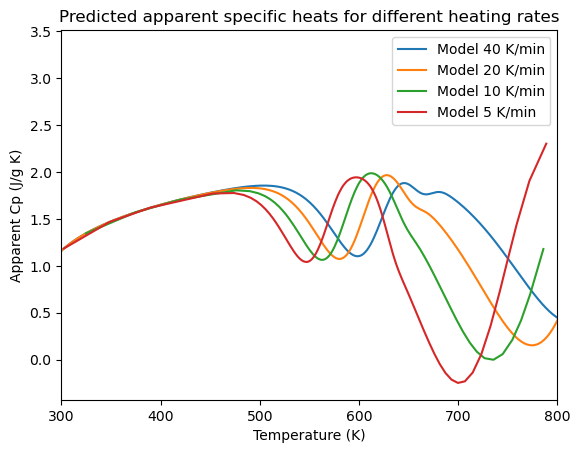

In [56]:
plt.plot(temp_40K,dsc_40K_reconstructed,label='Model 40 K/min')
plt.plot(temp_20K,dsc_20K_full_range,label='Model 20 K/min')
plt.plot(x1[0:139] + 273.15,dsc_10K_reconstructed,label='Model 10 K/min')
#plt.plot(x0[0:143] + 273.15, dsc_5K_reconstructed, label = 'Model 5 K/min')
plt.plot(temp_5K,dsc_5K_full_range,label='Model 5 K/min')
plt.legend()
plt.legend()
#plt.xlim([300, 800])
plt.xlabel('Temperature (K)')
plt.ylabel('DSC heat flow (mW/mg)')
plt.title('Predicted heat flow for different heating rates')
plt.show()

plt.plot(temp_40K,dsc_40K_reconstructed/(f_40K*(40/60)),label='Model 40 K/min')
plt.plot(temp_20K,dsc_20K_full_range/(f_20K*(20/60)),label='Model 20 K/min')
plt.plot(x1[0:139] + 273.15,dsc_10K_reconstructed/(f_10K_interp*(10/60)),label='Model 10 K/min')
plt.plot(x0[0:143] + 273.15, dsc_5K_reconstructed/(f_5K_interp*(5/60)), label = 'Model 5 K/min')
plt.legend()
plt.legend()
plt.xlim([300, 800])
plt.xlabel('Temperature (K)')
plt.ylabel('Apparent Cp (J/g K)')
plt.title('Predicted apparent specific heats for different heating rates')
plt.show()

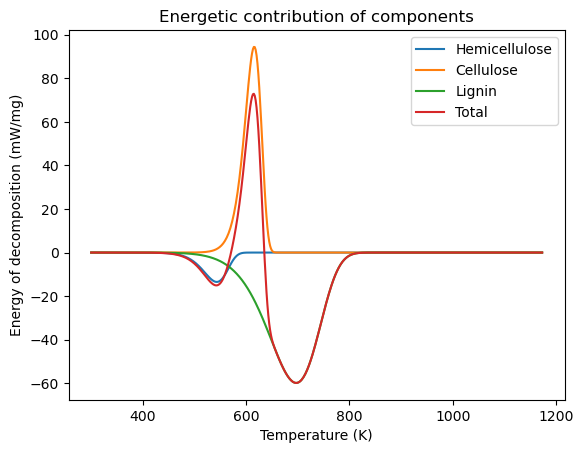

In [57]:
# Energetic contributions of pseudo-components at 5 K/min

hemicellulose_5K_hod = (-hemicellulose_dtg_5K*x_5K_parts[0])
cellulose_5K_hod = (-cellulose_dtg_5K*x_5K_parts[1])
lignin_5K_hod = (-lignin_dtg_5K*x_5K_parts[2])

# plot the energetic contributions of the components onto the total heat flow curve

plt.plot(temp_5K, hemicellulose_5K_hod, label='Hemicellulose')
plt.plot(temp_5K, cellulose_5K_hod,label='Cellulose')
plt.plot(temp_5K,lignin_5K_hod, label='Lignin')
plt.plot(temp_5K, hod_5K_full_range,label='Total')
plt.xlabel('Temperature (K)')
plt.ylabel('Energy of decomposition (mW/mg)')
plt.title('Energetic contribution of components')
plt.legend()
plt.show()

Heat release calculations from the volatile mass fractions

In [71]:
# Heat release calculations

gas_hrr = ct.Solution('four_step_pyrolysis.yaml')

mfr_co2_5Kmin_kinetics = (coeffs_co2[0]*hemicellulose_dtg_5K) + (coeffs_co2[1]*cellulose_dtg_5K) + (coeffs_co2[2]*lignin_dtg_5K)
mfr_co_5Kmin_kinetics = (coeffs_co_THC[0]*hemicellulose_dtg_5K) + (coeffs_co_THC[1]*cellulose_dtg_5K) + (coeffs_co_THC[2]*lignin_dtg_5K)
mfr_ch4_5Kmin_kinetics = (coeffs_ch4[0]*hemicellulose_dtg_5K) + (coeffs_ch4[1]*cellulose_dtg_5K) + (coeffs_ch4[2]*lignin_dtg_5K)

total_mfr_5Kmin_kinetics = mfr_co2_5Kmin_kinetics + mfr_co_5Kmin_kinetics + mfr_ch4_5Kmin_kinetics # normalized total mass flow rate. Normalized by initial mass
X_CO2_5Kmin = np.zeros(np.shape(mfr_ch4_5Kmin_kinetics)) # mole fractions
X_CO_5Kmin = np.zeros(np.shape(mfr_ch4_5Kmin_kinetics))
X_CH4_5Kmin = np.zeros(np.shape(mfr_ch4_5Kmin_kinetics))

for i in range(len(total_mfr_5Kmin_kinetics)):
    
    gas_hrr.TPY = None, None, {'CH4': mfr_ch4_5Kmin_kinetics[i]/total_mfr_5Kmin_kinetics[i],'CO2': mfr_co2_5Kmin_kinetics[i]/total_mfr_5Kmin_kinetics[i], 'CO': mfr_co_5Kmin_kinetics[i]/total_mfr_5Kmin_kinetics[i]}
    X_CH4_5Kmin[i] = gas_hrr.X[2]
    X_CO_5Kmin[i] = gas_hrr.X[3]
    X_CO2_5Kmin[i] = gas_hrr.X[4]

heating_values = np.zeros(np.shape(total_mfr_5Kmin_kinetics)) # plot heating values for different sample temperatures
stoic_mf = np.zeros(np.shape(total_mfr_5Kmin_kinetics)) # plot stoichiometric mass fraction for different sample temperatures

def plot_heating_value(temp, co2_yield, co_yield, ch4_yield):
    
    
    gas_hrr = ct.Solution("four_step_pyrolysis.yaml")
    water = ct.Water()
    # Set liquid water state, with vapor fraction x = 0
    water.TQ = 298, 0
    h_liquid = water.h
    # Set gaseous water state, with vapor fraction x = 1
    water.TQ = 298, 1
    h_gas = water.h

    def heating_value(fuel):
        """Returns the LHV and HHV for the specified fuel"""
        gas_hrr.TP = 298, ct.one_atm
      
        gas_hrr.set_equivalence_ratio(1.0, fuel, "O2:0.233,N2:0.767",basis='mass') # mass based calculations
        
        h1 = gas_hrr.enthalpy_mass
        Y_fuel = gas_hrr[fuel].Y.sum()
        

        # complete combustion products
        X_products = {
            "CO2": gas_hrr.elemental_mole_fraction("C"),
            "H2O": 0.5 * gas_hrr.elemental_mole_fraction("H"),
            "N2": 0.5 * gas_hrr.elemental_mole_fraction("N"),
        }

        gas_hrr.TPX = None, None, X_products
        Y_H2O = gas_hrr["H2O"].Y[0]
        h2 = gas_hrr.enthalpy_mass
        LHV = -(h2 - h1) / Y_fuel / 1e6
        HHV = -(h2 - h1 + (h_liquid - h_gas) * Y_H2O) / Y_fuel / 1e6
        return LHV, Y_fuel
    
    fuel = {'CO2': co2_yield, 'CO': co_yield, 'CH4': ch4_yield}
    LHV, Y_fuel = heating_value(fuel) 
    return LHV, Y_fuel

for i in range(len(X_CO2_5Kmin)):
    
    if any([X_CO2_5Kmin[i], X_CO_5Kmin[i], X_CH4_5Kmin[i]]):
        heating_values[i], stoic_mf[i] = plot_heating_value(temp_5K[i], X_CO2_5Kmin[i], X_CO_5Kmin[i], X_CH4_5Kmin[i]) # species yields and sample temperature are supplied

<Figure size 640x480 with 0 Axes>

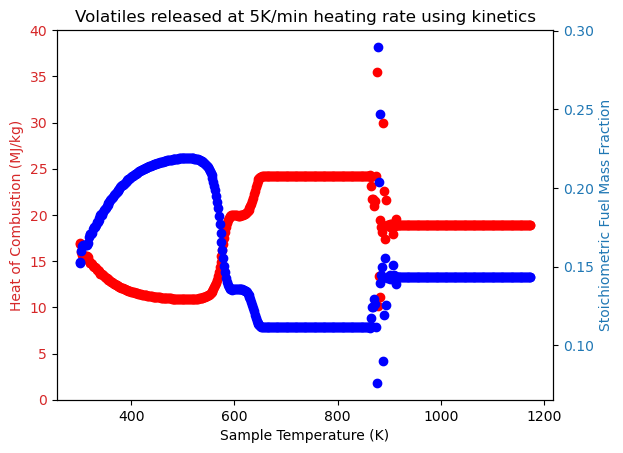

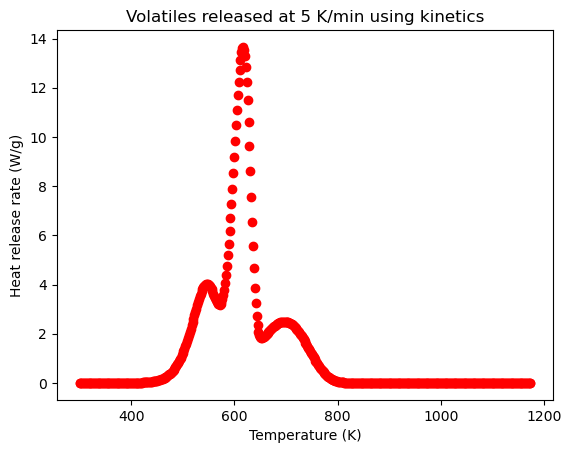

In [72]:
# Plot heat release for one heating rate first 5 K/min
plt.figure(1)

fig, ax = plt.subplots()

color = 'tab:red'
ax.set_xlabel('Sample Temperature (K)')
ax.set_ylabel('Heat of Combustion (MJ/kg)',color = color)
ax.tick_params(axis ='y', labelcolor = color) 
ax.set_ylim(0.0,40.0)
#start, end = ax.get_ylim()
#ax.yaxis.set_ticks(np.arange(start,end,0.05))
ax.plot(temp_5K, heating_values,'ro')

ax1 = ax.twinx()
color = 'tab:blue'
ax1.set_ylabel('Stoichiometric Fuel Mass Fraction', color = color)
ax1.tick_params(axis ='y', labelcolor = color) 

ax1.plot(temp_5K,stoic_mf,'bo')


plt.title('Volatiles released at 5K/min heating rate using kinetics')
plt.show()

#heat_release_rate_kinetics_5Kmin = total_mfr_5Kmin_kinetics*heating_values*(10**3)
heat_release_rate_kinetics_5Kmin = (hemicellulose_dtg_5K + cellulose_dtg_5K + lignin_dtg_5K)*heating_values*(10**3)

plt.plot(temp_5K, heat_release_rate_kinetics_5Kmin,'ro')
plt.xlabel('Temperature (K)')
plt.ylabel('Heat release rate (W/g)')
plt.title('Volatiles released at 5 K/min using kinetics')
plt.show()

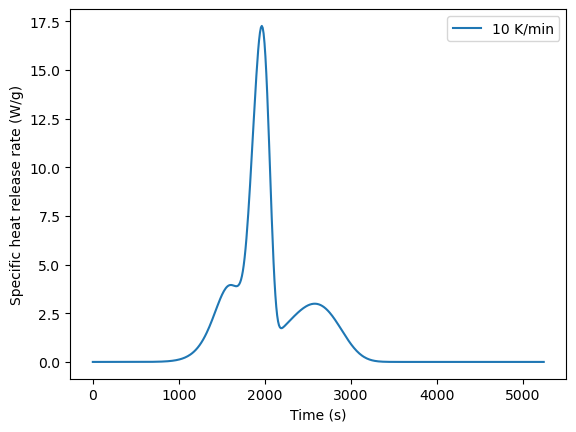

In [74]:
# 10 K/min heating rate

[heat_release_rate_10Kmin, heating_values_10Kmin, stoic_mf_10Kmin, times_10Kmin, temp_10Kmin, Y_CO2_10Kmin, Y_CO_10Kmin, Y_CH4_10Kmin] = specific_heat_release(10/60)

plt.plot(times_10Kmin, heat_release_rate_10Kmin,label='10 K/min')
#plt.xlim([30, 5000])
plt.xlabel('Time (s)')
plt.ylabel('Specific heat release rate (W/g)')
plt.legend()

In [76]:
# Heat release for different heating rates. Comparing MCC data from : Xu, Q.; Jiang, L.; Majlingova, A.; Ulbrikova, N.; Mensah, R.A.; Das, O.; Berto, F. WoodDust Flammability Analysis by Microscale Combustion Calorimetry.Polymers 2022, 14, 45. https://doi.org/10.3390/polym14010045

def specific_heat_release(hr):
    
    final_temp = 1173.15
    initial_temp = 300
    [temp, times, f_hemicellulose, f_cellulose, f_lignin, f_char, fprime_hemicellulose, fprime_cellulose, fprime_lignin] = estimate_mass_fractions(hr*60, A1, E1, A2, E2, A3, E3)
    times = np.linspace(0,((final_temp - initial_temp))/hr,500) # time taken
    hemicellulose_dtg = -np.gradient(fprime_hemicellulose, times) # hemicellulose dtg
    cellulose_dtg = -np.gradient(fprime_cellulose, times)
    lignin_dtg = -np.gradient(fprime_lignin, times)

    mfr_co2_kinetics = (coeffs_co2[0]*hemicellulose_dtg) + (coeffs_co2[1]*cellulose_dtg) + (coeffs_co2[2]*lignin_dtg)
    
    mfr_co_kinetics = (coeffs_co_THC[0]*hemicellulose_dtg) + (coeffs_co_THC[1]*cellulose_dtg) + (coeffs_co_THC[2]*lignin_dtg)
   
    mfr_ch4_kinetics = (coeffs_ch4[0]*hemicellulose_dtg) + (coeffs_ch4[1]*cellulose_dtg) + (coeffs_ch4[2]*lignin_dtg)
   
    total_mfr_kinetics = mfr_co2_kinetics + mfr_co_kinetics + mfr_ch4_kinetics
    X_CO2 = np.zeros(np.shape(mfr_ch4_kinetics)) # mole fractions
    X_CO = np.zeros(np.shape(mfr_ch4_kinetics))
    X_CH4 = np.zeros(np.shape(mfr_ch4_kinetics))
    Y_CH4 = np.zeros(np.shape(mfr_ch4_kinetics))
    Y_CO2 = np.zeros(np.shape(mfr_ch4_kinetics)) # mole fractions
    Y_CO = np.zeros(np.shape(mfr_ch4_kinetics))
    Y_CH4 = np.zeros(np.shape(mfr_ch4_kinetics))
    
        if total_mfr_kinetics[i]!=0:
            gas_hrr.TPY = None, None, {'CH4': mfr_ch4_kinetics[i]/total_mfr_kinetics[i],'CO2': mfr_co2_kinetics[i]/total_mfr_kinetics[i], 'CO': mfr_co_kinetics[i]/total_mfr_kinetics[i]}
            X_CH4[i] = gas_hrr.X[2]
            X_CO[i] = gas_hrr.X[3]
            X_CO2[i] = gas_hrr.X[4]
       
            Y_CH4[i] = mfr_ch4_kinetics[i]/total_mfr_kinetics[i]
            Y_CO[i] = mfr_co_kinetics[i]/total_mfr_kinetics[i]
            Y_CO2[i] = mfr_co2_kinetics[i]/total_mfr_kinetics[i]

    heating_values = np.zeros(np.shape(total_mfr_kinetics)) # plot heating values for different sample temperatures
    stoic_mf = np.zeros(np.shape(total_mfr_kinetics)) # plot stoichiometric mass fraction for different sample temperatures

    for i in range(len(X_CO2)):

        if any([X_CO2[i], X_CO[i], X_CH4[i]]):
            heating_values[i], stoic_mf[i] = plot_heating_value(temp[i], X_CO2[i], X_CO[i], X_CH4[i]) # species yields and sample temperature are supplied

    heat_release_rate_kinetics = (hemicellulose_dtg + cellulose_dtg + lignin_dtg)*heating_values*(10**3)
    return [heat_release_rate_kinetics, heating_values, stoic_mf, times, temp, Y_CO2, Y_CO, Y_CH4]

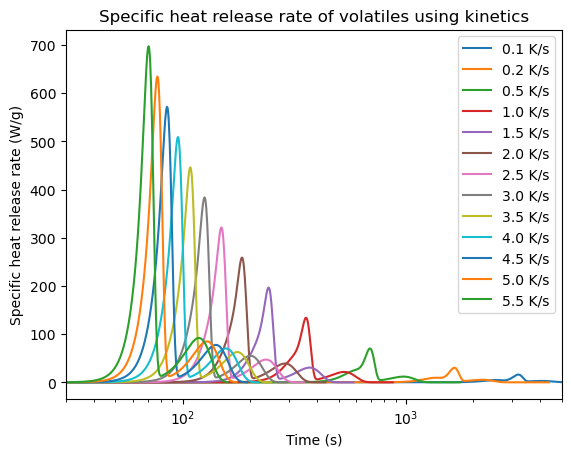

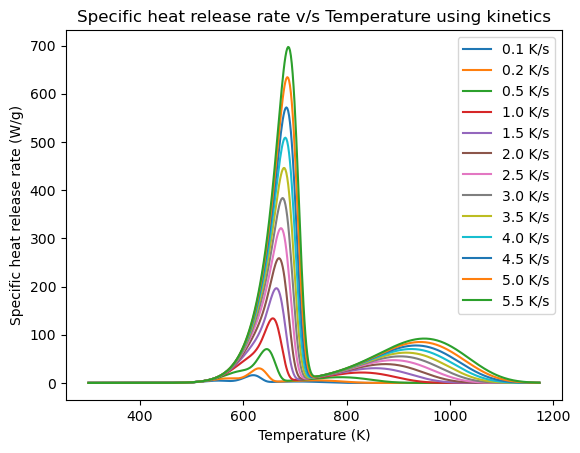

In [77]:
# Compare using Xu et al.'s experimental study
xu_heating_rates = [0.1, 0.2,0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5] # hrr's given in K/s
peak_heat_release = np.zeros(np.shape(xu_heating_rates))
peak_temp = np.zeros(np.shape(xu_heating_rates))
net_heat_release = np.zeros(np.shape(xu_heating_rates))
ignition_temp = np.zeros(np.shape(xu_heating_rates))
ignition_temp_20w = np.zeros(np.shape(xu_heating_rates))
ignition_capacity = np.zeros(np.shape(xu_heating_rates))
ignition_capacity_20w = np.zeros(np.shape(xu_heating_rates))
heat_release_df = pd.DataFrame([])
#heat_release_rate_kinetics_330Kmin = (hemicellulose_dtg_330K + cellulose_dtg_330K + lignin_dtg_330K)*heating_values_330K*(10**3)
for i in range(len(xu_heating_rates)):
    [heat_release_rate, heating_values, stoic_mf, times, temp, Y_CO2, Y_CO, Y_CH4] = specific_heat_release(xu_heating_rates[i])
    peak_heat_release[i] = np.max(heat_release_rate)
    peak_index = np.argmax(heat_release_rate)
    peak_temp[i] = temp[peak_index]
    net_heat_release[i] = integrate.trapezoid(heat_release_rate,x=times)
    cumulative_heat_release = integrate.cumulative_trapezoid(heat_release_rate, times, initial=0)
    percentage_heat_release = cumulative_heat_release/net_heat_release[i] # percentage heat release
    for j in range(len(percentage_heat_release)):
        if percentage_heat_release[j] <= 0.05:
            a = j
    for j in range(len(heat_release_rate)):
        if heat_release_rate[j] > 20:
            b = j-1
            break
        else:
            b = j
    ignition_temp[i] = temp[a]
    ignition_temp_20w[i] = temp[b]
    ignition_capacity[i] = net_heat_release[i]/ignition_temp[i]
    ignition_capacity_20w[i] = net_heat_release[i]/ignition_temp_20w[i]
    plt.figure(1)
    plt.semilogx(times, heat_release_rate,label=f'{xu_heating_rates[i]} K/s')
    plt.figure(2)
    plt.plot(temp, heat_release_rate,label=f'{xu_heating_rates[i]} K/s')
    heat_release_df[f'Time{xu_heating_rates[i]} K/s'] = np.array(times)
    heat_release_df[f'HRR{xu_heating_rates[i]} K/s'] = np.array(heat_release_rate)
plt.figure(1)
plt.xlim([30, 5000])
plt.xlabel('Time (s)')
plt.ylabel('Specific heat release rate (W/g)')
plt.legend()
plt.title('Specific heat release rate of volatiles using kinetics')
#plt.show()
plt.figure(2)
plt.xlabel('Temperature (K)')
plt.ylabel('Specific heat release rate (W/g)')
plt.legend()
plt.title('Specific heat release rate v/s Temperature using kinetics')
plt.show()
#plt.plot(temp_5K, heat_release_rate_kinetics_5Kmin,'ro',label='5 K/min')




In [78]:
print('The peak heat release rate for different heating rates is',peak_heat_release,'W/g')
print('The temp corresponding to the peak heat release rate for different heating rates is',peak_temp,'K')

The peak heat release rate for different heating rates is [ 16.09546895  30.22296669  70.21114254 134.02625928 196.60308039
 258.87175078 321.21743744 383.67175303 445.97997219 508.94984595
 571.75449067 634.48757517 697.24943289] W/g
The temp corresponding to the peak heat release rate for different heating rates is [618.46352705 630.71212425 644.71052104 656.95911824 663.95831663
 669.20771543 672.70731463 676.20691383 677.95671343 681.45631263
 683.20611222 684.95591182 686.70571142] K


In [79]:
# Write Xu et al. heat release data to file

with pd.ExcelWriter('Specific Heat Release Xu et al. validation.xlsx') as writer:
    for i in range(len(xu_heating_rates)):
        heat_release_df[f'Time{xu_heating_rates[i]} K/s'].to_excel(writer,sheet_name=f'{xu_heating_rates[i]} Ks Time')
        heat_release_df[f'HRR{xu_heating_rates[i]} K/s'].to_excel(writer,sheet_name=f'{xu_heating_rates[i]} Ks HRR')

646.4603206412826
76.71119967660421
662.2085170340681
186.0541642247097


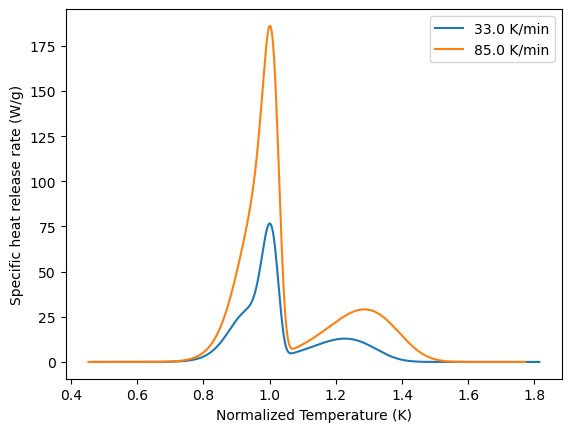

In [80]:
# Validate with Hostikka and Matala data. Cite as Hostikka S., and Matala A., Pyrolysis Model for Predicting the Heat Release Rate of Birch Wood, Comb. Sci. Tech., Vol. 189, Issue 8 (2017)

hostikka_heating_rates = [33/60, 85/60]
hostikka_heat_release = pd.DataFrame([])

for i in range(len(hostikka_heating_rates)):
    [heat_release_rate, heating_values, stoic_mf, times, temp, Y_CO2, Y_CO, Y_CH4] = specific_heat_release(hostikka_heating_rates[i])
    peak_heat_release[i] = np.max(heat_release_rate)
    peak_index = np.argmax(heat_release_rate)
    peak_temp[i] = temp[peak_index]
    hostikka_heat_release[f'Normalized Temp {hostikka_heating_rates[i]} K/s'] = np.array(temp/peak_temp[i])
    hostikka_heat_release[f'HRR{hostikka_heating_rates[i]} K/s'] = np.array(heat_release_rate)
    print(peak_temp[i])
    print(peak_heat_release[i])
    plt.plot(temp/peak_temp[i], heat_release_rate,label=f'{hostikka_heating_rates[i]*60} K/min')
    plt.legend()
    plt.xlabel('Normalized Temperature (K)')
    plt.ylabel('Specific heat release rate (W/g)')



In [81]:
# Write Hostikka validation data

with pd.ExcelWriter('Specific Heat Release Hostikka et al. validation.xlsx') as writer:
    hostikka_heat_release.to_excel(writer)


In [82]:
# Heat release capacity of the solid

heat_release_capacity = peak_heat_release/xu_heating_rates
heat_release_capacity

array([767.11199677, 930.27082112, 140.42228509, 134.02625928,
       131.06872026, 129.43587539, 128.48697497, 127.89058434,
       127.4228492 , 127.23746149, 127.05655348, 126.89751503,
       126.77262416])

Ignition capacities

In [1299]:
# Compare ignition capacities
ignition_capacity

array([23.56555372, 22.58502963, 21.44694023, 20.5989022 , 20.08015804,
       19.73913044, 19.48691705, 19.31073322, 19.09112539, 18.93780033,
       18.8464736 , 18.70617783, 18.62419569])

In [1298]:
ignition_capacity_20w

array([10.38469563, 19.67665489, 20.59806902, 20.66258752, 20.5783505 ,
       20.53741984, 20.45687323, 20.39206823, 20.33833607, 20.35614876,
       20.31679495, 20.282304  , 20.2515335 ])

In [1301]:
ignition_temp_20w

array([1173.15      ,  611.46432866,  574.71853707,  565.96953908,
        564.21973948,  562.46993988,  562.46993988,  562.46993988,
        562.46993988,  560.72014028,  560.72014028,  560.72014028,
        560.72014028])

In [77]:
# Specific heat release rate of the combustion gases 

specific_heat_release_gases = net_heat_release/(1 - fres)
specific_heat_release_gases

array([17563.92552133, 17355.42086002, 17068.56986467, 16837.24346889,
       16695.16705252, 16591.91325258, 16511.10022546, 16445.16987075,
       16389.9433835 , 16342.81066787, 16301.9740934 , 16266.07981   ,
       16234.04536038])

Plot gas phase mass fractions and corresponding heats of combustion as a function of MCC heating rates

(500.0, 800.0)

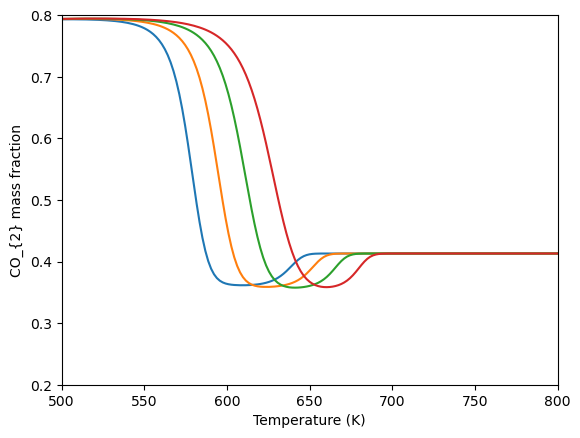

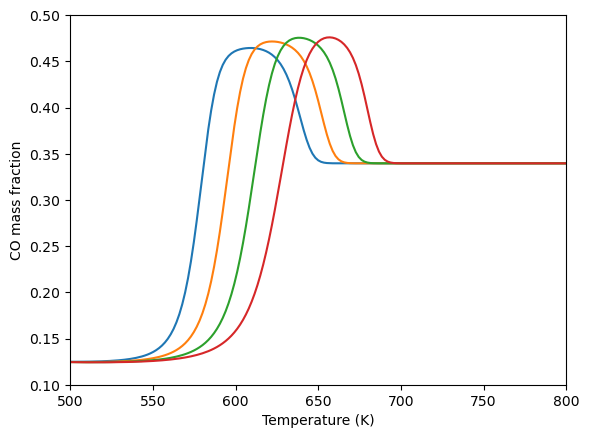

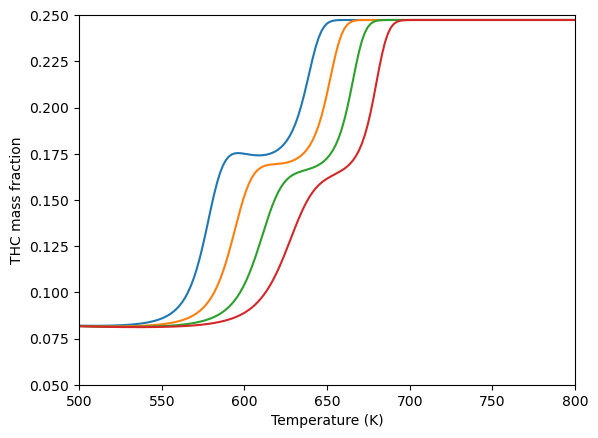

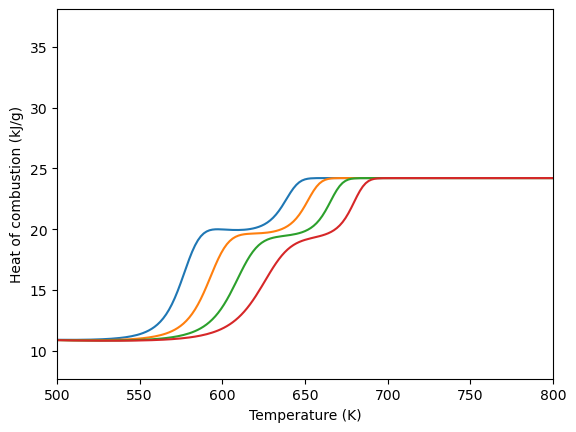

In [104]:
# Plot heat of combustion.


MCC_test_heating_rates = [5/60, 10/60, 20/60, 40/60] # heating rates in K/s 
total_mfr_5K = (coeffs_co2[0]*hemicellulose_dtg_5K) + (coeffs_co2[1]*cellulose_dtg_5K) + (coeffs_co2[2]*lignin_dtg_5K) + (coeffs_co[0]*hemicellulose_dtg_5K) + (coeffs_co[1]*cellulose_dtg_5K) + (coeffs_co[2]*lignin_dtg_5K) + (coeffs_ch4[0]*hemicellulose_dtg_5K) + (coeffs_ch4[1]*cellulose_dtg_5K) + (coeffs_ch4[2]*lignin_dtg_5K)
total_mfr_10K = (coeffs_co2[0]*hemicellulose_dtg_10K) + (coeffs_co2[1]*cellulose_dtg_10K) + (coeffs_co2[2]*lignin_dtg_10K) + (coeffs_co[0]*hemicellulose_dtg_10K) + (coeffs_co[1]*cellulose_dtg_5K) + (coeffs_co[2]*lignin_dtg_10K) + (coeffs_ch4[0]*hemicellulose_dtg_10K) + (coeffs_ch4[1]*cellulose_dtg_10K) + (coeffs_ch4[2]*lignin_dtg_10K)
total_mfr_20K = (coeffs_co2[0]*hemicellulose_dtg_20K) + (coeffs_co2[1]*cellulose_dtg_20K) + (coeffs_co2[2]*lignin_dtg_20K) + (coeffs_co[0]*hemicellulose_dtg_20K) + (coeffs_co[1]*cellulose_dtg_20K) + (coeffs_co[2]*lignin_dtg_20K) + (coeffs_ch4[0]*hemicellulose_dtg_20K) + (coeffs_ch4[1]*cellulose_dtg_20K) + (coeffs_ch4[2]*lignin_dtg_20K)
total_mfr_40K = (coeffs_co2[0]*hemicellulose_dtg_40K) + (coeffs_co2[1]*cellulose_dtg_40K) + (coeffs_co2[2]*lignin_dtg_40K) + (coeffs_co[0]*hemicellulose_dtg_40K) + (coeffs_co[1]*cellulose_dtg_40K) + (coeffs_co[2]*lignin_dtg_40K) + (coeffs_ch4[0]*hemicellulose_dtg_40K) + (coeffs_ch4[1]*cellulose_dtg_40K) + (coeffs_ch4[2]*lignin_dtg_40K)
total_mfrs = np.array([total_mfr_5K, total_mfr_10K, total_mfr_20K, total_mfr_40K])

# There are fluctuations after mass loss goes to zero. Reject these
heat_of_combustion_data = pd.DataFrame([])
for i in range(len(MCC_test_heating_rates)):
    [heat_release_rate, heating_values, stoic_mf, times, temp, Y_CO2, Y_CO, Y_CH4] = specific_heat_release(MCC_test_heating_rates[i])
    
    plt.figure(1)
    plt.plot(temp, Y_CO2,label=f'{MCC_test_heating_rates[i]*60} K/min')
    plt.figure(2)
    plt.plot(temp, Y_CO,label=f'{MCC_test_heating_rates[i]*60} K/min')
    plt.figure(3)
    plt.plot(temp, Y_CH4,label=f'{MCC_test_heating_rates[i]*60} K/min')
    plt.figure(4)
    plt.plot(temp, heating_values,label=f'{MCC_test_heating_rates[i]*60} K/min')
    heat_of_combustion_data[f'Temperature {MCC_test_heating_rates[i]*60} K/min'] = temp
    heat_of_combustion_data[f'CO mf {MCC_test_heating_rates[i]*60} K/min'] = Y_CO
    heat_of_combustion_data[f'CO2 mfr {MCC_test_heating_rates[i]*60} K/min'] = Y_CO2
    heat_of_combustion_data[f'CH4 {MCC_test_heating_rates[i]*60} K/min'] = Y_CH4
    heat_of_combustion_data[f'HOC {MCC_test_heating_rates[i]*60} K/min (kJ/g)'] = heating_values
plt.figure(1)
plt.xlabel('Temperature (K)')
plt.ylabel('CO_{2} mass fraction')
plt.xlim([500, 800])
plt.ylim([0.2, 0.8])
plt.figure(2)
plt.xlabel('Temperature (K)')
plt.ylabel('CO mass fraction')
plt.xlim([500, 800])
plt.ylim([0.1, 0.5])
plt.figure(3)
plt.xlabel('Temperature (K)')
plt.ylabel('THC mass fraction')
plt.xlim([500, 800])
plt.ylim([0.05, 0.25])
plt.figure(4)
plt.xlabel('Temperature (K)')
plt.ylabel('Heat of combustion (kJ/g)')
plt.xlim([500, 800])

# Write Hostikka validation data

with pd.ExcelWriter('Heats of combustion modeled.xlsx') as writer:
    heat_of_combustion_data.to_excel(writer)


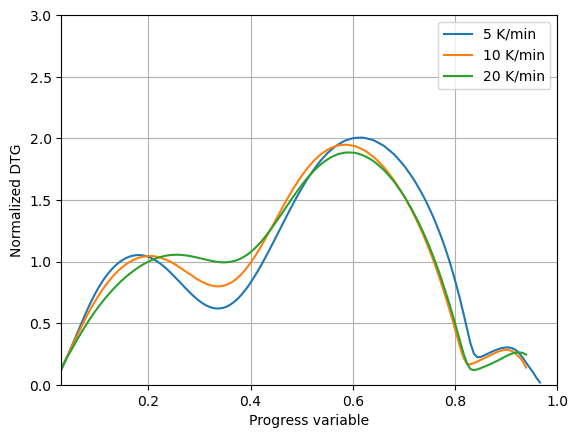

In [117]:
# Created by Shrikar on October 15, 2024 for testing micro to mesoscale transition

# Normalize DTG by its mean

plt.plot((1 - f_5K_interp)/(1 - fres),(hemicellulose_dtg_5K_interp + cellulose_dtg_5K_interp + lignin_dtg_5K_interp)/np.mean(hemicellulose_dtg_5K_interp + cellulose_dtg_5K_interp + lignin_dtg_5K_interp),label='5 K/min')
plt.plot((1 - f_10K_interp)/(1 - fres),(hemicellulose_dtg_10K_interp + cellulose_dtg_10K_interp + lignin_dtg_10K_interp)/np.mean(hemicellulose_dtg_10K_interp + cellulose_dtg_10K_interp + lignin_dtg_10K_interp),label='10 K/min')
plt.plot((1 - f_20K_interp)/(1 - fres),(hemicellulose_dtg_20K_interp + cellulose_dtg_20K_interp + lignin_dtg_20K_interp)/np.mean(hemicellulose_dtg_20K_interp + cellulose_dtg_20K_interp + lignin_dtg_20K_interp),label='20 K/min')
plt.xlim([0.03, 1])
plt.ylim([0, 3])
plt.legend()
plt.xlabel('Progress variable')
plt.ylabel('Normalized DTG')
plt.grid()
plt.show()

normalized_dtg_5K = pd.DataFrame([])
normalized_dtg_10K = pd.DataFrame([])
normalized_dtg_20K = pd.DataFrame([])
normalized_dtg_5K['Progress 5Kmin'] = (1 - f_5K_interp)/(1 - fres)
normalized_dtg_5K['Normalized DTG 5Kmin'] = (hemicellulose_dtg_5K_interp + cellulose_dtg_5K_interp + lignin_dtg_5K_interp)/np.mean(hemicellulose_dtg_5K_interp + cellulose_dtg_5K_interp + lignin_dtg_5K_interp)
normalized_dtg_10K['Progress 10Kmin'] = (1 - f_10K_interp)/(1 - fres)
normalized_dtg_10K['Normalized DTG 10Kmin'] = (hemicellulose_dtg_10K_interp + cellulose_dtg_10K_interp + lignin_dtg_10K_interp)/np.mean(hemicellulose_dtg_10K_interp + cellulose_dtg_10K_interp + lignin_dtg_10K_interp)
normalized_dtg_20K['Progress 20Kmin'] = (1 - f_20K_interp)/(1 - fres)
normalized_dtg_20K['Normalized DTG 20Kmin'] = (hemicellulose_dtg_20K_interp + cellulose_dtg_20K_interp + lignin_dtg_20K_interp)/np.mean(hemicellulose_dtg_20K_interp + cellulose_dtg_20K_interp + lignin_dtg_20K_interp)
with pd.ExcelWriter('Normalized DTG.xlsx') as writer:
    normalized_dtg_5K.to_excel(writer,sheet_name='5Kmin')
    normalized_dtg_10K.to_excel(writer,sheet_name='10Kmin')
    normalized_dtg_20K.to_excel(writer,sheet_name='20Kmin')